# 현재 최고점 (2.09879, 2.16295, 2.13087)

할 수 있는 것은 다 해 본 것 같습니다. 더 이상 무언가를 만들어내지 못할 것 같습니다. 마지막으로 지금까지 했던 모든 것을 갈아 넣어 보겠습니다.

### IMPORT LIBRARY & DATA

In [270]:
import load_dtypes as ld
import warnings
warnings.filterwarnings(action='ignore')
import os, sys

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

import numpy as np
from scipy.spatial import distance

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import KFold

In [271]:
print(pd.__version__)
print(np.__version__)
print(sns.__version__)
print(sklearn.__version__)

1.0.5
1.19.3
0.10.1
0.23.1


In [272]:
TRAIN_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\train\train.csv'
TEST_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\test'
SUBMISSION_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\sample_submission.csv'

In [273]:
train = ld.load_dtypes(TRAIN_PATH)
train.info()
submission = pd.read_csv(SUBMISSION_PATH)
test = ld.load_dtypes(TEST_PATH + '/0.csv')

C:\Users\Wyatt\wyatt37\Data\solarpanel\train\train.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int16  
 1   Hour    52560 non-null  int8   
 2   Minute  52560 non-null  int8   
 3   DHI     52560 non-null  int16  
 4   DNI     52560 non-null  int16  
 5   WS      52560 non-null  float32
 6   RH      52560 non-null  float32
 7   T       52560 non-null  int8   
 8   TARGET  52560 non-null  float32
dtypes: float32(3), int16(3), int8(3)
memory usage: 1.1 MB
C:\Users\Wyatt\wyatt37\Data\solarpanel\test/0.csv


In [274]:
# hour와 minute을 합쳐주는 함수입니다.
def sum_hour_minute(train):
    # 0과 30으로 되어 있는 minute을 0과 0.5로 바꿉니다.
    train.Minute = round(train.Minute * 0.017, 1)
    # hour에 minute을 더해줍니다.
    train.Hour = train.Hour + train.Minute
    
    return train

In [275]:
train = sum_hour_minute(train)

## 지금까지 쓴 변수들 전부 집어 넣어보기

### GHI_1

In [276]:
def dhi_angle_normalizor(list_, lags=48):
    """
    definition:
    DHI의 값을 통해서 0~180도 사이의 각도를 output으로 리턴
    
    """
    min_ = min(list_)
    max_ = max(list_)
    return ((list_ - min_) / (max_ - min_))*180

def ghi_formula(DHI, DNI, theta):
    """
    definition:
    theta값을 통해서 DHI와 DNI에 의한 GHI를 계산하여 리턴
    
    """
    
    return (DHI + (DNI*np.cos((np.abs(theta-90)-1)*0.0174533)))

def make_GHI_1(train, start_window=0, window=48):
    """
    definition:
    dhi_angle_normalizor, ghi_formula 함수를 활용하여
    하루 단위로(48개 idx) GHI를 리턴
    
    """
    
    end_window = train.shape[0] / window
    #stride = window
    DHI = train.DHI # DHI value 값을 받습니다.
    DNI = train.DNI # DNI value 값을 받습니다.
    GHI = []
    
    #for i in tqdm(range(3)): # 테스트용 코드
    for i in range(np.int(end_window)):
        #print(i)
        if i == 0:
            #print(start_window)
            dhi_window = DHI[start_window:window] # 0부터 window=48 까지를 슬라이싱 해서 받습니다.
            dni_window = DNI[start_window:window]
            # 정규화 시키고,
            dhi_normal = dhi_angle_normalizor(dhi_window)
            # GHI 만들고
            new_GHI = ghi_formula(dhi_window, dni_window, dhi_normal)
            # 리스트에 더해줍니다.
            GHI = GHI + list(new_GHI)
        else:
            #print(window)
            dhi_window = DHI[(window*i):(window*(i+1))] # window*i 부터 window*(i+1) 까지를 슬라이싱
            dni_window = DNI[(window*i):(window*(i+1))]
            # 정규화 시키고,
            dhi_normal = dhi_angle_normalizor(dhi_window)
            # GHI 만들고
            new_GHI = ghi_formula(dhi_window, dni_window, dhi_normal)
            # 리스트에 더해줍니다.
            GHI = GHI + list(new_GHI)

            #window += stride # 윈도우를 옆으로 stride 시켜준다.
            
            
    train['GHI_1'] = GHI
    return train

### GHI_2

In [277]:
def time_angle_normalizor(train):
    """
    definition:
    시간값을 통해서 0~180도 사이의 각도를 output으로 리턴
    
    """
    
    one_radial = 6.17
    renew_radial = 0
    angle = []

    for i in range(48):
        if (i/2) > 19.1:
            angle.append(1)

        elif (i/2) > 4.9:
            renew_radial += one_radial
            angle.append(renew_radial)
        else:
            angle.append(1)

        i += 0.5
        
    train['T_ANGLE'] = angle*(int(train.shape[0]/48))
    
    return train

In [278]:
def make_GHI_2(train):
    """
    definition:
    T_ANGLE을 활용하여 GHI_2를 리턴
    
    """
    
    train['GHI_2'] = train['DHI'] + (train['DNI']*(np.cos((train['T_ANGLE'] - 90)*0.0174533)))
    
    return train

In [279]:
# 총 일사량 만들기
def make_total_irradience(train):
    """
    definition:
    당일의 총 일사량 리턴
    
    """
    
    train['TI'] = train.DHI + train.DNI
    
    return train

### MA, BB

In [280]:
def make_MA_BB(train):
    """
    definition:
    TARGET을 활용하여 Moving Average와 볼린져밴드(상,하단) 을 리턴
    
    """
    
    # 이동평균선(Moving Average) 를 6시간 단위로 만들어줍니다.
    train['MA_12'] = train['TARGET'].rolling(window=12).mean()
    train['MA_24'] = train['TARGET'].rolling(window=24).mean()
    train['MA_36'] = train['TARGET'].rolling(window=36).mean()
    train['MA_48'] = train['TARGET'].rolling(window=48).mean()

    # 볼린저밴드(BB) 는 원래 20일 단위이지만, 여기서는 12시간 단위로 만들어주겠습니다.
    train['BB_UPPER'] = train['MA_24'] + 2*(train['TARGET'].rolling(24).std())
    train['BB_DOWN'] = train['MA_24'] - 2*(train['TARGET'].rolling(24).std())
    
    return train

### AVG, VAR

In [281]:
# 하루 단위로 평균 기온, 분산 기온, 평균 습도, 분산 습도, 평균 풍속, 

def make_AVGVAR(train, start_window=0, window=48):
    """
    definition:
    하루 단위로 기온과 습도의 평균과 분산을 리턴
    
    """
    
    
    
    end_window = train.shape[0] / window
    #stride = window
    RH = train['RH'] # DHI value 값을 받습니다.
    TP = train['T'] # DNI value 값을 받습니다.
    
    RH_AVG = []
    TP_AVG = []
    RH_VAR = []
    TP_VAR = []
    
    #for i in tqdm(range(3)): # 테스트용 코드
    for i in range(np.int(end_window)):
        #print(i)
        if i == 0:
            #print(start_window)
            rh_window = RH[start_window:window] # 0부터 window=48 까지를 슬라이싱 해서 받습니다.
            tp_window = TP[start_window:window]
            # 평균을 뽑아줍니다.
            rh_avg = rh_window.mean()
            tp_avg = tp_window.mean()
            # 분산을 뽑아줍니다.
            rh_var = rh_window.var()
            tp_var = tp_window.var()
            # 리스트로 만들어줍니다.
            rh_avg_list = [rh_avg]*48
            tp_avg_list = [tp_avg]*48
            rh_var_list = [rh_var]*48
            tp_var_list = [tp_var]*48
            
            # 리스트에 더해줍니다.
            RH_AVG = RH_AVG + rh_avg_list
            TP_AVG = TP_AVG + tp_avg_list
            RH_VAR = RH_VAR + rh_var_list
            TP_VAR = TP_VAR + tp_var_list
        else:
            #print(window)
            rh_window = RH[(window*i):(window*(i+1))] # window*i 부터 window*(i+1) 까지를 슬라이싱
            tp_window = TP[(window*i):(window*(i+1))]
            # 평균을 뽑아줍니다.
            rh_avg = rh_window.mean()
            tp_avg = tp_window.mean()
            # 분산을 뽑아줍니다.
            rh_var = rh_window.var()
            tp_var = tp_window.var()
            # 리스트로 만들어줍니다.
            rh_avg_list = [rh_avg]*48
            tp_avg_list = [tp_avg]*48
            rh_var_list = [rh_var]*48
            tp_var_list = [tp_var]*48
            
            # 리스트에 더해줍니다.
            RH_AVG = RH_AVG + rh_avg_list
            TP_AVG = TP_AVG + tp_avg_list
            RH_VAR = RH_VAR + rh_var_list
            TP_VAR = TP_VAR + tp_var_list
            
    train['RH_AVG'] = RH_AVG
    train['TP_AVG'] = TP_AVG
    train['RH_VAR'] = RH_VAR
    train['TP_VAR'] = TP_VAR
    
    return train

### NEW_TEMP

In [282]:
def make_abs_temp(train):

    train['NEW_T'] = np.abs(train['T'])

    for i in range(train.shape[0]):
        if train.NEW_T[i] >= 25:
            train.NEW_T[i] = train.NEW_T[i] - ((train.NEW_T[i] - 25)*2)
            
    return train

### TD, T-TD

In [283]:
def make_t_td(train):
    c = 243.12
    b = 17.62
    gamma = (b * (train['T']) / (c + (train['T']))) + np.log(train['RH'] / 100)
    dp = ( c * gamma) / (b - gamma)
    train.insert(1, 'TD', dp)
    train.insert(1, 'T-TD', train['T'] - train['TD'])
    
    return train

### Apply

In [284]:
#train = make_GHI_1(train)
#train = time_angle_normalizor(train)
#train = make_GHI_2(train)
#train = make_total_irradience(train)
#train = make_MA_BB(train)
train = make_AVGVAR(train)
#train = make_abs_temp(train)
#train = make_t_td(train)
train.shape

(52560, 13)

In [285]:
train['TARGET_1'] = train.TARGET.shift(-48)
train['TARGET_2'] = train.TARGET_1.shift(-48)

In [286]:
# 학습에 쓰지 않을 변수들은 버려줍니다.
train.drop(['Day', 'Minute'], axis=1, inplace=True)

In [287]:
train.dropna(inplace=True)
train.shape

(52464, 13)

In [288]:
train.head()

,Hour,DHI,DNI,WS,RH,T,TARGET,RH_AVG,TP_AVG,RH_VAR,TP_VAR,TARGET_1,TARGET_2
0,0.0,0,0,1.5,69.080002,-12,0.0,70.329384,-7.979167,80.515747,10.020833,0.0,0.0
1,0.5,0,0,1.5,69.059998,-12,0.0,70.329384,-7.979167,80.515747,10.020833,0.0,0.0
2,1.0,0,0,1.6,71.779999,-12,0.0,70.329384,-7.979167,80.515747,10.020833,0.0,0.0
3,1.5,0,0,1.6,71.750000,-12,0.0,70.329384,-7.979167,80.515747,10.020833,0.0,0.0
4,2.0,0,0,1.6,75.199997,-12,0.0,70.329384,-7.979167,80.515747,10.020833,0.0,0.0


## 파라미터 튜닝 하기

### X, y setting

In [35]:
# 하루 48개 idx X 7일 X 52주 X 2년 + 48개 idx(앞에 짤렸음) = 34992
X = train[:34992]
val = train[34992:]

In [38]:
def make_train_test_val(X, val, features):

    x_train = X[features]
    y_train_1 = X['TARGET_1']
    y_train_2 = X['TARGET_2']

    x_val = val[features]
    y_val_1 = val['TARGET_1']
    y_val_2 = val['TARGET_2']
    
    print(x_train.shape)
    print(y_train_1.shape)
    print(y_train_2.shape)
    print(x_val.shape)
    print(y_val_1.shape)
    print(y_val_2.shape)
    
    return x_train, y_train_1, y_train_2, x_val, y_val_1, y_val_2

In [39]:
x_train, y_train_1, y_train_2, x_val, y_val_1, y_val_2 = make_train_test_val(X, val, X.columns[:-2])

(34992, 23)
(34992,)
(34992,)
(17425, 23)
(17425,)
(17425,)


In [40]:
# test set load

df_test = []

for i in range(81):
    file_path = TEST_PATH + '/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    # 전처리 코드 아래에 넣기---------------------------------------------------------------
    temp = sum_hour_minute(temp) # hour와 min 합치고
    temp = make_GHI_1(temp)
    temp = time_angle_normalizor(temp)
    temp = make_GHI_2(temp)
    temp = make_total_irradience(temp)
    temp = make_MA_BB(temp)
    temp = make_AVGVAR(temp)
    temp = make_abs_temp(temp)
    temp = make_t_td(temp)
    
    temp.drop(['Day', 'Minute', 'T_ANGLE'], axis=1, inplace=True)
    
    df_test.append(temp[-48:]) # 뒤에서 48개, 즉 마지막 하루만 받아준다.

X_test = pd.concat(df_test)
print(X_test.shape)

(3888, 23)


### LGBM

In [33]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Get the model and the predictions in (a) - (b)
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', # quantile로 받아줘야 quatile regression이 가능합니다.
                          alpha=q, # 이건 나중에 quantile 받을 인자입니다.
                          n_estimators=10000, # 10000만번을 돌리겠다고? 미쳤어?
                          bagging_fraction=0.7,
                          learning_rate=0.027,
                          subsample=0.7)                   
                         
                         
    model.fit(X_train,
              Y_train,
              eval_metric = ['quantile'],
              eval_set=[(X_valid, Y_valid)],
              early_stopping_rounds=300, verbose=500) # 대신 얼리 스토핑을 넣었네요.

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

# Target 예측

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in quantiles: # 9번 반복할 겁니다. quantile 마다.
        print(q)
        pred , model = LGBM(q, # 퀀틸 박아줍니다.
                            X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model) # 모델을 어펜드 해줍니다.
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1) #pred를 컨캣해줍니다.

    LGBM_actual_pred.columns=quantiles # 컬럼은 퀀틸로 박아줍니다.
    
    return LGBM_models, LGBM_actual_pred

In [213]:
# Target1
models_1, results_1 = train_data(x_train, y_train_1, x_val, y_val_1, X_test)

# Target2
models_2, results_2 = train_data(x_train, y_train_2, x_val, y_val_2, X_test)

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 200 rounds
[100]	valid_0's quantile: 1.46625
[200]	valid_0's quantile: 1.48379
[300]	valid_0's quantile: 1.50009
Early stopping, best iteration is:
[116]	valid_0's quantile: 1.46535
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 200 rounds
[100]	valid_0's quantile: 2.36417
[200]	valid_0's quantile: 2.34578
[300]	valid_0's quantile: 2.35975
Early stopping, best iteration is:
[178]	valid_0's quantile: 2.34121
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 200 rounds
[100]	valid_0's quantile: 2.83609
[200]	valid_0's quantile: 2.76614
[300]	valid_0's quantile: 2.76601
[400]	v

In [214]:
scores_1 = []
scores_2 = []
for i in models_1:
    t = i.best_score_.popitem()
    t_2 = t[1].popitem()
    scores_1.append(t_2[1])
    
for i in models_2:
    t = i.best_score_.popitem()
    t_2 = t[1].popitem()
    scores_2.append(t_2[1])

np.mean(scores_1).round(5), np.mean(scores_2).round(5), np.mean(scores_1 + scores_2).round(5)

(2.12454, 2.22409, 2.17432)

(2.09879, 2.16295)

In [43]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission[14:33]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
14,0.csv_Day7_7h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
15,0.csv_Day7_7h30m,0.78,1.14,1.00,1.27,2.53,2.61,4.42,3.13,5.30
16,0.csv_Day7_8h00m,1.64,2.32,5.64,6.12,7.38,9.40,11.07,11.72,14.33
17,0.csv_Day7_8h30m,3.09,5.04,8.60,8.98,13.17,15.06,19.90,21.49,21.69
18,0.csv_Day7_9h00m,4.18,8.76,14.50,14.84,18.38,15.39,11.51,18.02,29.02
19,0.csv_Day7_9h30m,5.12,11.14,16.48,16.60,22.10,20.25,14.24,19.23,30.07
20,0.csv_Day7_10h00m,8.88,17.28,21.98,23.78,28.04,27.94,27.72,25.82,30.34
21,0.csv_Day7_10h30m,10.90,19.26,25.96,27.38,30.97,34.25,34.31,31.81,32.25
22,0.csv_Day7_11h00m,12.63,21.28,31.50,33.57,38.80,41.62,39.69,36.54,37.20
23,0.csv_Day7_11h30m,11.95,19.53,29.57,28.98,33.53,34.57,34.70,29.69,38.93


In [45]:
#submission.to_csv('./submission/submission_210119-2_LGBM-allFeatures.csv', index=False)

### CatB

In [215]:
# Get the model and the predictions in (a) - (b)
def CATB(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = CatBoostRegressor(objective='Quantile', # quantile로 받아줘야 quatile regression이 가능합니다.
                              loss_function='Quantile:{}'.format(q), # 이건 나중에 quantile 받을 인자입니다.
                              iterations=10000, # 10000만번을 돌리겠다고? 미쳤어?
                              learning_rate=0.027)#,
                              #task_type="GPU",
                              #devices='0:1')                   
                         
                         
    model.fit(X_train,
              Y_train,
              eval_set=[(X_valid, Y_valid)],
              early_stopping_rounds=300,
              verbose=500) # 대신 얼리 스토핑을 넣었네요.

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

In [216]:
# Target 예측

def train_catb(X_train, Y_train, X_valid, Y_valid, X_test):

    CATB_models=[]
    CATB_actual_pred = pd.DataFrame()

    for q in quantiles: # 9번 반복할 겁니다. quantile 마다.
        print(q)
        pred , model = CATB(q, # 퀀틸 박아줍니다.
                            X_train, Y_train, X_valid, Y_valid, X_test)
        CATB_models.append(model) # 모델을 어펜드 해줍니다.
        CATB_actual_pred = pd.concat([CATB_actual_pred,pred],axis=1) #pred를 컨캣해줍니다.

    CATB_actual_pred.columns=quantiles # 컬럼은 퀀틸로 박아줍니다.
    
    return CATB_models, CATB_actual_pred

In [219]:
# Target1
models_1, results_1 = train_catb(x_train, y_train_1, x_val, y_val_1, X_test)
results_1.sort_index()[:48]

0.1
0:	learn: 8.7042524	test: 8.7329926	best: 8.7329926 (0)	total: 158ms	remaining: 26m 19s
500:	learn: 2.2103342	test: 2.7478053	best: 2.7405145 (407)	total: 5.25s	remaining: 1m 39s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 2.74051448
bestIteration = 407

Shrink model to first 408 iterations.
0.2
0:	learn: 8.7042524	test: 8.7329926	best: 8.7329926 (0)	total: 15.9ms	remaining: 2m 38s
500:	learn: 2.2103342	test: 2.7478053	best: 2.7405145 (407)	total: 5.47s	remaining: 1m 43s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 2.74051448
bestIteration = 407

Shrink model to first 408 iterations.
0.3
0:	learn: 8.7042524	test: 8.7329926	best: 8.7329926 (0)	total: 16.4ms	remaining: 2m 43s
500:	learn: 2.2103342	test: 2.7478053	best: 2.7405145 (407)	total: 5.46s	remaining: 1m 43s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 2.74051448
bestIteration = 407

Shrink model to first 408 iterations.
0.4
0:	learn: 8.7042524	test: 8.7329926	

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01
1,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01
2,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01
3,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
9,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00


### XGB

In [220]:
def compute_quantile_loss(y_true, y_pred, quantile):
    residual = y_true - y_pred
    return np.maximum(quantile * residual, (quantile - 1) * residual)

In [221]:
# Get the model and the predictions in (a) - (b)
def XGB(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling
    params = {'objective':'reg:squarederror',
              'n_estimators':100000,
              'alpha':q,# quantile로 받아줘야 quatile regression이 가능합니다.
              'learning_rate':0.027,
              'subsample':0.7,
              'n_jobs':-1}
    
    model = XGBRegressor(**params)                  
                         
                         
    model.fit(X_train,
              Y_train,
              eval_set=[(X_valid, Y_valid)],
              early_stopping_rounds=300,
              verbose=500) # 대신 얼리 스토핑을 넣었네요.

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

# Target 예측

def train_xgb(X_train, Y_train, X_valid, Y_valid, X_test):

    XGB_models=[]
    XGB_actual_pred = pd.DataFrame()

    for q in quantiles: # 9번 반복할 겁니다. quantile 마다.
        print(q)
        pred , model = XGB(q, # 퀀틸 박아줍니다.
                            X_train, Y_train, X_valid, Y_valid, X_test)
        XGB_models.append(model) # 모델을 어펜드 해줍니다.
        XGB_actual_pred = pd.concat([XGB_actual_pred, pred*(q+0.5)],axis=1) #pred를 컨캣해줍니다.

    XGB_actual_pred.columns=quantiles # 컬럼은 퀀틸로 박아줍니다.
    
    return XGB_models, XGB_actual_pred

In [222]:
# Target1
models_1, results_1 = train_xgb(x_train, y_train_1, x_val, y_val_1, X_test)
results_1.sort_index()[:48]

0.1
[0]	validation_0-rmse:30.47405
Will train until validation_0-rmse hasn't improved in 300 rounds.
Stopping. Best iteration:
[168]	validation_0-rmse:11.79757

0.2
[0]	validation_0-rmse:30.47406
Will train until validation_0-rmse hasn't improved in 300 rounds.
Stopping. Best iteration:
[154]	validation_0-rmse:11.80739

0.3
[0]	validation_0-rmse:30.47407
Will train until validation_0-rmse hasn't improved in 300 rounds.
Stopping. Best iteration:
[169]	validation_0-rmse:11.80850

0.4
[0]	validation_0-rmse:30.47408
Will train until validation_0-rmse hasn't improved in 300 rounds.
Stopping. Best iteration:
[142]	validation_0-rmse:11.80891

0.5
[0]	validation_0-rmse:30.47409
Will train until validation_0-rmse hasn't improved in 300 rounds.
Stopping. Best iteration:
[154]	validation_0-rmse:11.80496

0.6
[0]	validation_0-rmse:30.47410
Will train until validation_0-rmse hasn't improved in 300 rounds.
Stopping. Best iteration:
[165]	validation_0-rmse:11.80841

0.7
[0]	validation_0-rmse:30.47410

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.048000,0.063000,0.072000,0.063000,0.080000,0.088000,0.084000,0.117000,0.126000
1,0.048000,0.063000,0.072000,0.063000,0.080000,0.088000,0.084000,0.117000,0.126000
2,0.048000,0.063000,0.072000,0.063000,0.080000,0.088000,0.084000,0.117000,0.126000
3,0.048000,0.063000,0.072000,0.063000,0.080000,0.088000,0.084000,0.117000,0.126000
4,0.048000,0.063000,0.072000,0.063000,0.080000,0.088000,0.084000,0.117000,0.126000
5,0.048000,0.063000,0.072000,0.063000,0.080000,0.088000,0.084000,0.117000,0.126000
6,0.060000,0.077000,0.088000,0.090000,0.100000,0.121000,0.108000,0.143000,0.196000
7,0.060000,0.077000,0.088000,0.090000,0.100000,0.121000,0.108000,0.143000,0.196000
8,0.060000,0.091000,0.088000,0.090000,0.100000,0.121000,0.108000,0.143000,0.196000
9,0.060000,0.091000,0.088000,0.090000,0.100000,0.121000,0.108000,0.143000,0.196000


In [223]:
# Target1
models_2, results_2 = train_xgb(x_train, y_train_2, x_val, y_val_2, X_test)
results_2.sort_index()[:48]

0.1
[0]	validation_0-rmse:30.47640
Will train until validation_0-rmse hasn't improved in 300 rounds.
Stopping. Best iteration:
[168]	validation_0-rmse:12.00072

0.2
[0]	validation_0-rmse:30.47641
Will train until validation_0-rmse hasn't improved in 300 rounds.
Stopping. Best iteration:
[177]	validation_0-rmse:11.98348

0.3
[0]	validation_0-rmse:30.47642
Will train until validation_0-rmse hasn't improved in 300 rounds.
Stopping. Best iteration:
[168]	validation_0-rmse:11.99618

0.4
[0]	validation_0-rmse:30.47642
Will train until validation_0-rmse hasn't improved in 300 rounds.
Stopping. Best iteration:
[192]	validation_0-rmse:11.96454

0.5
[0]	validation_0-rmse:30.47643
Will train until validation_0-rmse hasn't improved in 300 rounds.
[500]	validation_0-rmse:12.10975
Stopping. Best iteration:
[233]	validation_0-rmse:11.99882

0.6
[0]	validation_0-rmse:30.47644
Will train until validation_0-rmse hasn't improved in 300 rounds.
Stopping. Best iteration:
[170]	validation_0-rmse:11.99874

0

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.048000,0.070000,0.072000,0.090000,0.090000,0.099000,0.096000,0.104000,0.098000
1,0.048000,0.070000,0.072000,0.090000,0.090000,0.099000,0.096000,0.104000,0.098000
2,0.048000,0.070000,0.072000,0.090000,0.090000,0.099000,0.096000,0.104000,0.098000
3,0.048000,0.070000,0.072000,0.090000,0.090000,0.099000,0.096000,0.104000,0.098000
4,0.048000,0.070000,0.072000,0.090000,0.090000,0.099000,0.096000,0.104000,0.098000
5,0.048000,0.070000,0.072000,0.090000,0.090000,0.099000,0.096000,0.104000,0.098000
6,0.048000,0.070000,0.072000,0.090000,0.090000,0.099000,0.096000,0.104000,0.098000
7,0.048000,0.091000,0.072000,0.090000,0.090000,0.110000,0.096000,0.104000,0.098000
8,0.048000,0.091000,0.072000,0.090000,0.110000,0.110000,0.096000,0.104000,0.098000
9,0.048000,0.091000,0.080000,0.090000,0.110000,0.110000,0.096000,0.104000,0.098000


In [224]:
# xgb result에서 0이 아닌 0~0.1 사이의 값이 너무 많습니다.
# score에 감점이 될까하여 0으로 전부 맞춰주겠습니다.

for r in range(results_1.shape[0]):
    for c in range(results_1.shape[1]):
        if results_1.values[r, c] < 0.1:
            results_1.values[r, c] = 0
            
for r in range(results_2.shape[0]):
    for c in range(results_2.shape[1]):
        if results_2.values[r, c] < 0.1:
            results_2.values[r, c] = 0
    
# 0.01 좋아집니다. 핵심을 못 맞추는 걸로...

In [225]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission[14:33]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
14,0.csv_Day7_7h00m,0.000000,0.000000,0.000000,0.000000,0.100000,0.132000,0.108000,0.143000,0.238000
15,0.csv_Day7_7h30m,0.666000,0.798000,0.912000,1.008000,1.120000,1.254000,1.356000,1.456000,1.638000
16,0.csv_Day7_8h00m,2.772000,3.262000,3.664000,4.023000,4.480000,4.972000,5.316000,5.902000,6.608000
17,0.csv_Day7_8h30m,3.792000,4.340000,5.064000,5.571000,6.240000,6.710000,7.368000,8.228999,8.946000
18,0.csv_Day7_9h00m,7.980000,9.302999,10.680000,12.195000,13.190000,14.773001,15.804001,16.354000,19.236000
19,0.csv_Day7_9h30m,11.556001,13.181000,14.912000,16.262999,18.690001,19.844002,21.455999,24.205999,25.452000
20,0.csv_Day7_10h00m,12.270001,14.077001,16.080000,17.153999,19.510000,21.769001,23.184000,26.818998,27.930000
21,0.csv_Day7_10h30m,15.150001,17.261999,19.983999,21.257999,24.420000,26.059002,27.792002,31.641998,33.683998
22,0.csv_Day7_11h00m,16.986000,19.424999,22.520000,23.841000,27.549999,30.371002,32.484001,36.452000,38.430000
23,0.csv_Day7_11h30m,16.092001,18.997999,21.448000,23.633999,26.510000,29.656000,32.244003,34.631996,36.945999


### RF

In [32]:
x_train = train[train.columns[:-2]]
y_train_1 = train.TARGET_1
y_train_2 = train.TARGET_2

In [21]:
rf = RandomForestRegressor(random_state=42)

In [22]:
param_grid = {
    'n_estimators': [200, 300, 500, 700, 1000],
    'max_features' : ['auto', 'sqrt', 'log2'],
    'max_depth' : [3, 5, 7, 9],
    'n_jobs' : [-1]
    
}

In [33]:
cv_rf = GridSearchCV(estimator=rf,
                     param_grid=param_grid,
                     cv= 5)
cv_rf.fit(x_train, y_train_1)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [3, 5, 7, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 300, 500, 700, 1000],
                         'n_jobs': [-1]})

In [34]:
cv_rf.best_params_

{'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 200, 'n_jobs': -1}

In [35]:
cv_rf2 = GridSearchCV(estimator=rf,
                     param_grid=param_grid,
                     cv= 5)
cv_rf2.fit(x_train, y_train_2)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [3, 5, 7, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 300, 500, 700, 1000],
                         'n_jobs': [-1]})

In [36]:
cv_rf2.best_params_

{'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 1000, 'n_jobs': -1}

In [37]:
params = cv_rf.best_params_

rf = RandomForestRegressor(**params,
                           verbose=True,
                           random_state=42)
rf.fit(x_train, y_train_1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.8s finished


RandomForestRegressor(max_depth=9, max_features='sqrt', n_estimators=200,
                      n_jobs=-1, random_state=42, verbose=True)

In [51]:
params2 = cv_rf2.best_params_

rf2 = RandomForestRegressor(**params2,
                           verbose=True,
                           random_state=42)
rf2.fit(x_train, y_train_2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


RandomForestRegressor(max_depth=9, max_features='sqrt', n_estimators=1000,
                      n_jobs=-1, random_state=42, verbose=True)

In [46]:
submission = pd.read_csv(SUBMISSION_PATH)
submission = submission.set_index('id')
submission

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
rf_preds = []
for estimator in rf.estimators_:
    rf_preds.append(estimator.predict(X_test))
rf_preds = np.array(rf_preds)

for i, q in enumerate(np.arange(0.1, 1, 0.1)):
    y_pred = np.percentile(rf_preds, q * 100, axis=0)
    submission.iloc[:3888, i] = np.ravel(y_pred)

In [52]:
rf_preds2 = []
for estimator in rf2.estimators_:
    rf_preds2.append(estimator.predict(X_test))
rf_preds2 = np.array(rf_preds2)

for i, q in enumerate(np.arange(0.1, 1, 0.1)):
    y_pred2 = np.percentile(rf_preds2, q * 100, axis=0)
    submission.iloc[3888:, i] = np.ravel(y_pred2)

In [ ]:
submission.reset_index(inplace=True)

## 모델 아키텍쳐

### 48 Model

48개의 데이터셋으로 나눠줘야 합니다. 글로벌 변수 설정을 통해 48개의 데이터셋을 만들어줍니다. 데이터가 많지 않으니, 컬럼을 늘리지 않고 베이스라인으로만 가봅니다.

In [59]:
trains = []

for i in range(48):
    idx = i*0.5
    globals()['train_{}'.format(i)] = train[train.Hour == idx]
    #globals()['train_{}'.format(i)]['TARGET_1'] = globals()['train_{}'.format(i)]['TARGET'].shift(-1)
    #globals()['train_{}'.format(i)]['TARGET_2'] = globals()['train_{}'.format(i)]['TARGET'].shift(-2)
    globals()['train_{}'.format(i)] = globals()['train_{}'.format(i)].dropna()
    #globals()['train_{}'.format(i)].drop(['Day', 'Minute'], axis=1, inplace=True)
    
    trains.append(globals()['train_{}'.format(i)])

In [60]:
tests = []

for i in range(48):
    idx = i*0.5
    globals()['test_{}'.format(i)] = X_test[X_test.Hour == idx]
    #globals()['test_{}'.format(i)]['TARGET_1'] = globals()['train_{}'.format(i)]['TARGET'].shift(-1)
    #globals()['test_{}'.format(i)]['TARGET_2'] = globals()['train_{}'.format(i)]['TARGET'].shift(-2)
    globals()['test_{}'.format(i)] = globals()['test_{}'.format(i)].dropna()
    #globals()['test_{}'.format(i)].drop(['Day', 'Minute'], axis=1, inplace=True)
    
    tests.append(globals()['test_{}'.format(i)])

In [61]:
train_0.shape, test_0.shape, train_15.shape, train_47.shape

((1092, 25), (81, 23), (1092, 25), (1093, 25))

In [62]:
# 결과 값을 받을 리스트를 만듭니다.
results_1 = []
results_2 = []

for tr, te in zip(trains, tests):
    try:
        # 단일 값이니 Hour를 지워줍니다.
        tr.drop(['Hour'], axis=1, inplace=True)
        te.drop(['Hour'], axis=1, inplace=True)
    except:
        pass
    
    # tr을 X, val 로 나눠줍니다.
    X = tr[:730]
    val = tr[730:]
    
    # train, val, x, y 로 다 찢어줍니다.
    x_train = X[X.columns[:-2]]
    y_train_1 = X['TARGET_1']
    y_train_2 = X['TARGET_2']

    x_val = val[X.columns[:-2]]
    y_val_1 = val['TARGET_1']
    y_val_2 = val['TARGET_2']
    
    _, result_1 = train_data(x_train, y_train_1, x_val, y_val_1, te)
    _, result_2 = train_data(x_train, y_train_2, x_val, y_val_2, te)
    
    results_1.append(result_1)
    results_2.append(result_2)

0.1
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1]	valid_0's quantile: 0
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1]	valid_0's quantile: 0
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1]	valid_0's quantile: 0
0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1]	valid_0's quantile: 0
0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until valid

In [65]:
rg = np.array((range(0, 7776, 96))) # 96개의 간격으로 벌어지는 range list를 받아줍니다.

for i, res in enumerate(results_1): # 총 48번 반복, 즉 시간별로 반복
    # submission은 0~47까지 day7, 48~95까지 day8로 되어 있습니다. 그리고 다음 테이블입니다.
    # 즉, results_1은 0, 96, 192...이렇게 넣고, 그 다음 1, 97, 193... 이렇게 넣어야 합니다.
    # 그렇게 총 81개를 넣어주면 됩니다.
    submission.iloc[rg+i, 1:] = res.values
    
for i, res in enumerate(results_2): #마찬가지입니다.
    submission.iloc[rg+i+48, 1:] = res.values # 48만 더해주면 됩니다.
    
    
submission[16:33]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
16,0.csv_Day7_8h00m,4.59,6.29,7.79,8.26,7.99,8.25,9.12,9.36,12.89
17,0.csv_Day7_8h30m,8.62,10.69,12.34,13.54,15.46,16.09,16.47,17.96,19.28
18,0.csv_Day7_9h00m,8.58,14.19,14.23,15.85,21.09,23.82,24.70,28.21,30.74
19,0.csv_Day7_9h30m,16.01,22.06,24.88,26.22,28.37,29.59,32.50,33.10,33.04
20,0.csv_Day7_10h00m,19.21,25.53,25.32,29.56,33.87,35.08,37.64,36.79,41.68
21,0.csv_Day7_10h30m,21.19,33.19,38.87,42.00,41.22,41.88,42.66,43.89,47.65
22,0.csv_Day7_11h00m,24.12,37.85,42.50,44.38,46.80,47.17,47.96,51.16,50.66
23,0.csv_Day7_11h30m,21.21,36.13,39.63,44.80,45.63,48.16,50.58,49.09,52.84
24,0.csv_Day7_12h00m,21.54,33.25,40.77,39.06,45.41,47.70,49.17,52.83,58.75
25,0.csv_Day7_12h30m,18.12,32.64,42.16,47.30,46.32,47.09,49.35,51.01,52.84


In [67]:
#submission.to_csv('./submission/submission_210119-3_48models-allFeatures.csv', index=False)

### Shifted Model

In [289]:
train.columns

Index(['Hour', 'DHI', 'DNI', 'WS', 'RH', 'T', 'TARGET', 'RH_AVG', 'TP_AVG',
       'RH_VAR', 'TP_VAR', 'TARGET_1', 'TARGET_2'],
      dtype='object')

In [290]:
# shift할 컬럼 지정
shifted_columns = ['DHI', 'DNI', 'WS', 'RH', 'T', 'TARGET']

# shift할 기간 지정
periods = 4 # n일치를 넣겠다라고 지정(t일 포함)
lags = list(np.arange(48, periods*48, 48))

In [291]:
def shift_columns(data, shifted_columns, lags):
    
    temp = data.copy()
    for lag in lags:
        for col in shifted_columns:
            temp[col + '_lag_%s'%lag] = temp[col].shift(lag)
            
    return temp

In [292]:
# shift되지 않은 train은 test를 만들기 위해 필요합니다.
# 새로운 df로 받아줍시다.
shifted_train = shift_columns(train, shifted_columns, lags)
shifted_train.shape

(52464, 31)

In [293]:
shifted_train.dropna(inplace=True)
shifted_train.shape

(52320, 31)

In [295]:
# 하루 48개 idx X 7일 X 52주 X 2년 + 48개 idx(앞에 짤렸음) = 34992
X = shifted_train[:34992]
val = shifted_train[34992:]

In [296]:
def make_train_test_val(X, val):

    x_train = X.iloc[:, X.columns != 'TARGET_1']
    x_train = x_train.iloc[:, x_train.columns != 'TARGET_2']
    y_train_1 = X['TARGET_1']
    y_train_2 = X['TARGET_2']

    x_val = val.iloc[:, val.columns != 'TARGET_1']
    x_val = x_val.iloc[:, x_val.columns != 'TARGET_2']
    y_val_1 = val['TARGET_1']
    y_val_2 = val['TARGET_2']
    
    print(x_train.shape)
    print(y_train_1.shape)
    print(y_train_2.shape)
    print(x_val.shape)
    print(y_val_1.shape)
    print(y_val_2.shape)
    
    return x_train, y_train_1, y_train_2, x_val, y_val_1, y_val_2

In [297]:
x_train, y_train_1, y_train_2, x_val, y_val_1, y_val_2 = make_train_test_val(X, val)

(34992, 29)
(34992,)
(34992,)
(17328, 29)
(17328,)
(17328,)


In [298]:
x_train

,Hour,DHI,DNI,WS,RH,T,TARGET,RH_AVG,TP_AVG,RH_VAR,TP_VAR,DHI_lag_48,DNI_lag_48,WS_lag_48,RH_lag_48,T_lag_48,TARGET_lag_48,DHI_lag_96,DNI_lag_96,WS_lag_96,RH_lag_96,T_lag_96,TARGET_lag_96,DHI_lag_144,DNI_lag_144,WS_lag_144,RH_lag_144,T_lag_144,TARGET_lag_144
144,0.0,0,0,1.8,77.760002,-14,0.0,65.695213,-5.687500,55.322075,24.049202,0.0,0.0,2.2,73.800003,-8.0,0.0,0.0,0.0,1.6,90.660004,-10.0,0.0,0.0,0.0,1.5,69.080002,-12.0,0.0
145,0.5,0,0,2.0,77.769997,-13,0.0,65.695213,-5.687500,55.322075,24.049202,0.0,0.0,2.1,68.199997,-8.0,0.0,0.0,0.0,1.6,90.680000,-10.0,0.0,0.0,0.0,1.5,69.059998,-12.0,0.0
146,1.0,0,0,2.2,77.690002,-13,0.0,65.695213,-5.687500,55.322075,24.049202,0.0,0.0,2.1,69.059998,-8.0,0.0,0.0,0.0,1.6,88.110001,-11.0,0.0,0.0,0.0,1.6,71.779999,-12.0,0.0
147,1.5,0,0,2.2,71.570000,-13,0.0,65.695213,-5.687500,55.322075,24.049202,0.0,0.0,2.1,69.040001,-8.0,0.0,0.0,0.0,1.6,88.110001,-11.0,0.0,0.0,0.0,1.6,71.750000,-12.0,0.0
148,2.0,0,0,2.2,72.620003,-13,0.0,65.695213,-5.687500,55.322075,24.049202,0.0,0.0,2.2,69.379997,-8.0,0.0,0.0,0.0,1.6,90.849998,-11.0,0.0,0.0,0.0,1.6,75.199997,-12.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35131,21.5,0,0,1.3,79.919998,-5,0.0,61.693329,-1.541667,190.012024,10.040780,0.0,0.0,1.9,68.610001,-2.0,0.0,0.0,0.0,1.0,78.260002,-12.0,0.0,0.0,0.0,2.5,64.000000,-1.0,0.0
35132,22.0,0,0,1.3,78.190002,-5,0.0,61.693329,-1.541667,190.012024,10.040780,0.0,0.0,1.9,68.930000,-2.0,0.0,0.0,0.0,1.1,77.769997,-12.0,0.0,0.0,0.0,2.6,61.820000,-1.0,0.0
35133,22.5,0,0,1.3,78.180000,-5,0.0,61.693329,-1.541667,190.012024,10.040780,0.0,0.0,1.9,68.930000,-2.0,0.0,0.0,0.0,1.1,77.760002,-12.0,0.0,0.0,0.0,2.6,61.810001,-1.0,0.0
35134,23.0,0,0,1.4,76.790001,-6,0.0,61.693329,-1.541667,190.012024,10.040780,0.0,0.0,2.0,68.660004,-2.0,0.0,0.0,0.0,1.2,76.809998,-13.0,0.0,0.0,0.0,2.6,60.160000,-1.0,0.0


In [299]:
# test set load

df_test = []

for i in range(81):
    file_path = TEST_PATH + '/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    # 전처리 코드 아래에 넣기---------------------------------------------------------------
    temp = sum_hour_minute(temp) # hour와 min 합치고
    #temp = make_GHI_1(temp)
    #temp = time_angle_normalizor(temp)
    #temp = make_GHI_2(temp)
    #temp = make_total_irradience(temp)
    #temp = make_MA_BB(temp)
    temp = make_AVGVAR(temp)
    #temp = make_abs_temp(temp)
    #temp = make_t_td(temp)
    
    temp = shift_columns(temp, shifted_columns, lags)
    
    temp.drop(['Day', 'Minute'], axis=1, inplace=True)
    
    df_test.append(temp[-48:]) # 뒤에서 48개, 즉 마지막 하루만 받아준다.

X_test = pd.concat(df_test)
print(X_test.shape)

(3888, 29)


In [300]:
# Target1
models_1, results_1 = train_data(x_train, y_train_1, x_val, y_val_1, X_test)

# Target2
models_2, results_2 = train_data(x_train, y_train_2, x_val, y_val_2, X_test)

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 200 rounds
[100]	valid_0's quantile: 1.44668
[200]	valid_0's quantile: 1.45742
[300]	valid_0's quantile: 1.46798
Early stopping, best iteration is:
[110]	valid_0's quantile: 1.44428
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 200 rounds
[100]	valid_0's quantile: 2.33249
[200]	valid_0's quantile: 2.29841
[300]	valid_0's quantile: 2.30492
Early stopping, best iteration is:
[167]	valid_0's quantile: 2.2967
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 200 rounds
[100]	valid_0's quantile: 2.79459
[200]	valid_0's quantile: 2.72166
[300]	valid_0's quantile: 2.7295
[400]	val

In [301]:
scores_1 = []
scores_2 = []
for i in models_1:
    t = i.best_score_.popitem()
    t_2 = t[1].popitem()
    scores_1.append(t_2[1])
    
for i in models_2:
    t = i.best_score_.popitem()
    t_2 = t[1].popitem()
    scores_2.append(t_2[1])

np.mean(scores_1).round(5), np.mean(scores_2).round(5), np.mean(scores_1 + scores_2).round(5)

(2.06627, 2.17252, 2.1194)

In [302]:
#2.07138, 2.17303, 2.1222)

In [303]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission[14:33]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
14,0.csv_Day7_7h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00
15,0.csv_Day7_7h30m,0.41,0.19,0.99,0.95,1.81,1.92,2.36,3.25,4.14
16,0.csv_Day7_8h00m,2.25,2.92,4.02,3.98,5.02,6.10,5.70,7.81,7.94
17,0.csv_Day7_8h30m,4.88,5.53,9.87,10.95,11.01,11.49,14.06,12.05,14.48
18,0.csv_Day7_9h00m,5.42,7.45,13.12,14.64,17.21,21.21,22.02,22.31,22.46
19,0.csv_Day7_9h30m,6.89,11.31,16.71,22.17,24.53,25.68,27.16,26.27,27.62
20,0.csv_Day7_10h00m,10.63,14.15,18.64,25.26,27.95,27.42,31.79,31.93,32.45
21,0.csv_Day7_10h30m,12.06,15.81,19.95,28.15,28.96,32.22,38.15,36.84,36.32
22,0.csv_Day7_11h00m,13.24,20.24,25.00,34.86,36.19,37.86,40.64,42.76,43.52
23,0.csv_Day7_11h30m,12.65,19.91,26.92,34.99,35.65,36.75,39.53,44.60,44.20


In [307]:
submission.to_csv('./submission/submission_210120-3_shifted4-LGBM-onlyAVGVAR.csv', index=False)

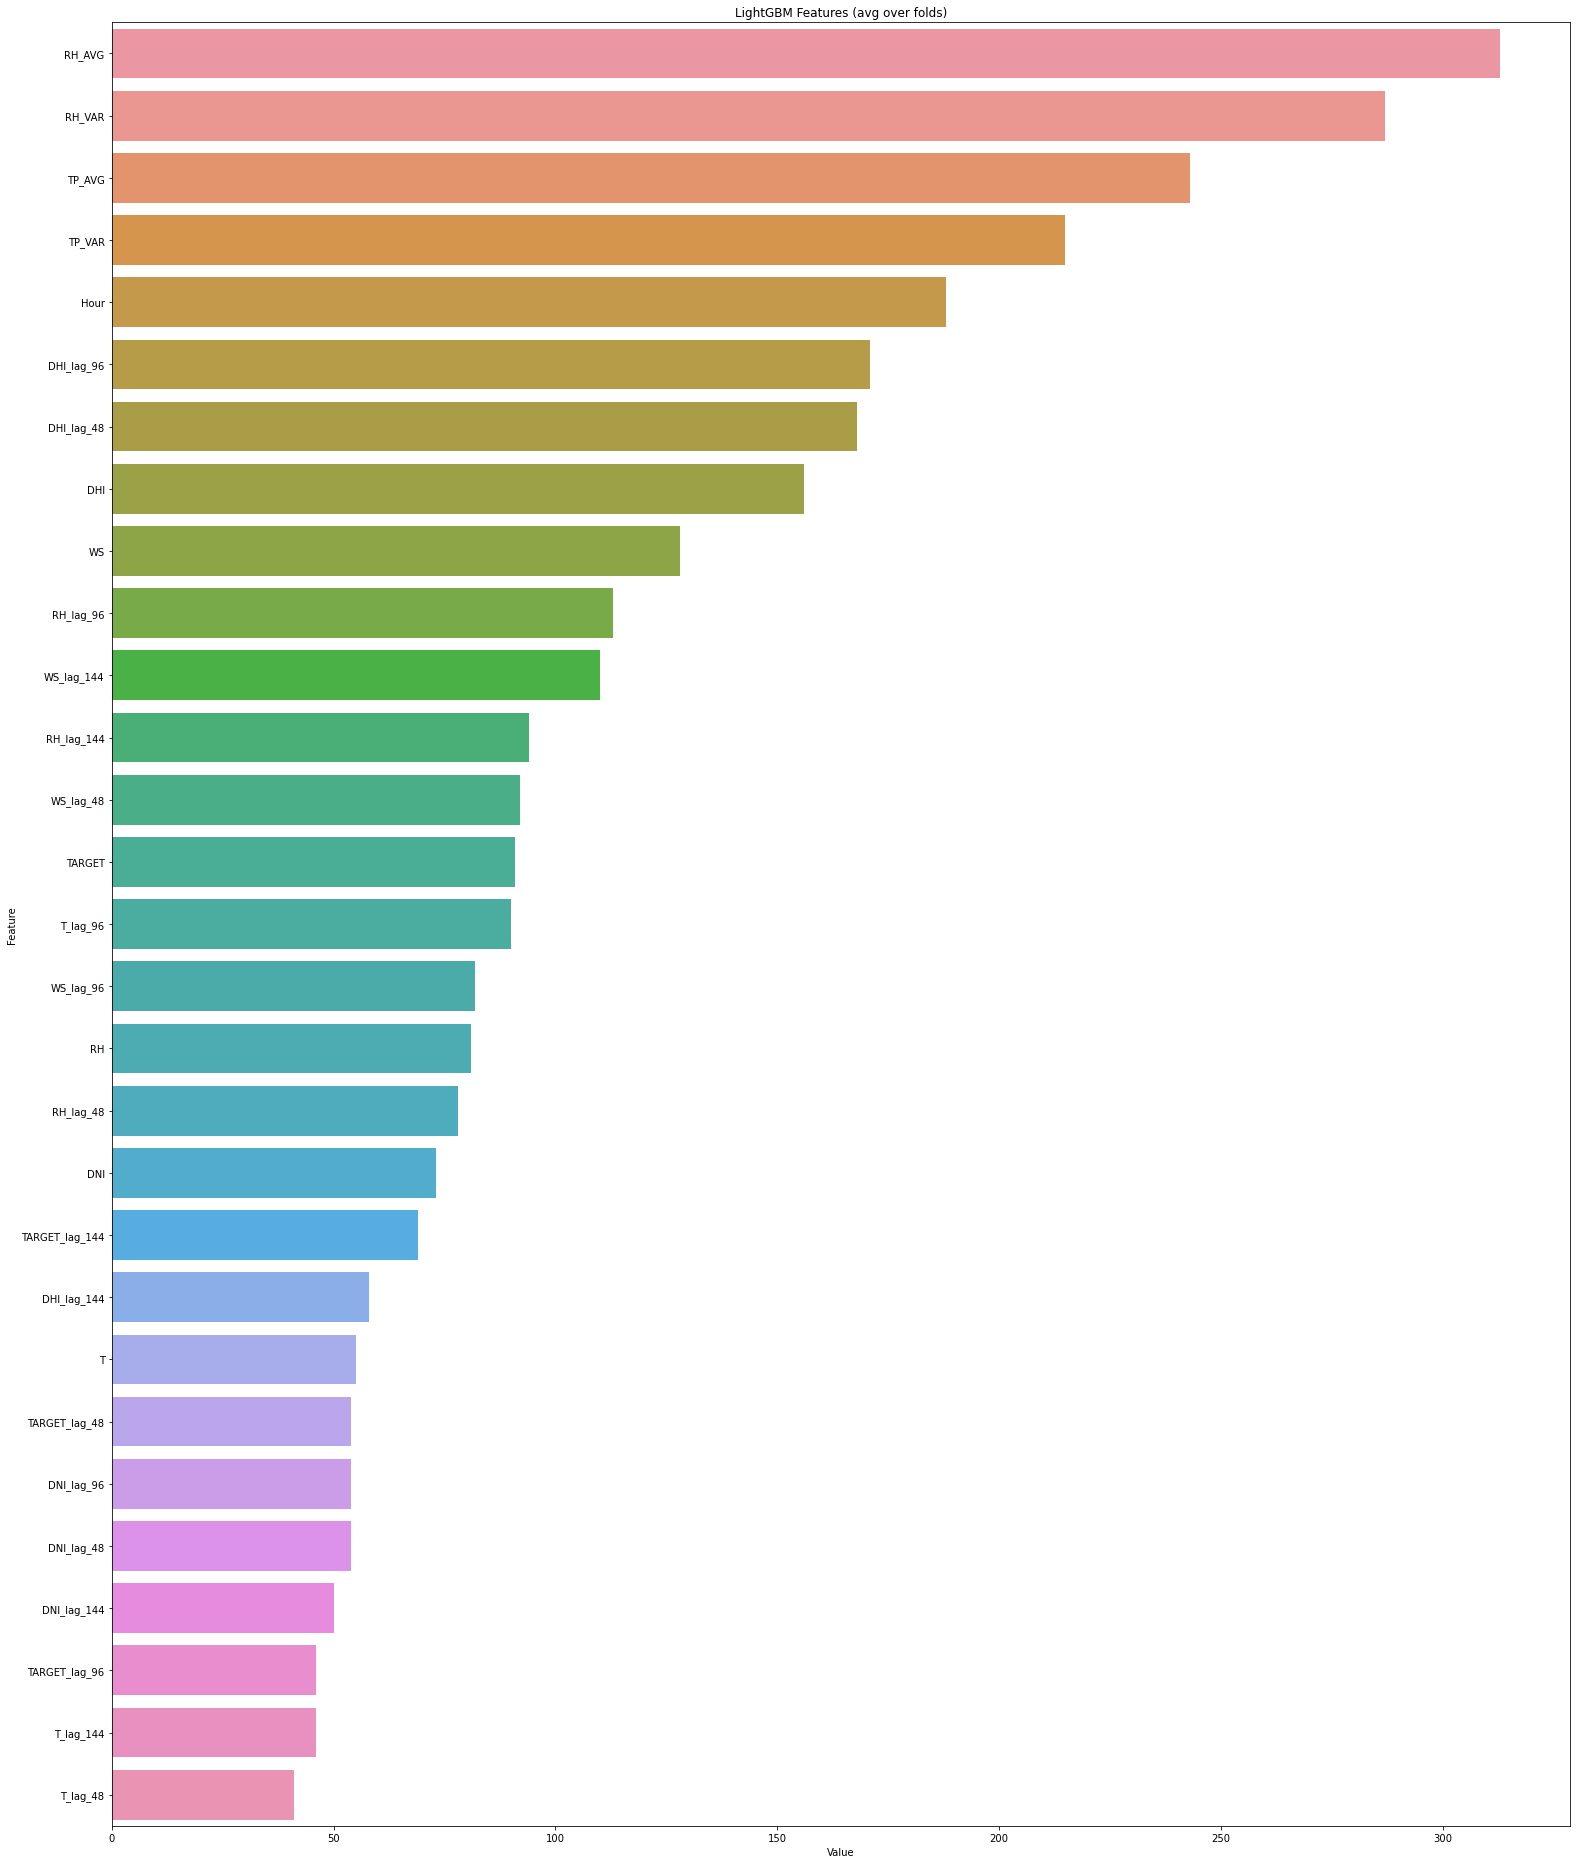

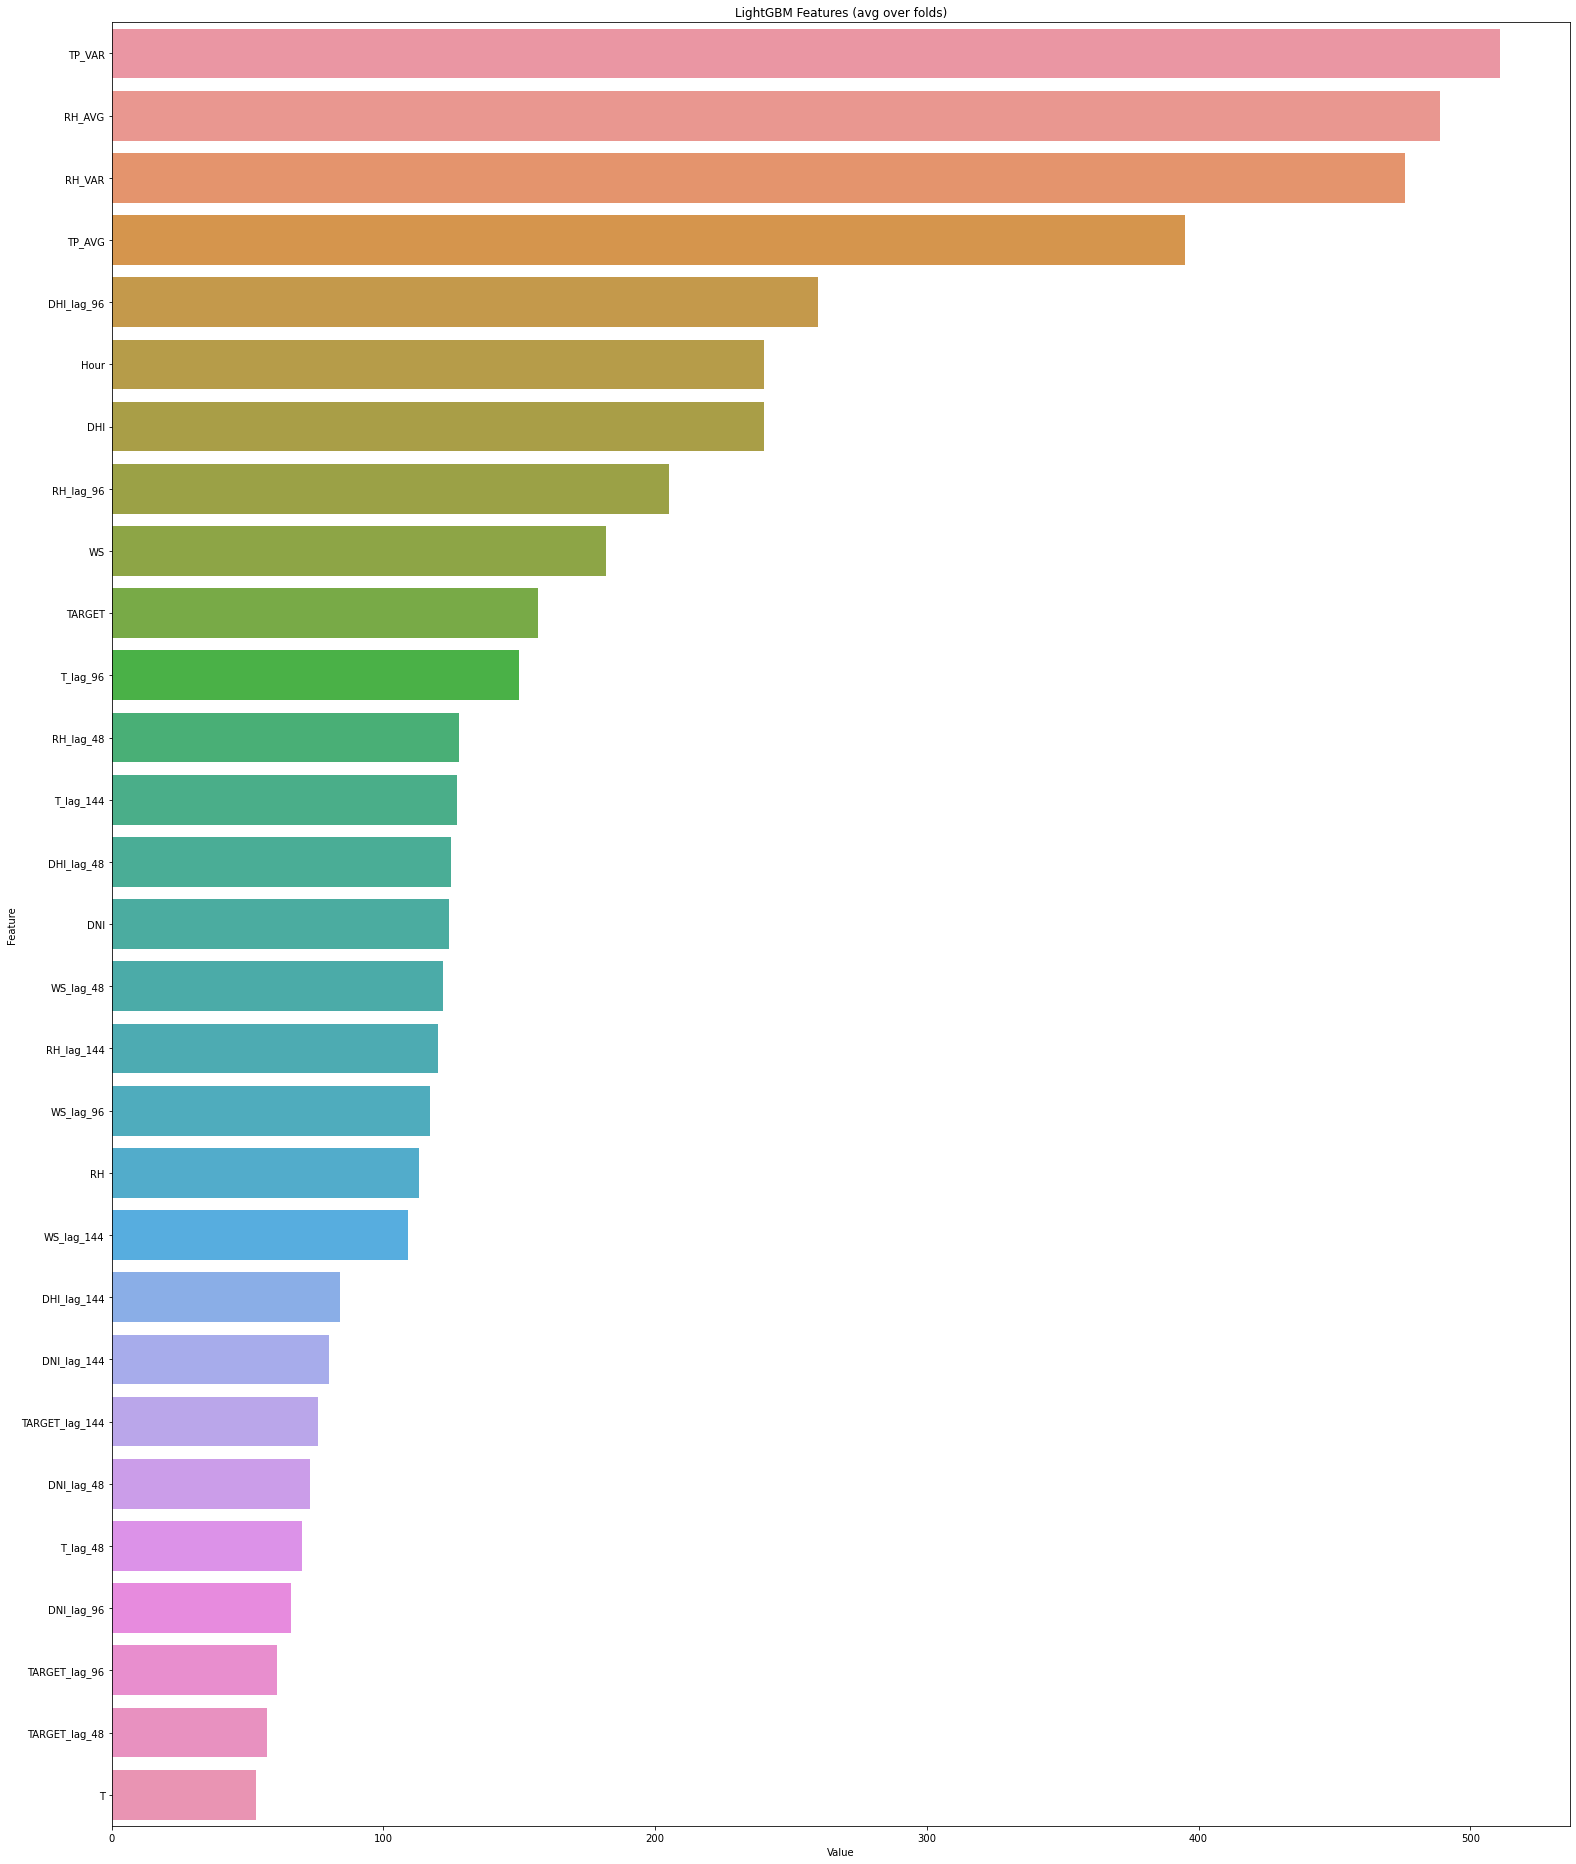

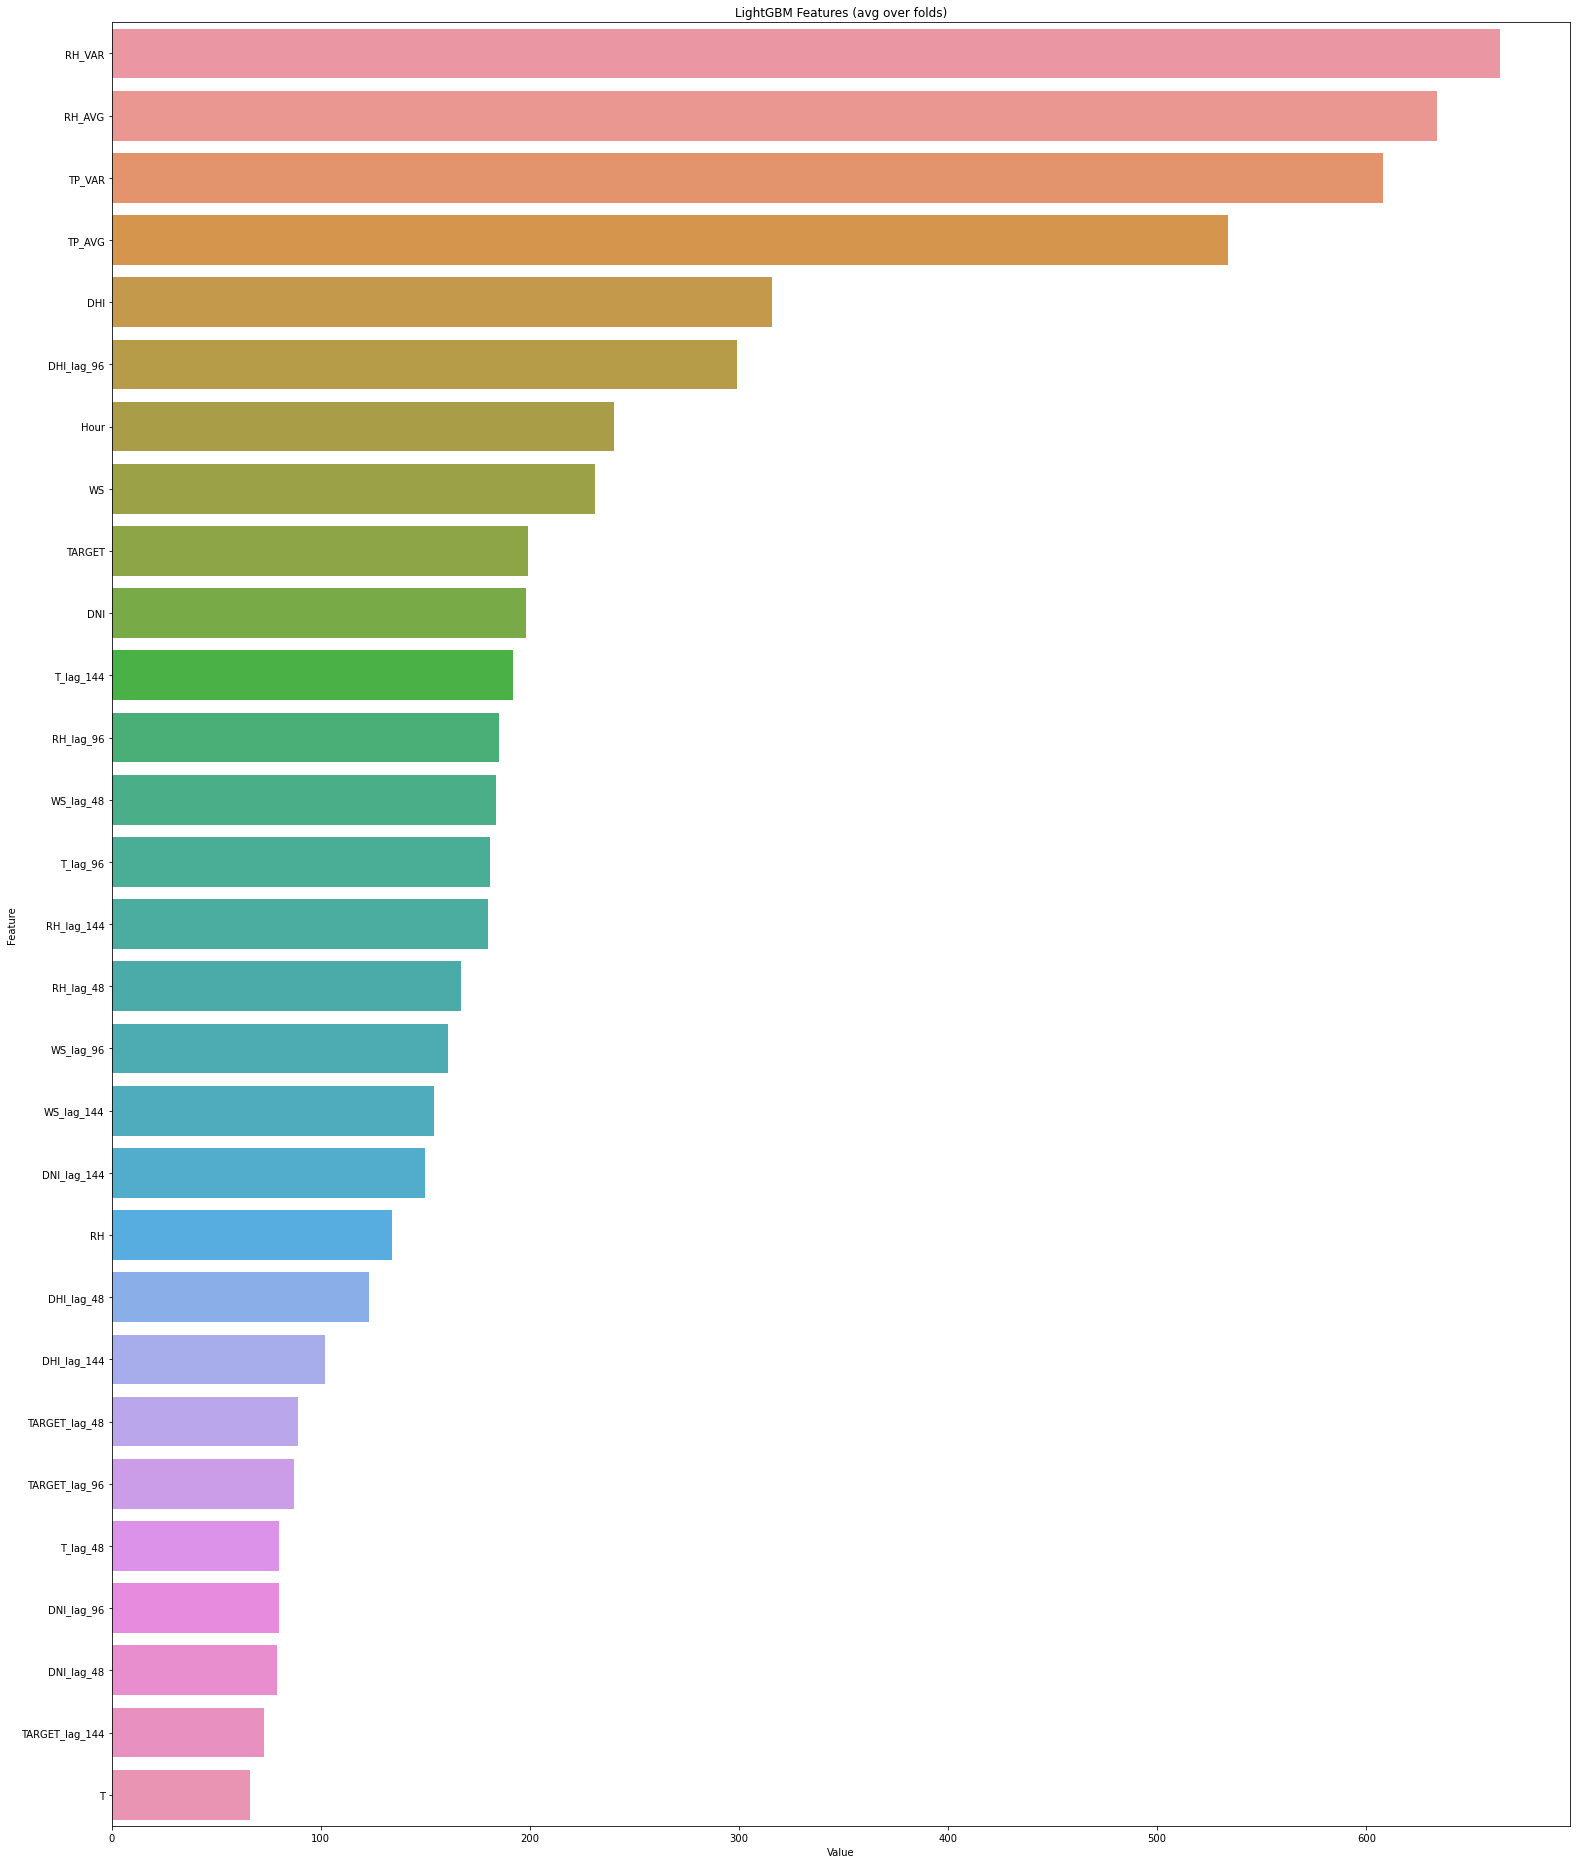

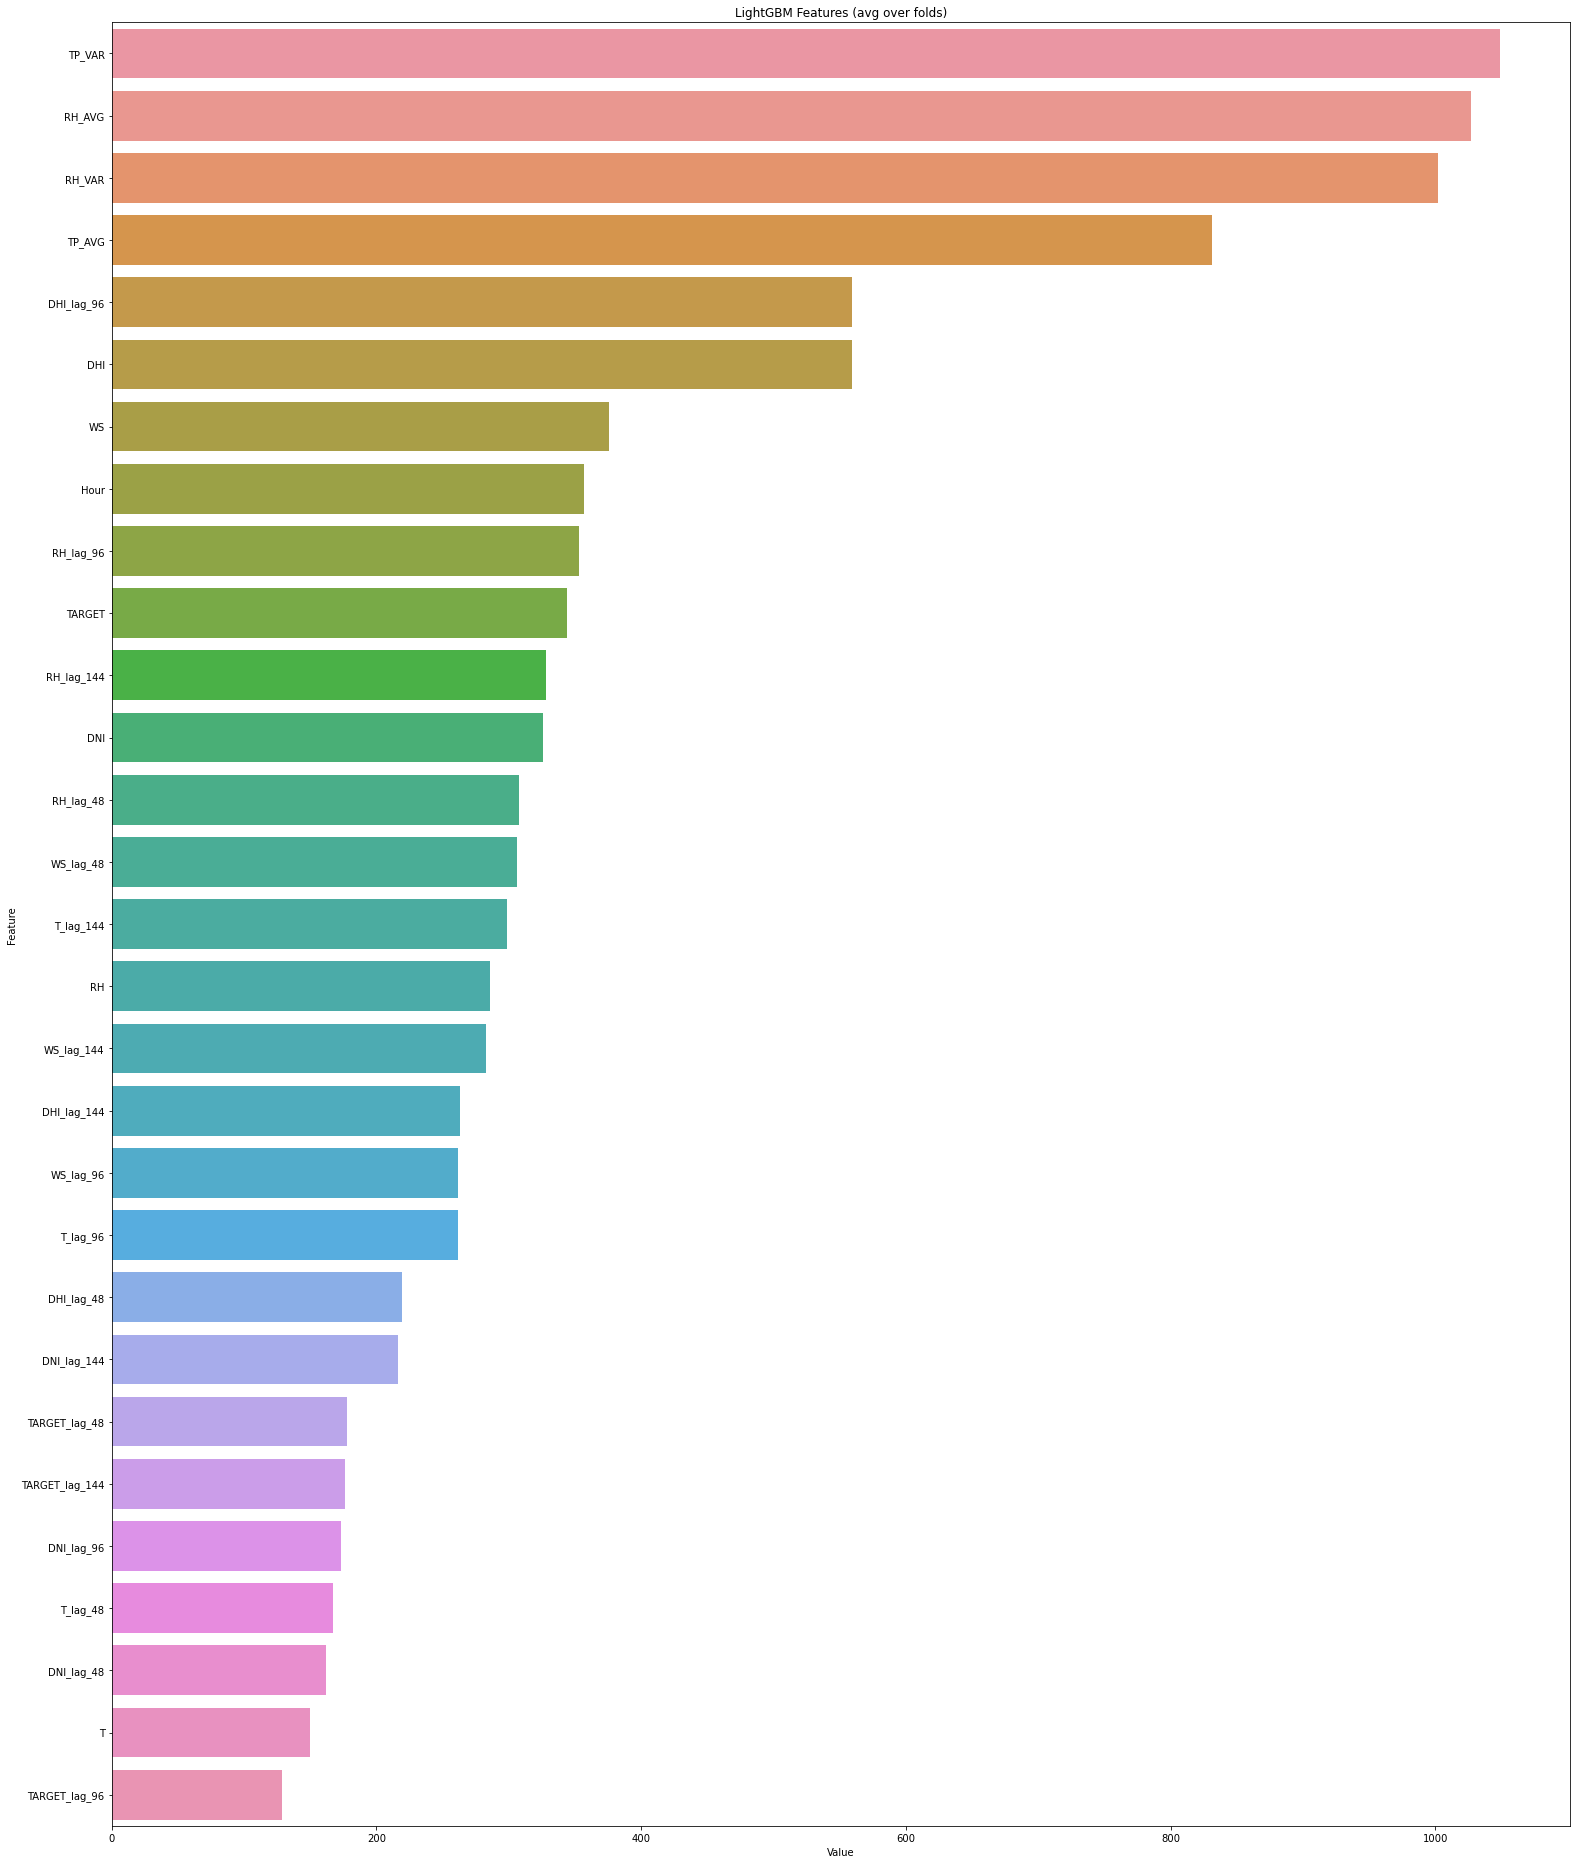

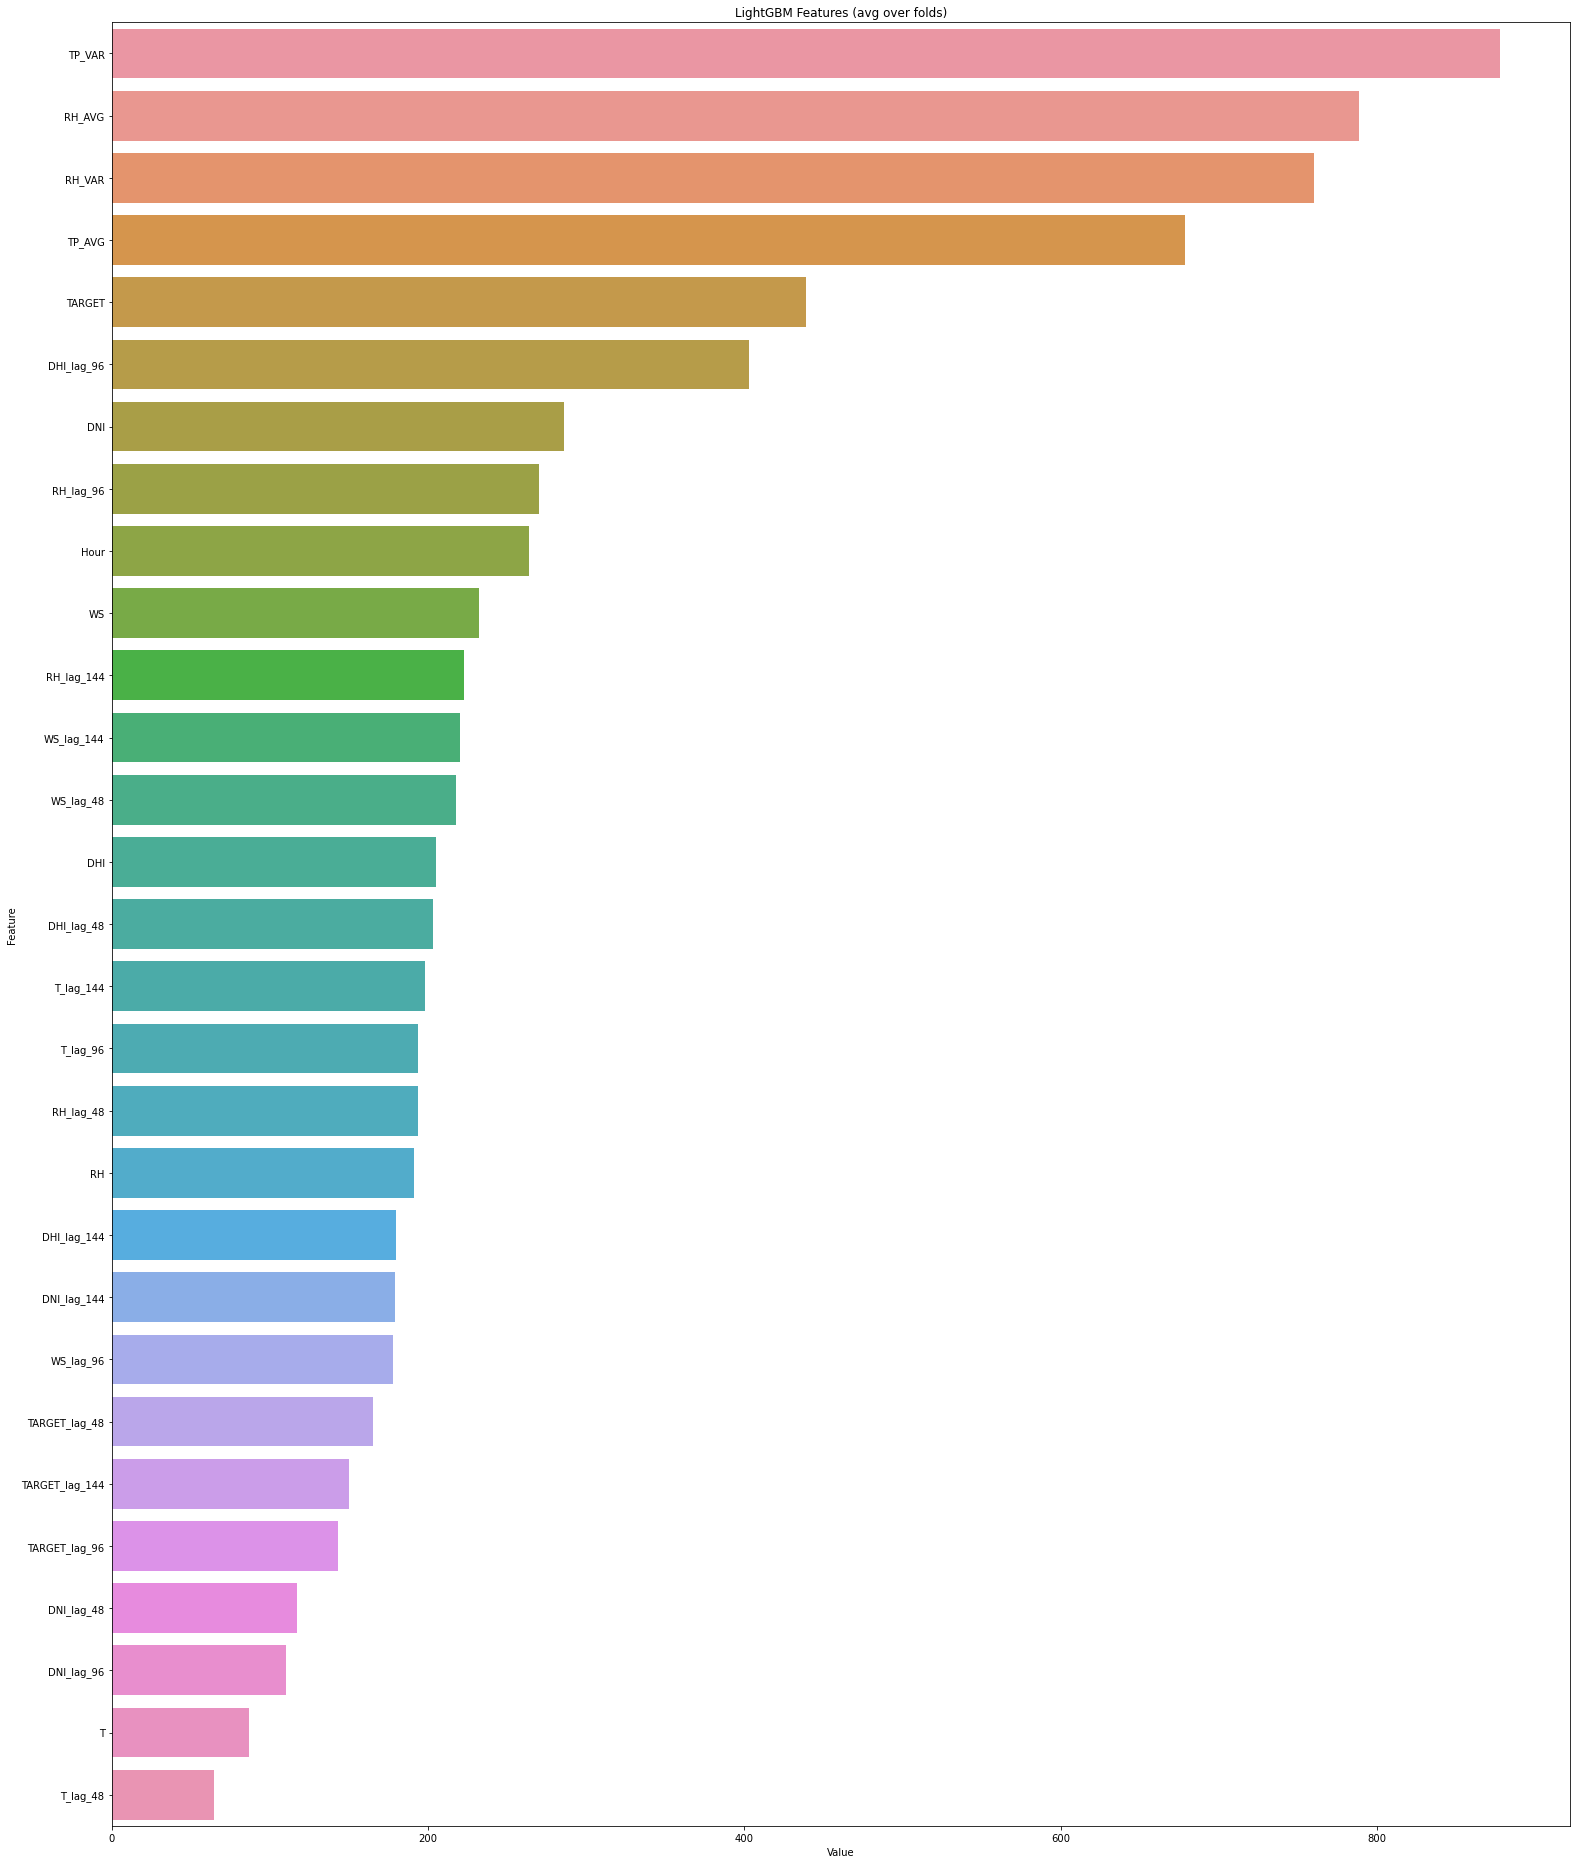

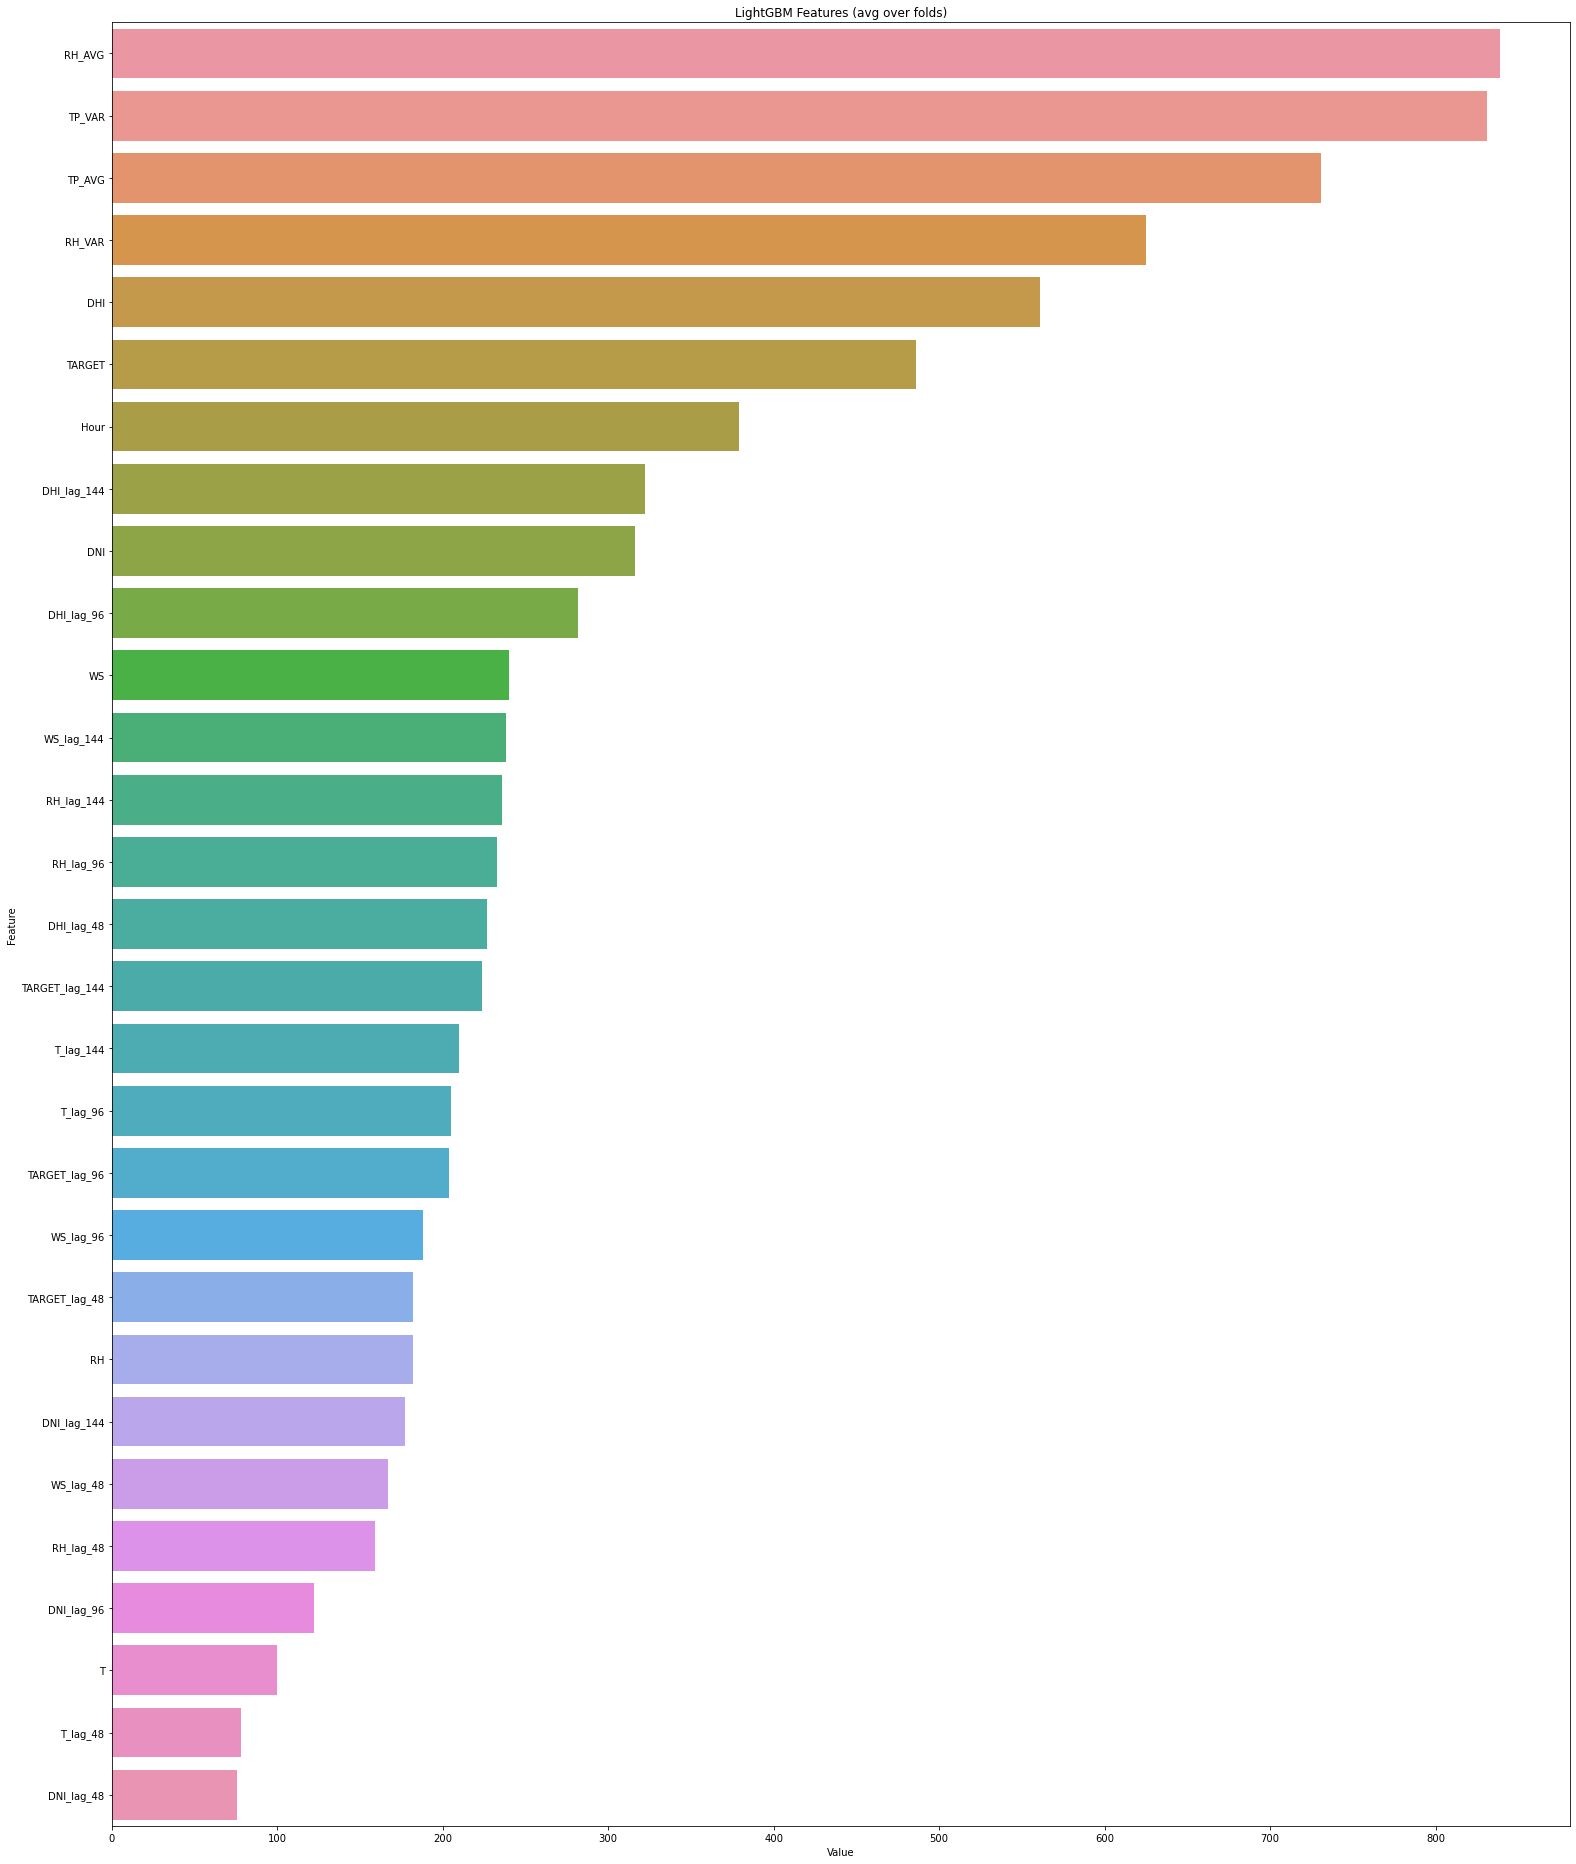

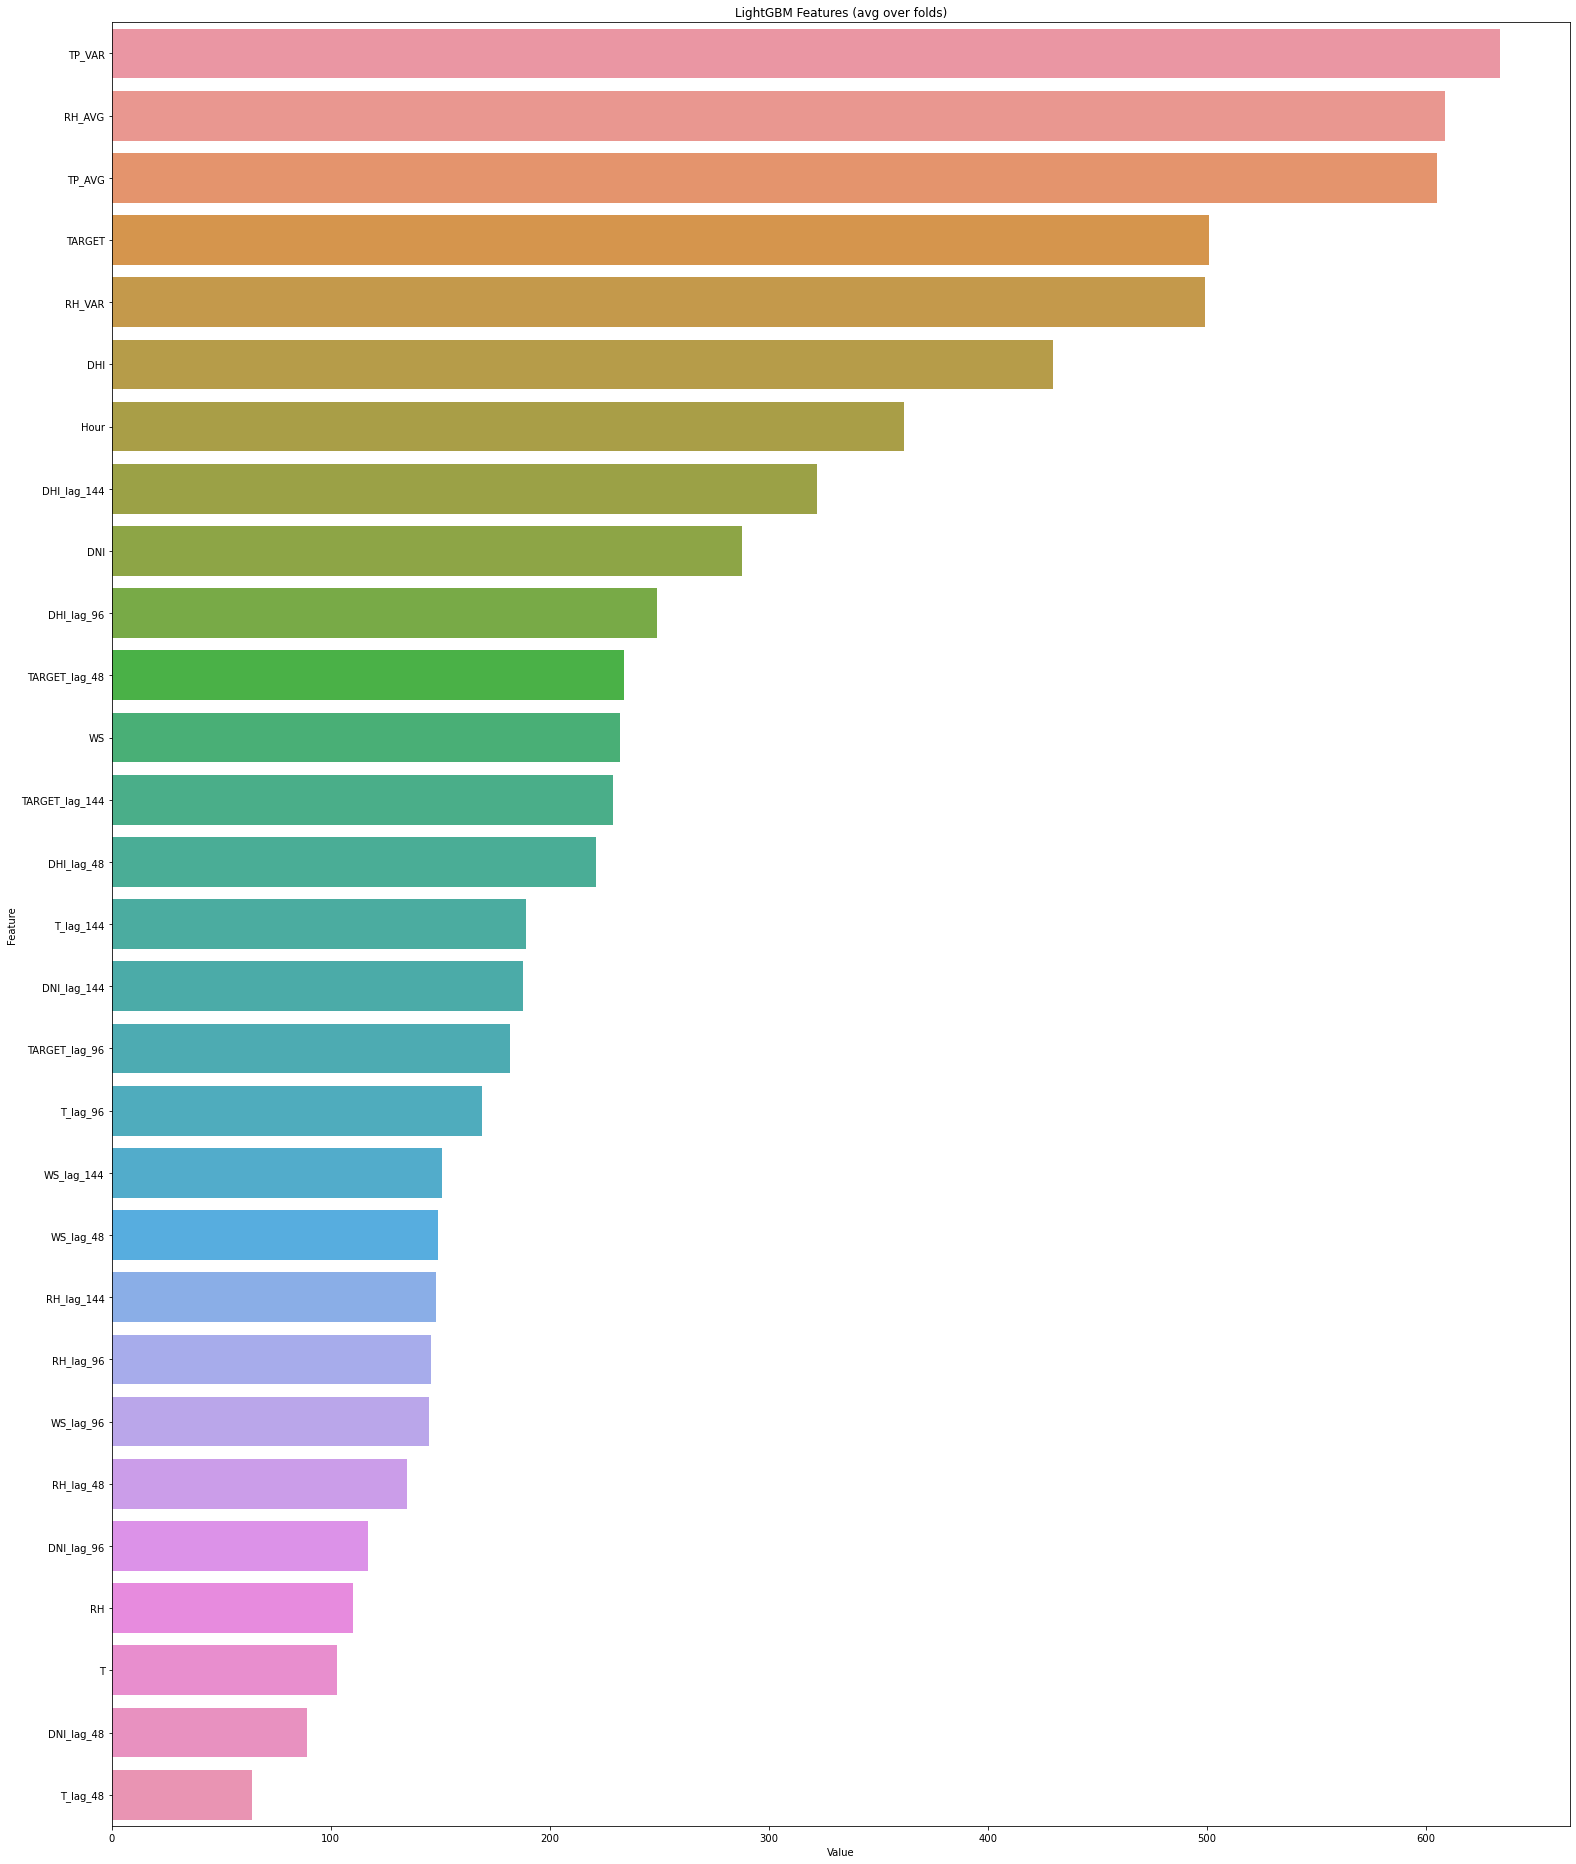

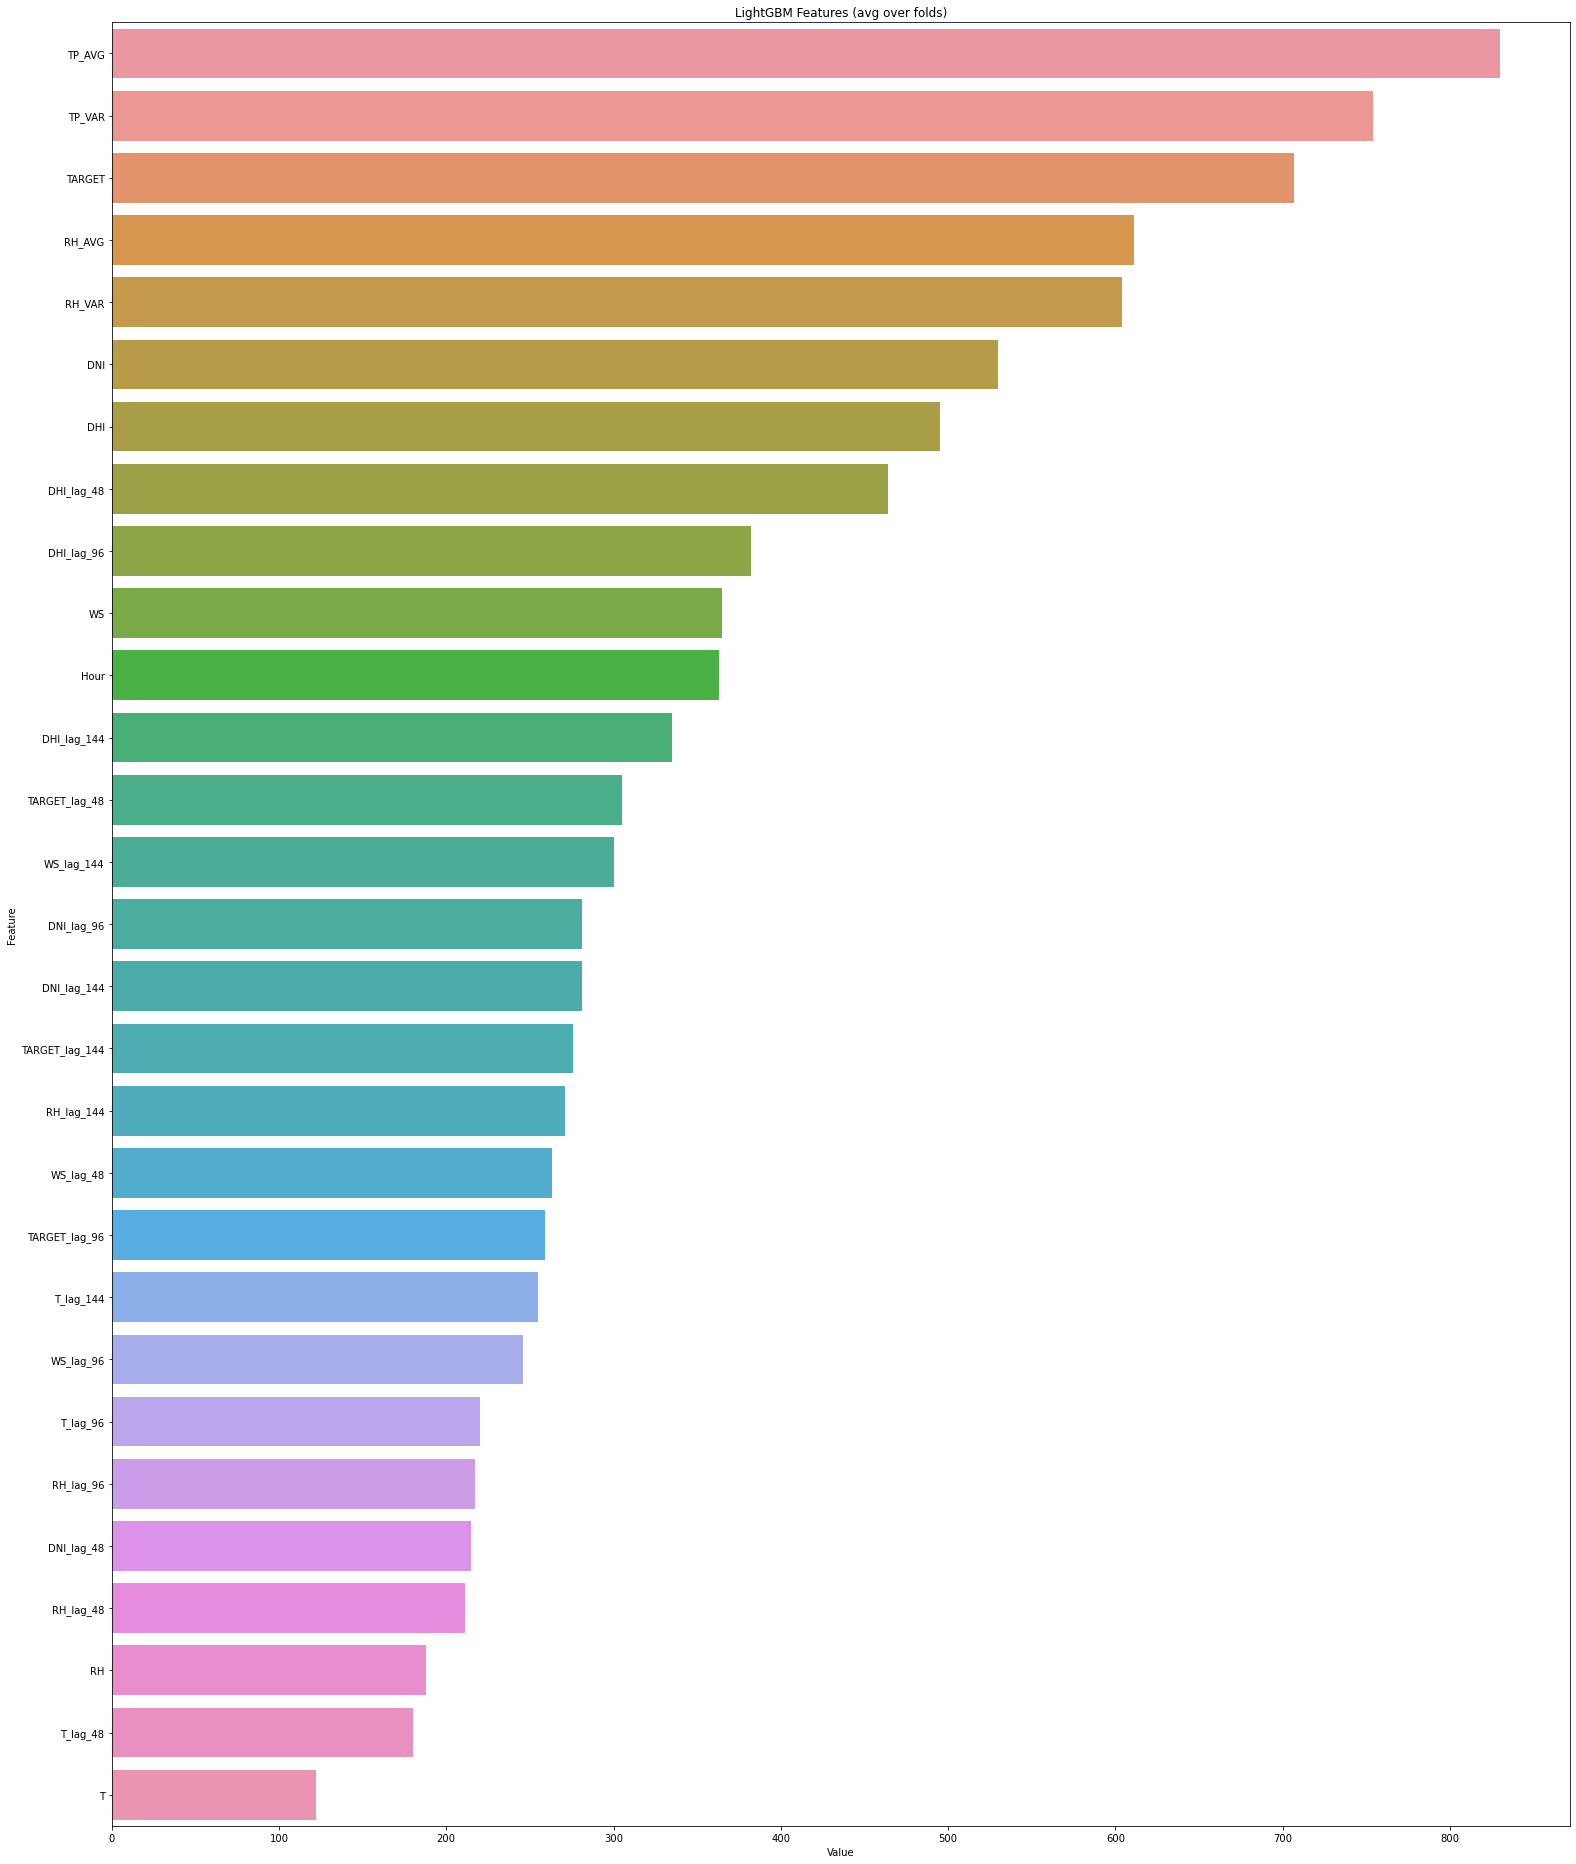

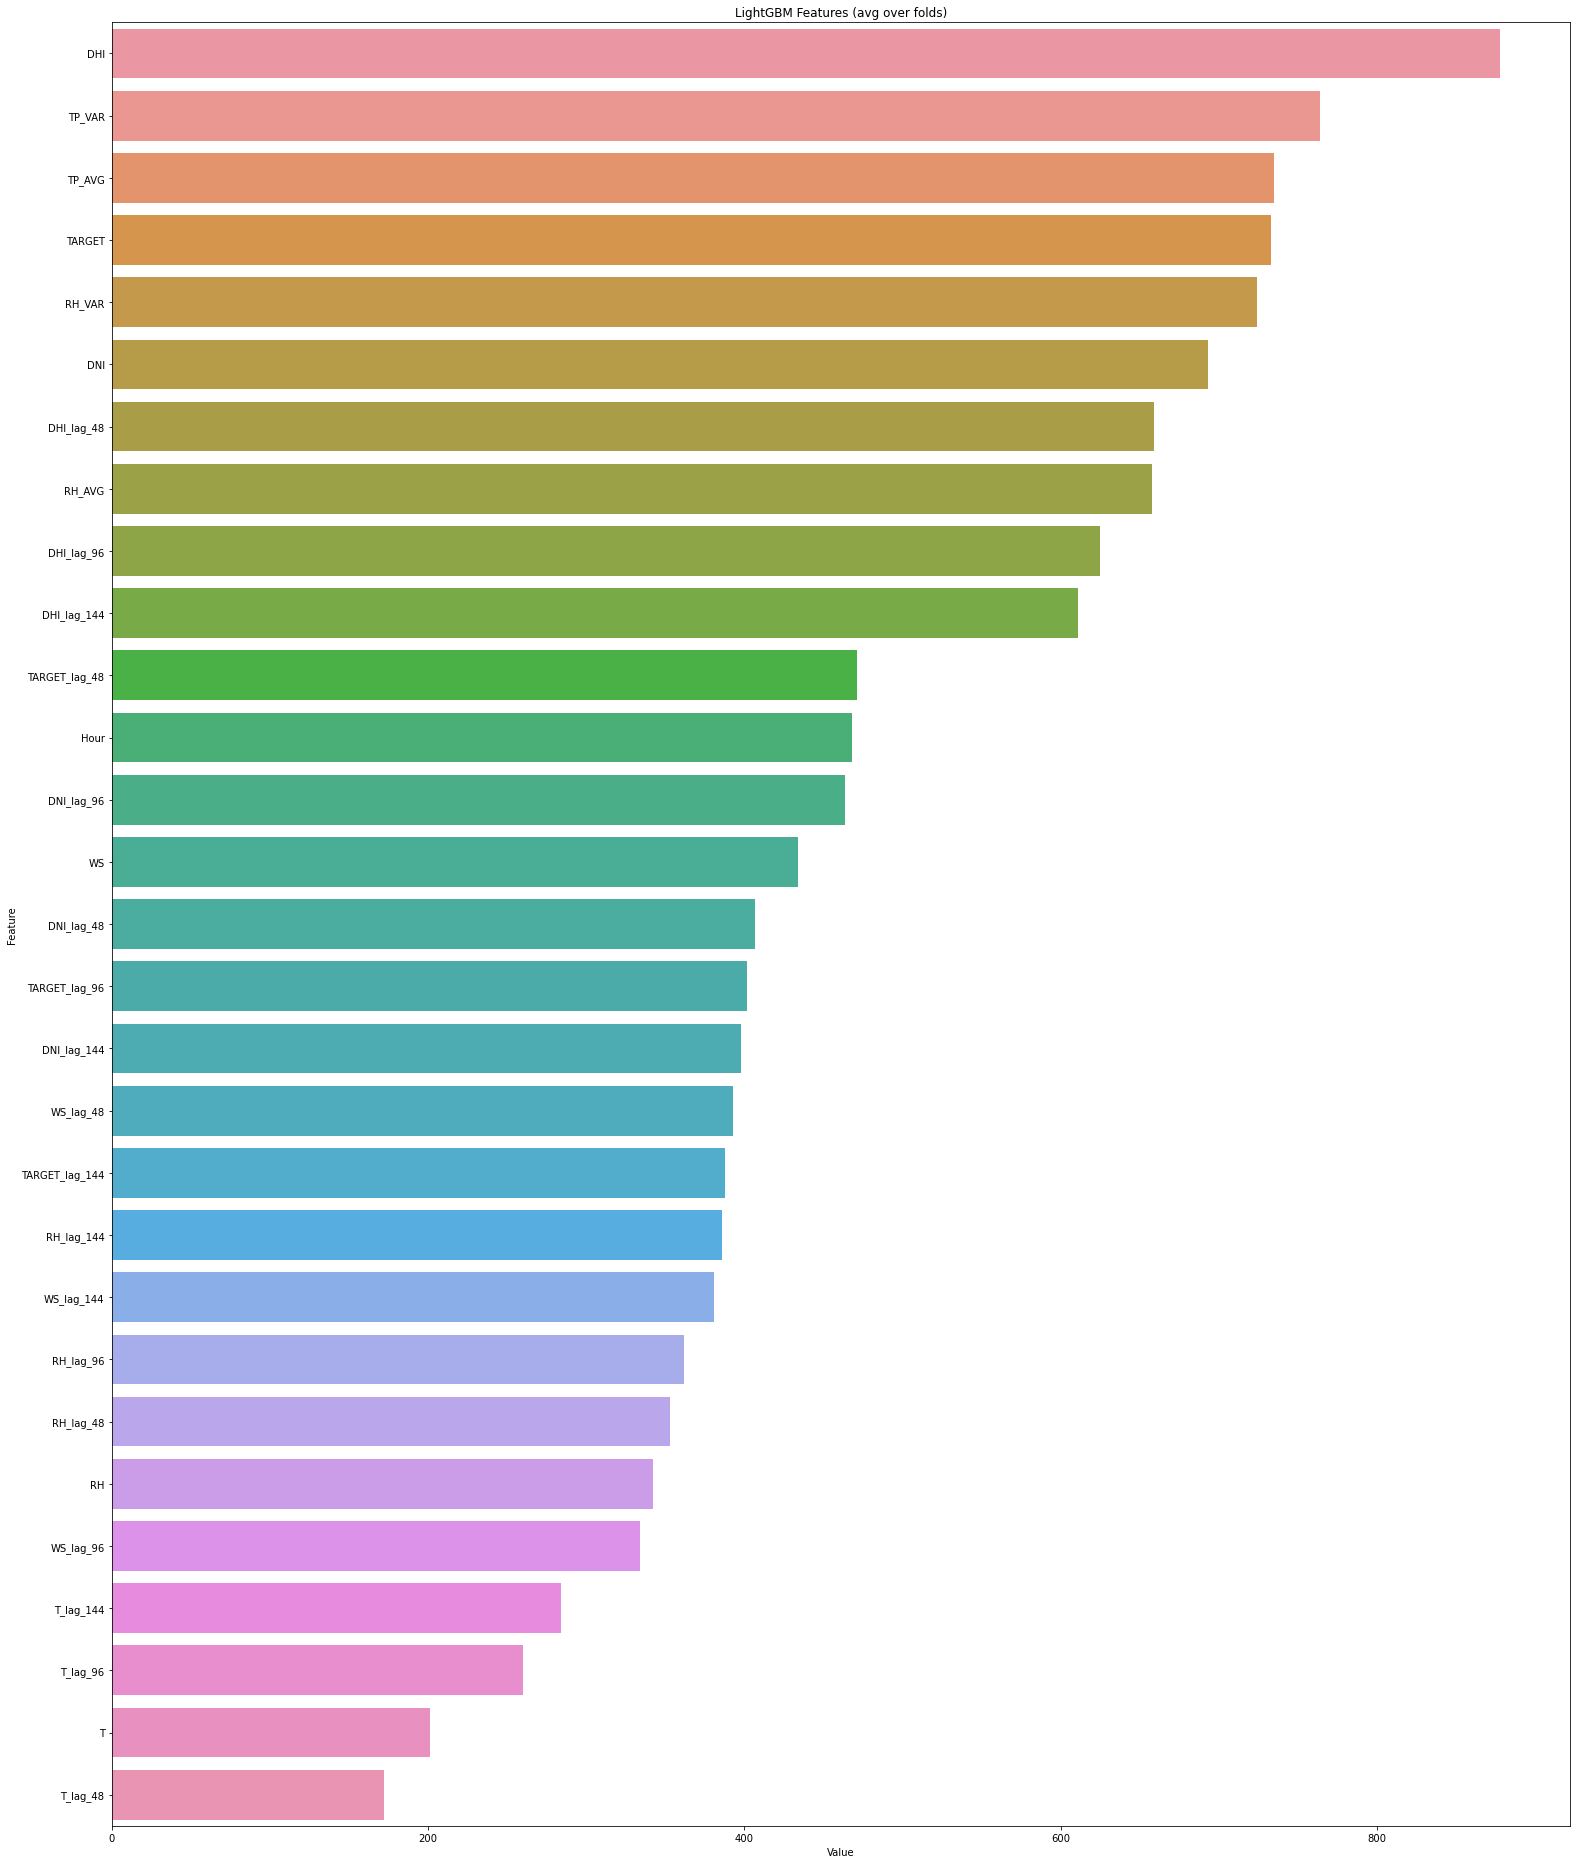

In [305]:
for i in range(len(models_1)):
    # sorted(zip(clf.feature_importances_, X.columns), reverse=True)
    feature_imp = pd.DataFrame(sorted(zip(models_1[i].feature_importances_,x_train.columns)),
                               columns=['Value','Feature'])

    plt.figure(figsize=(22, 26))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

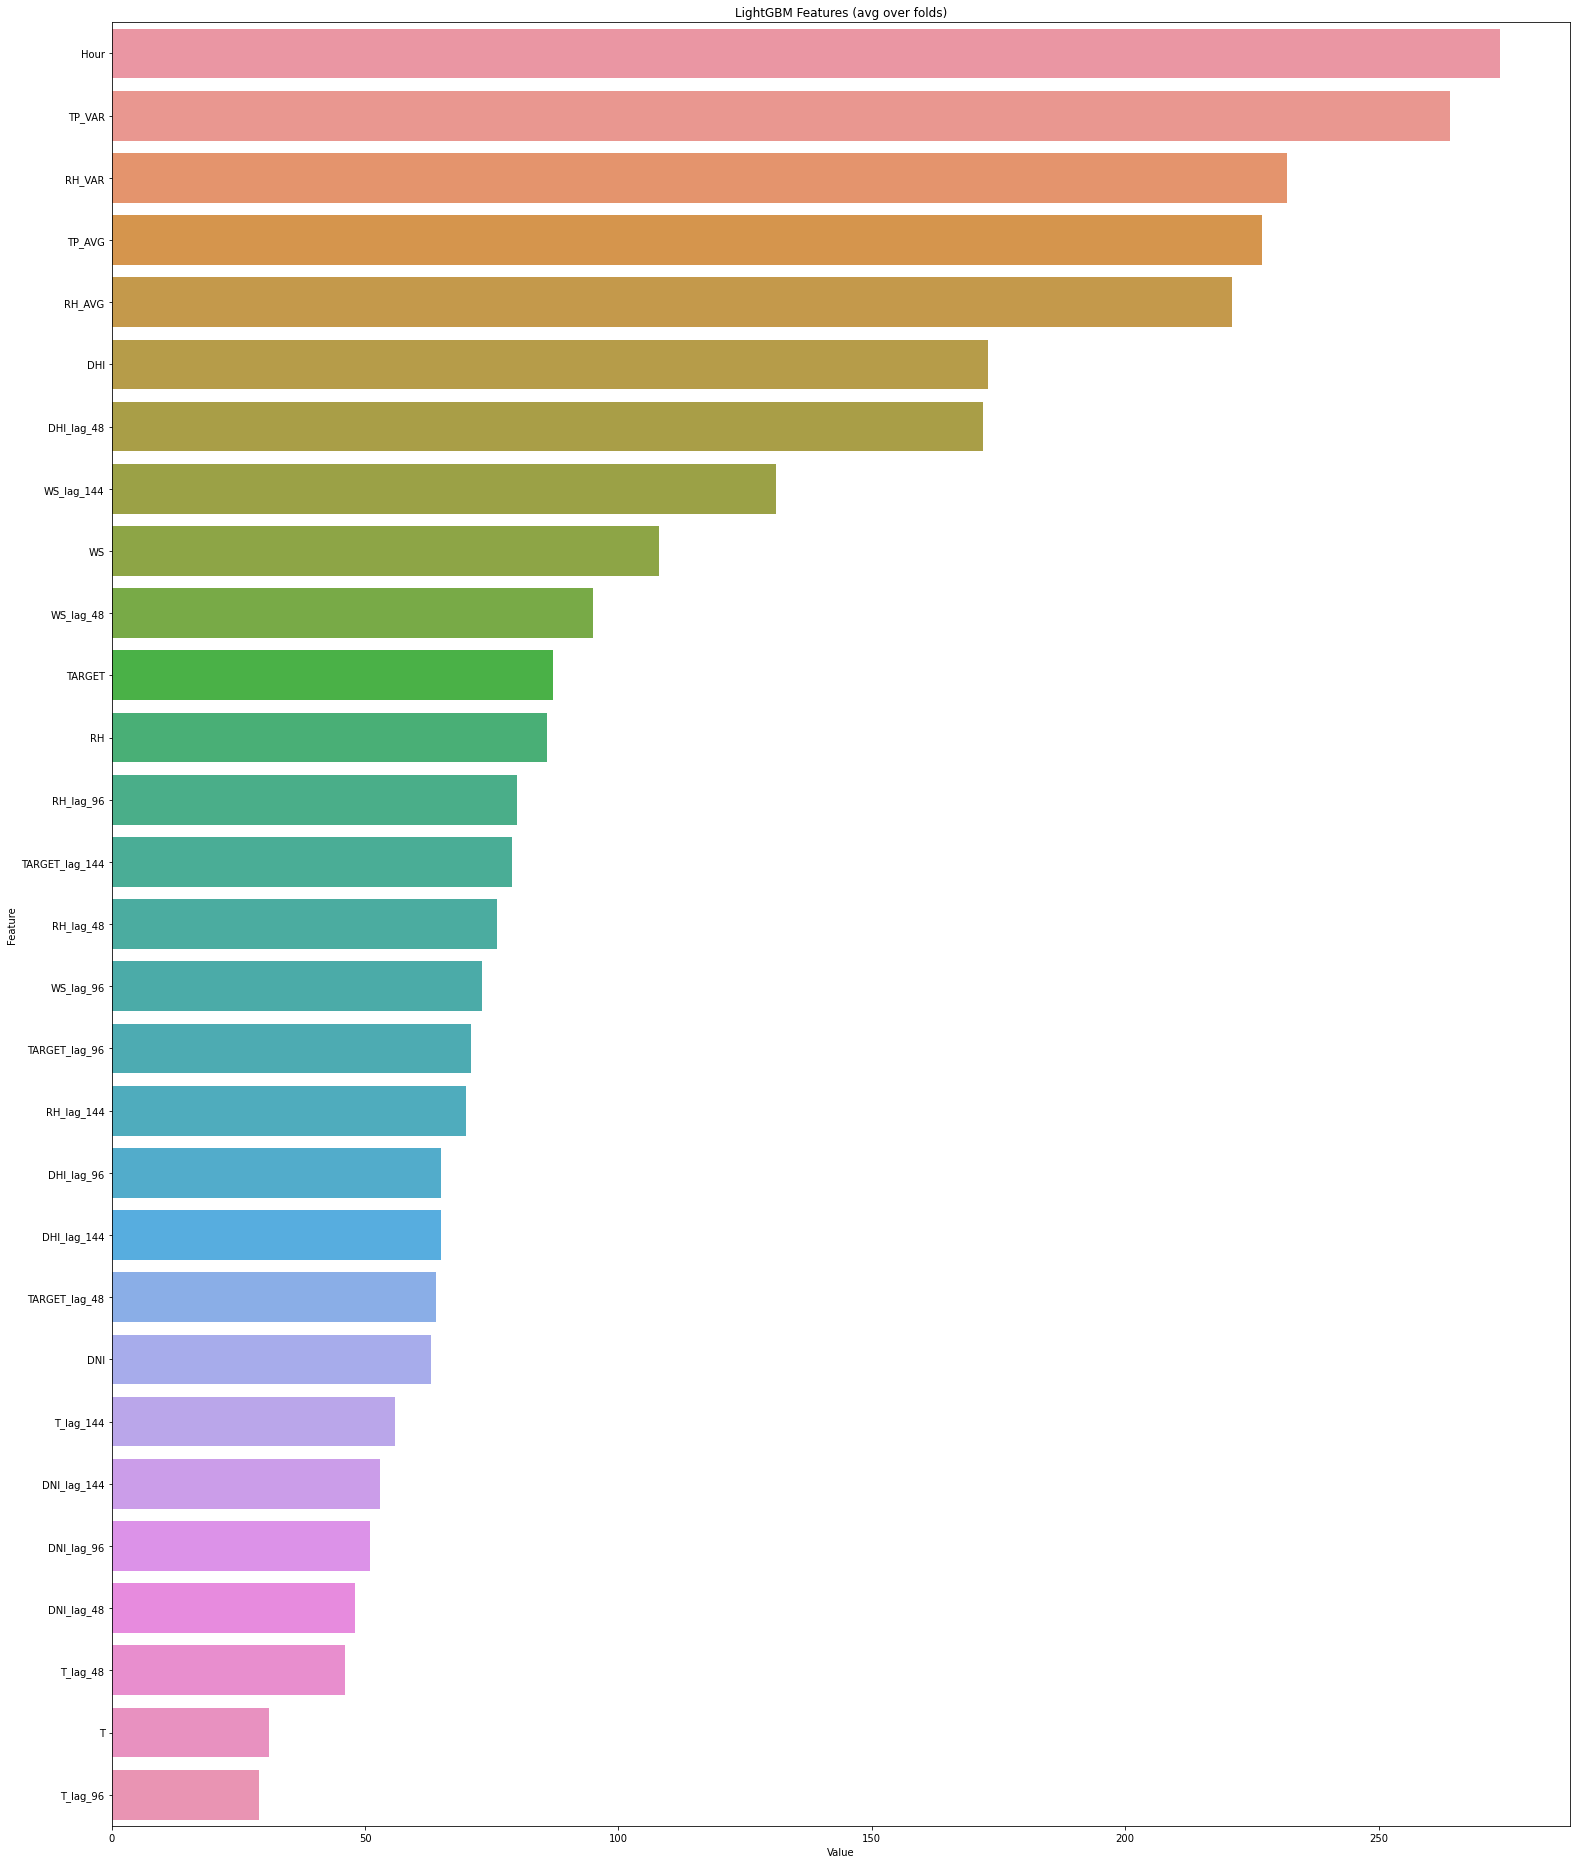

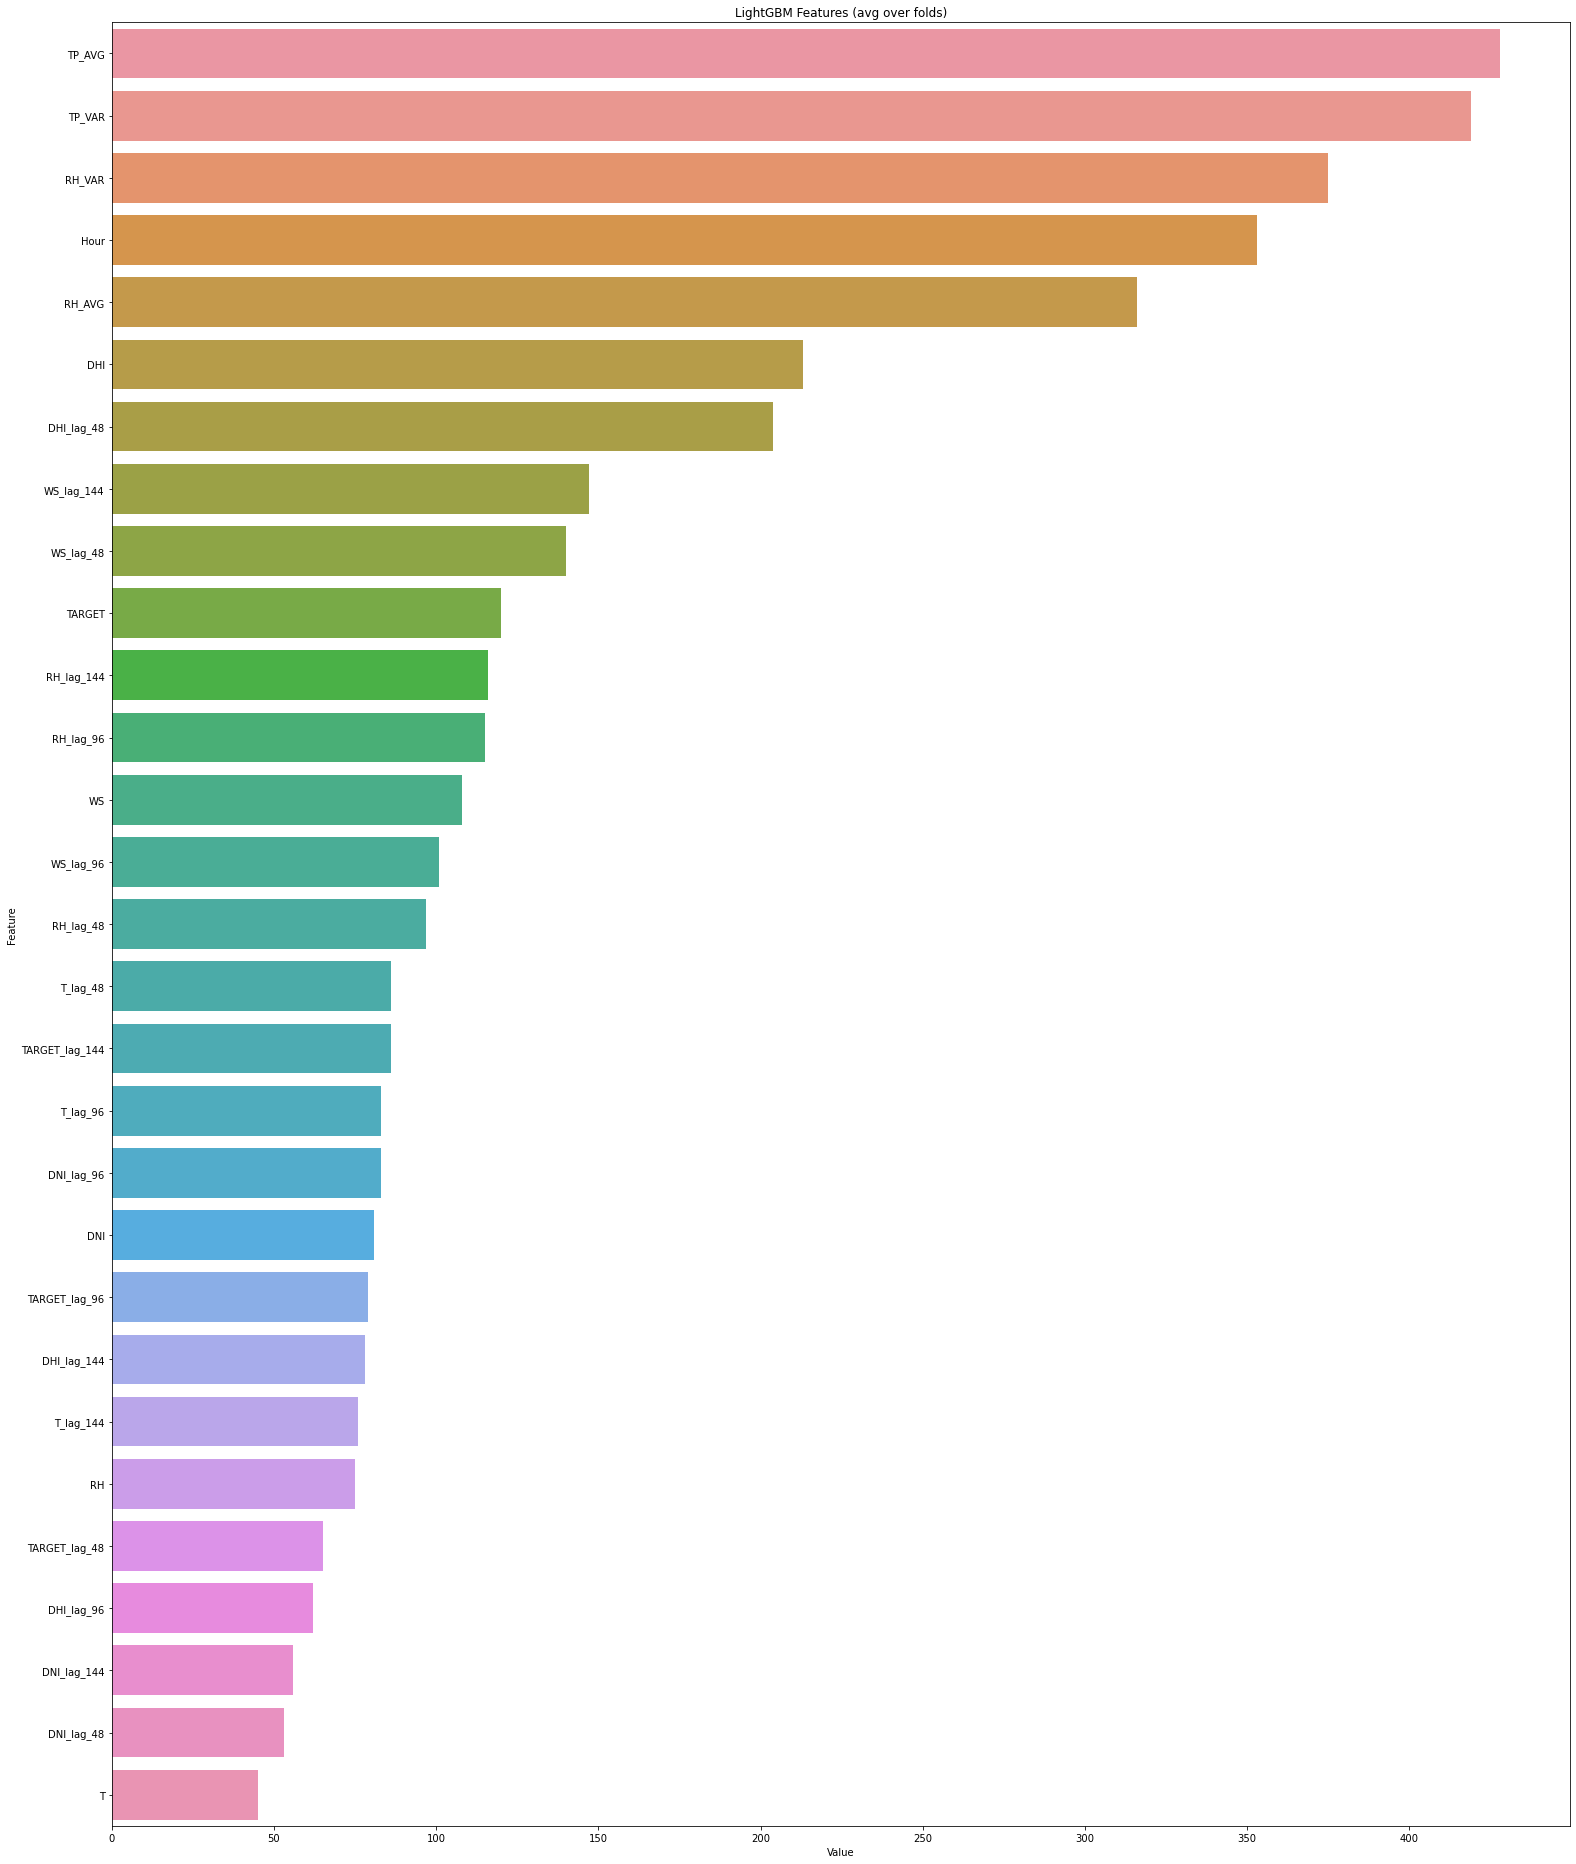

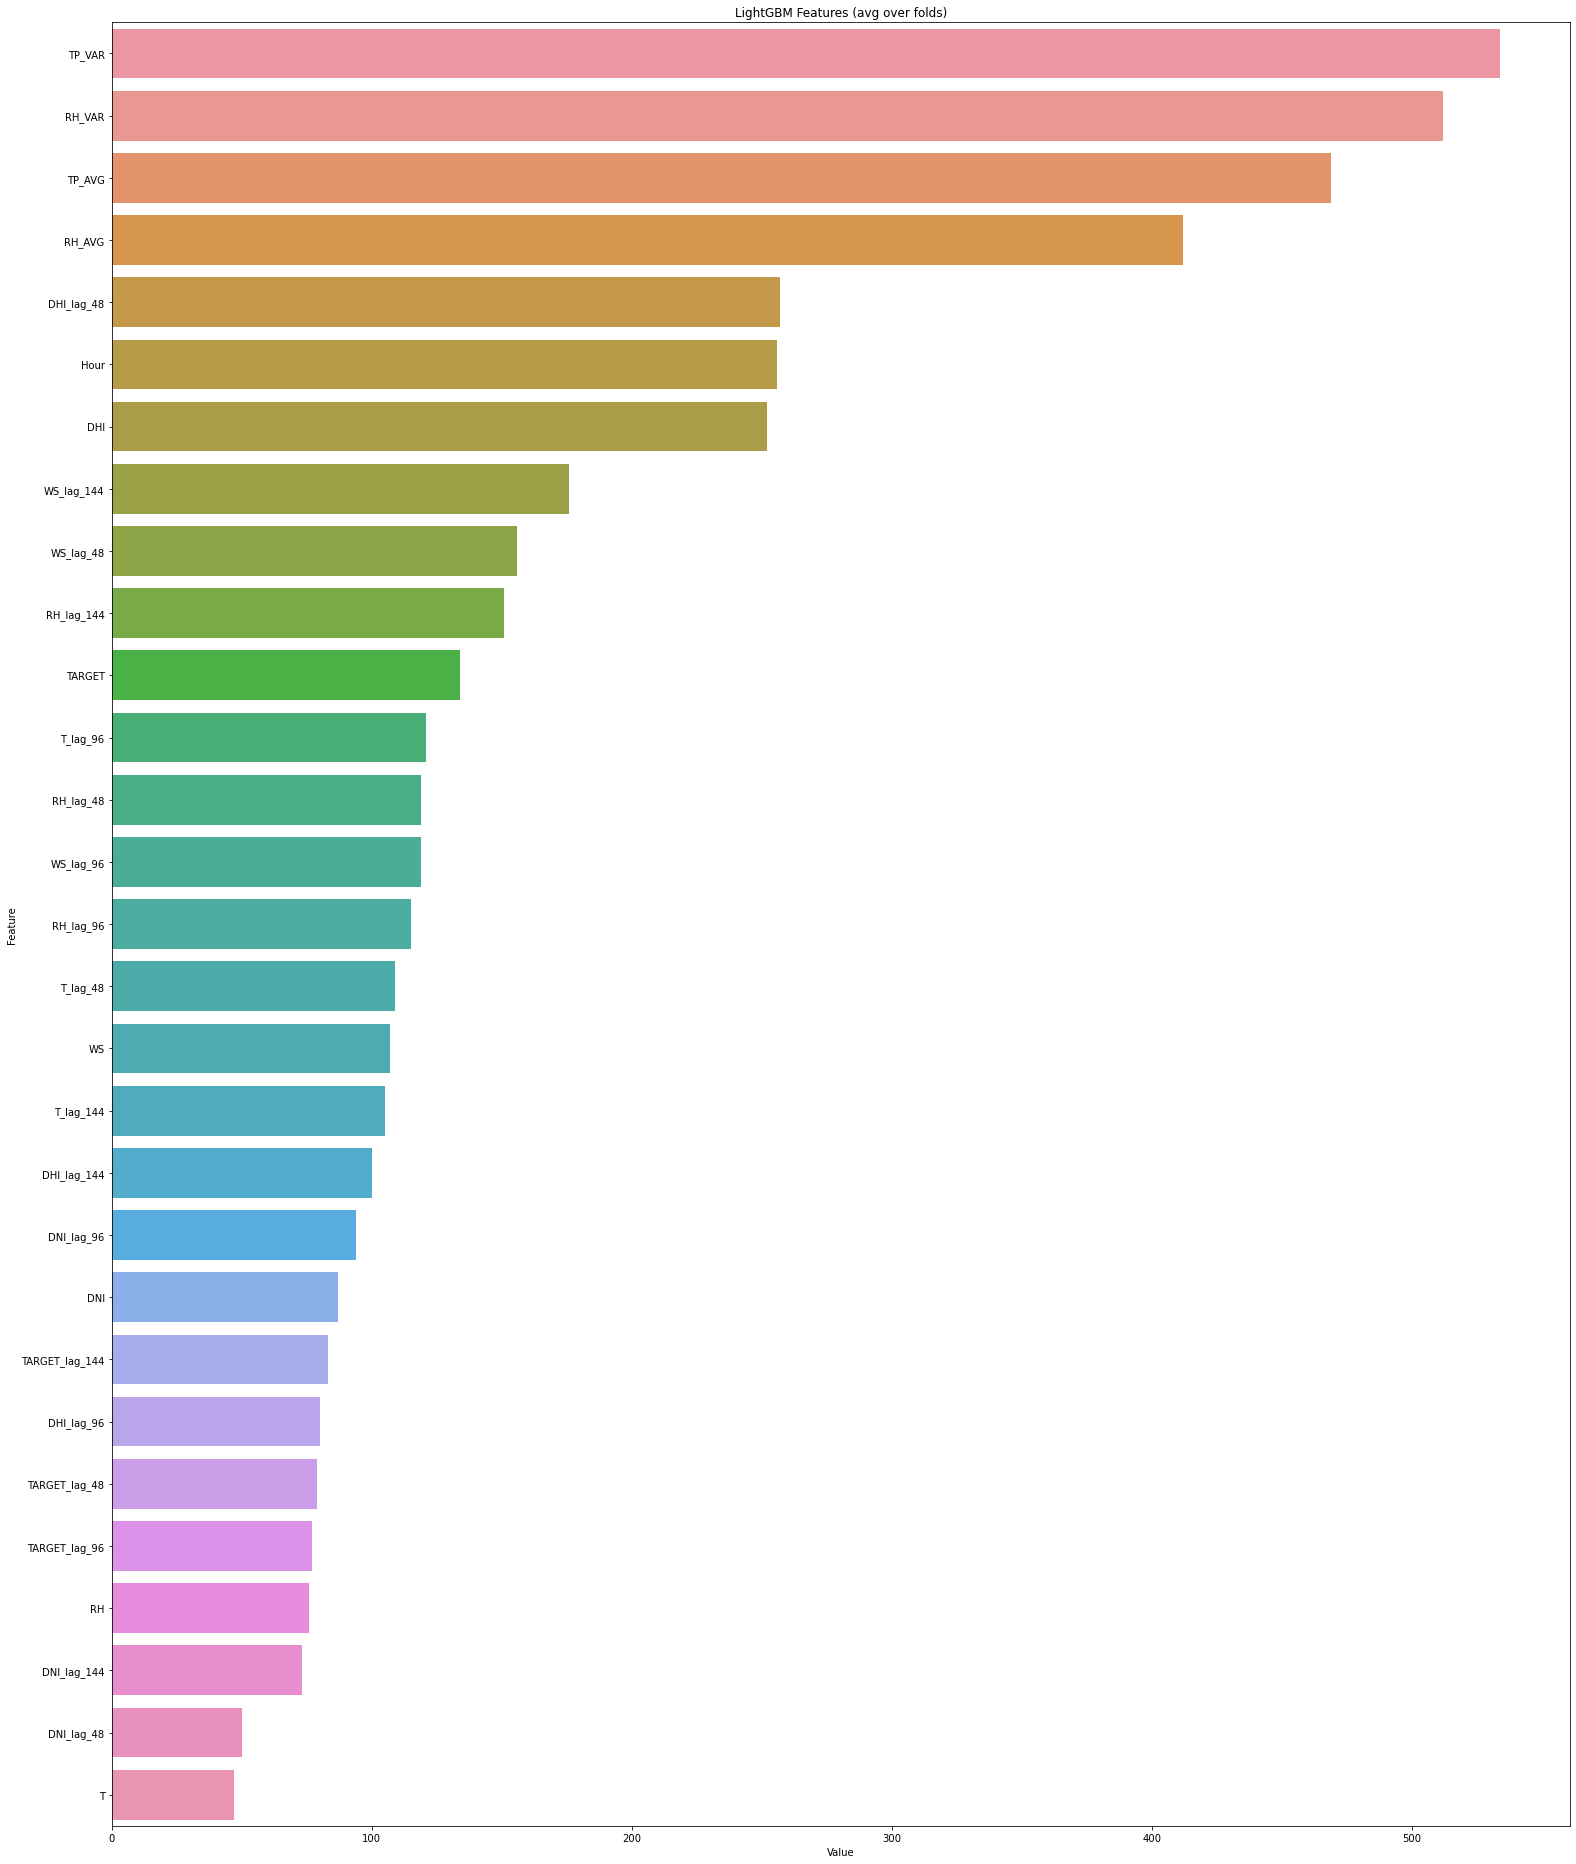

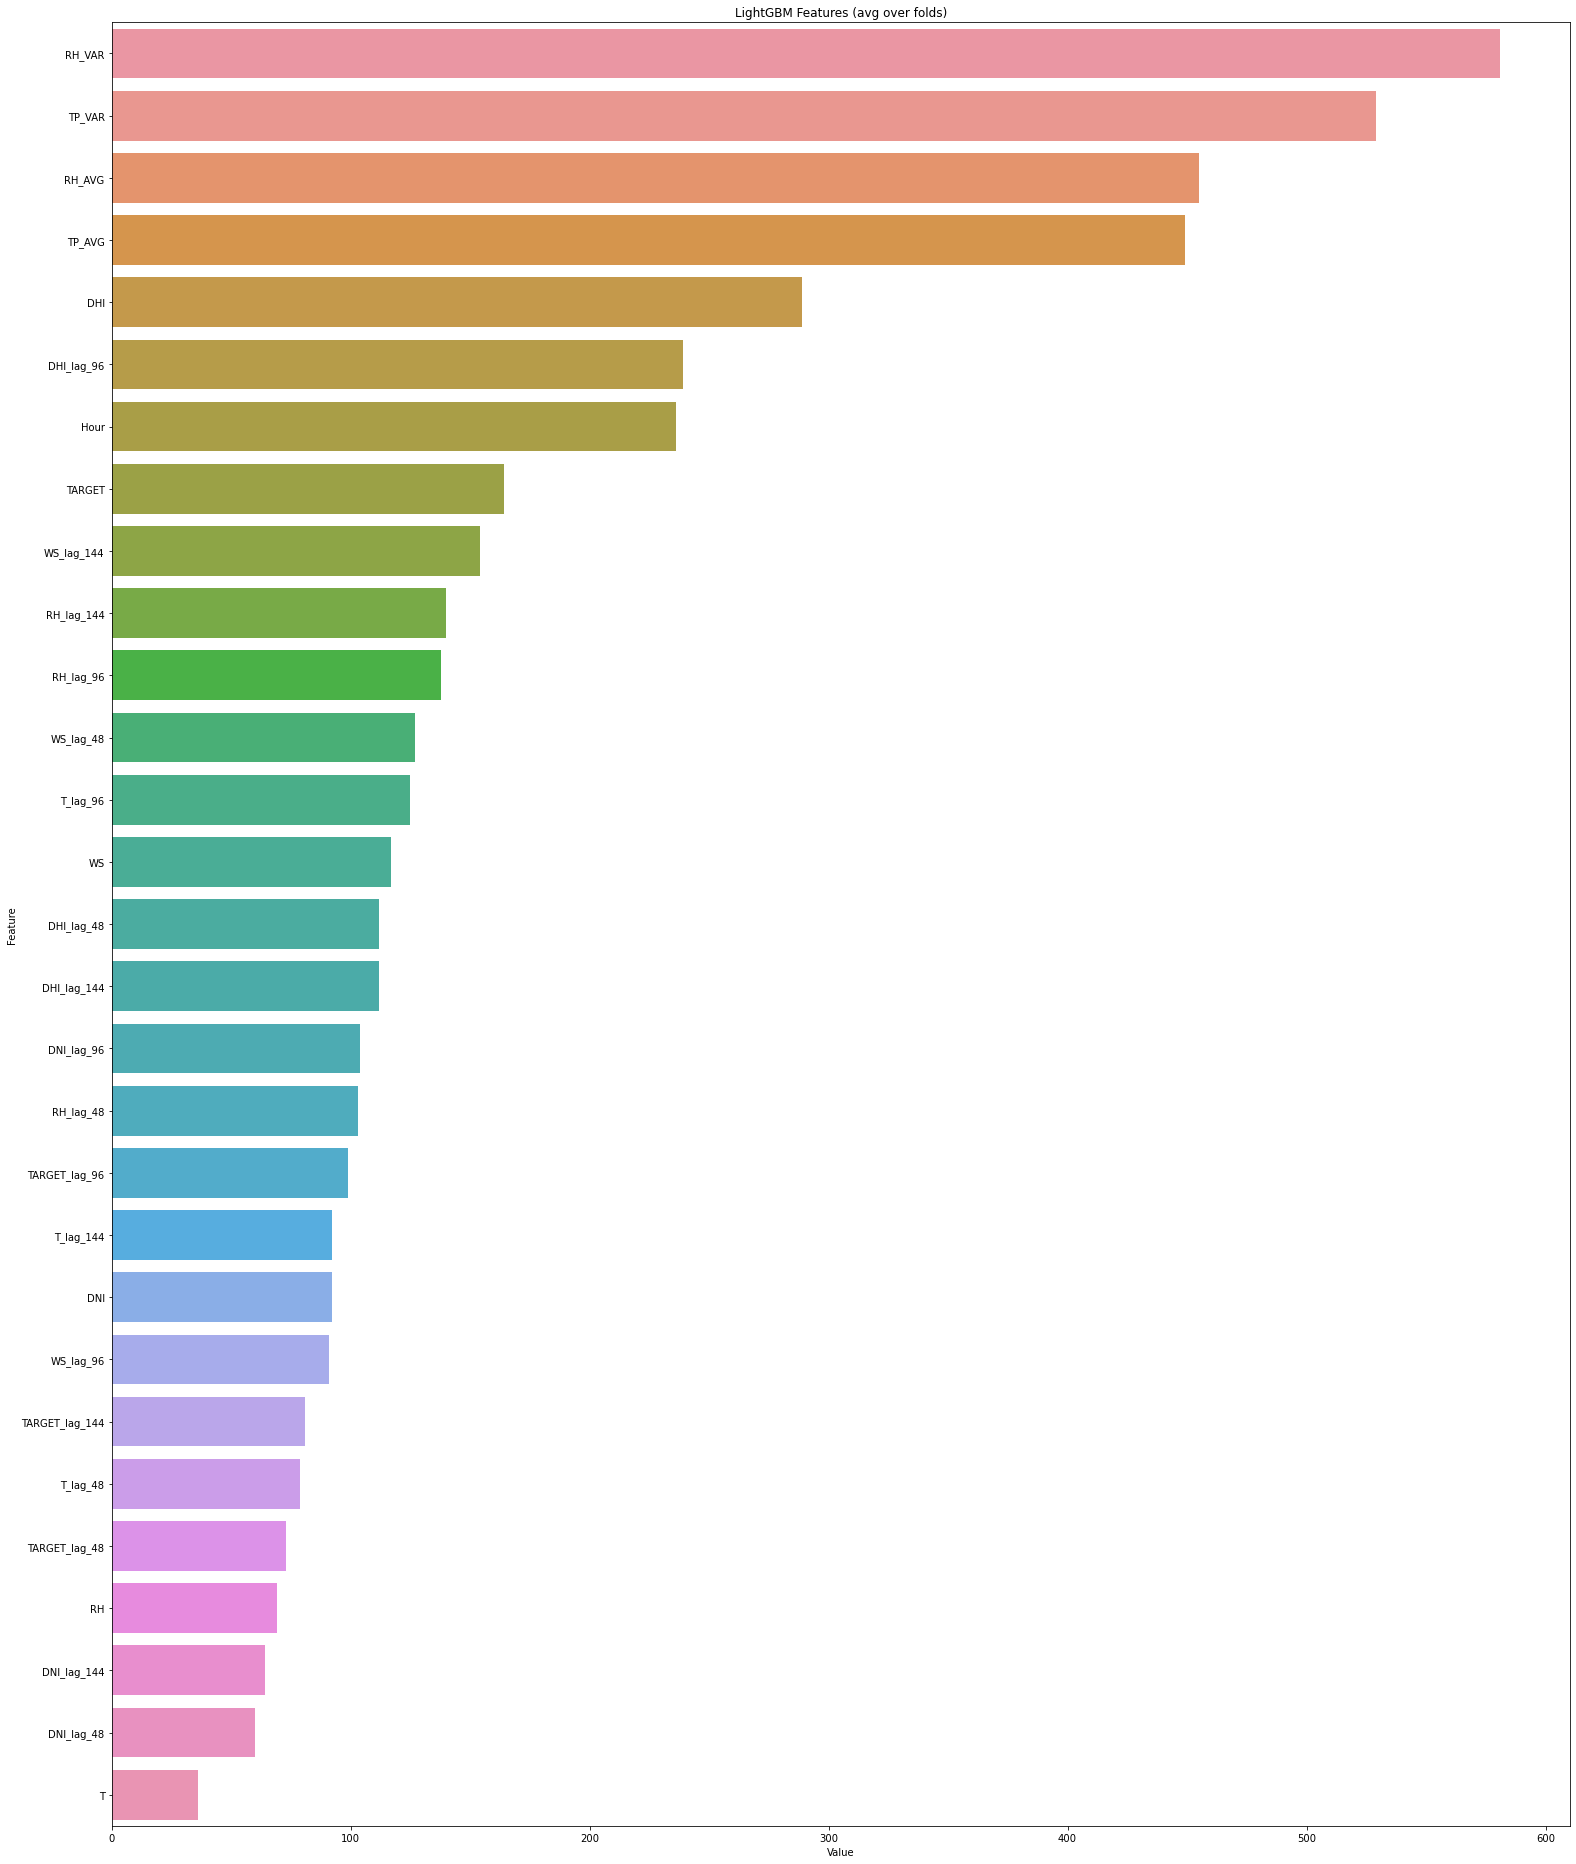

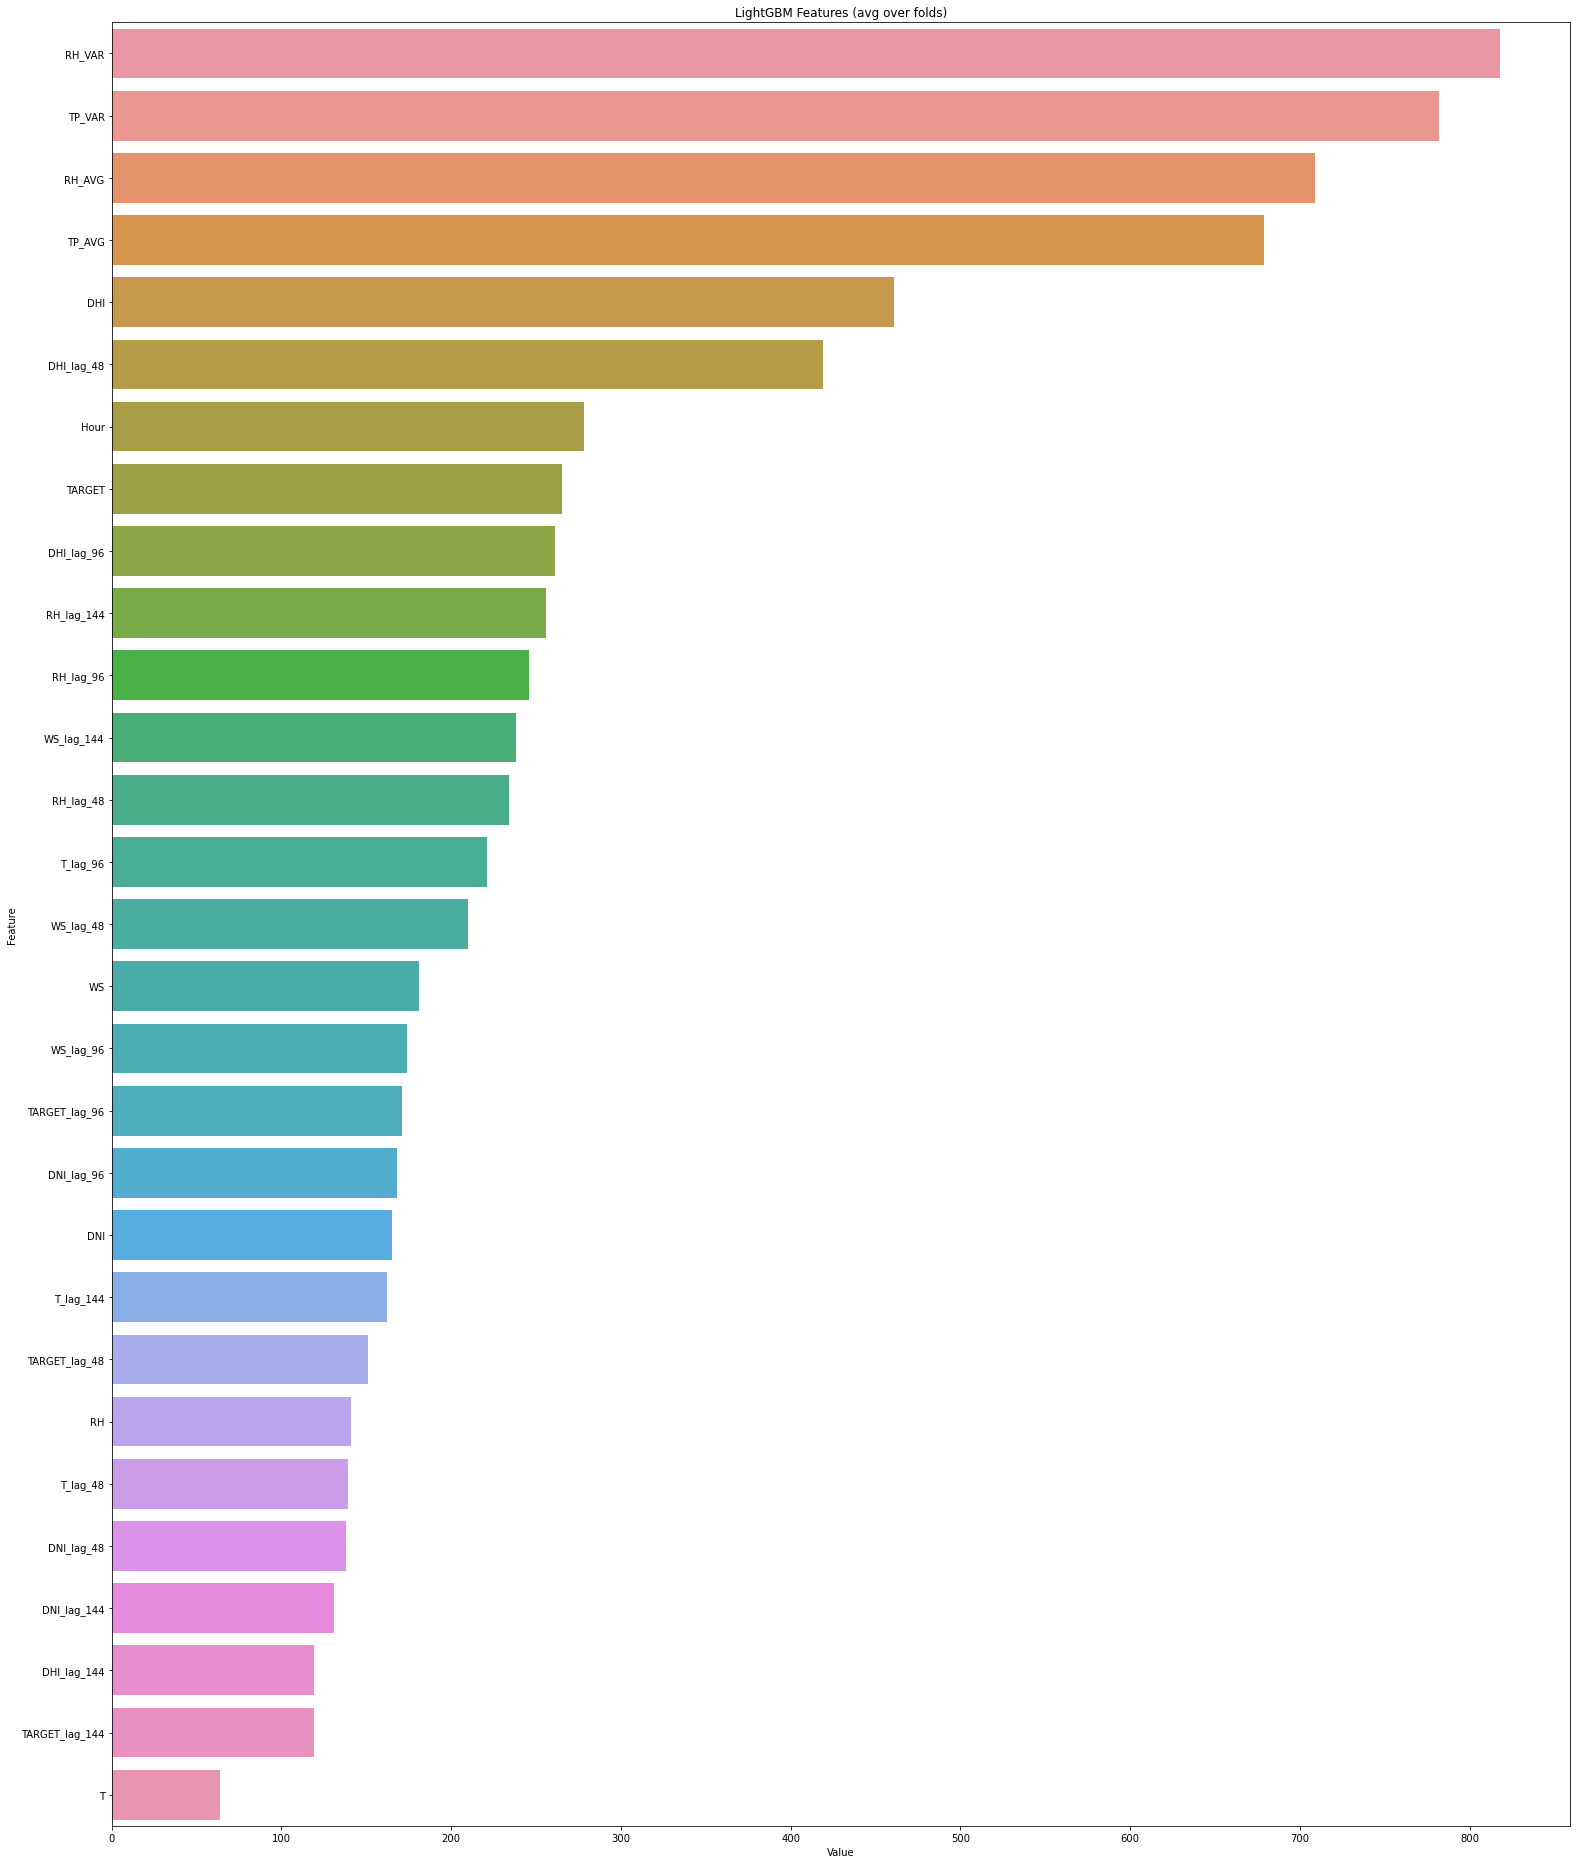

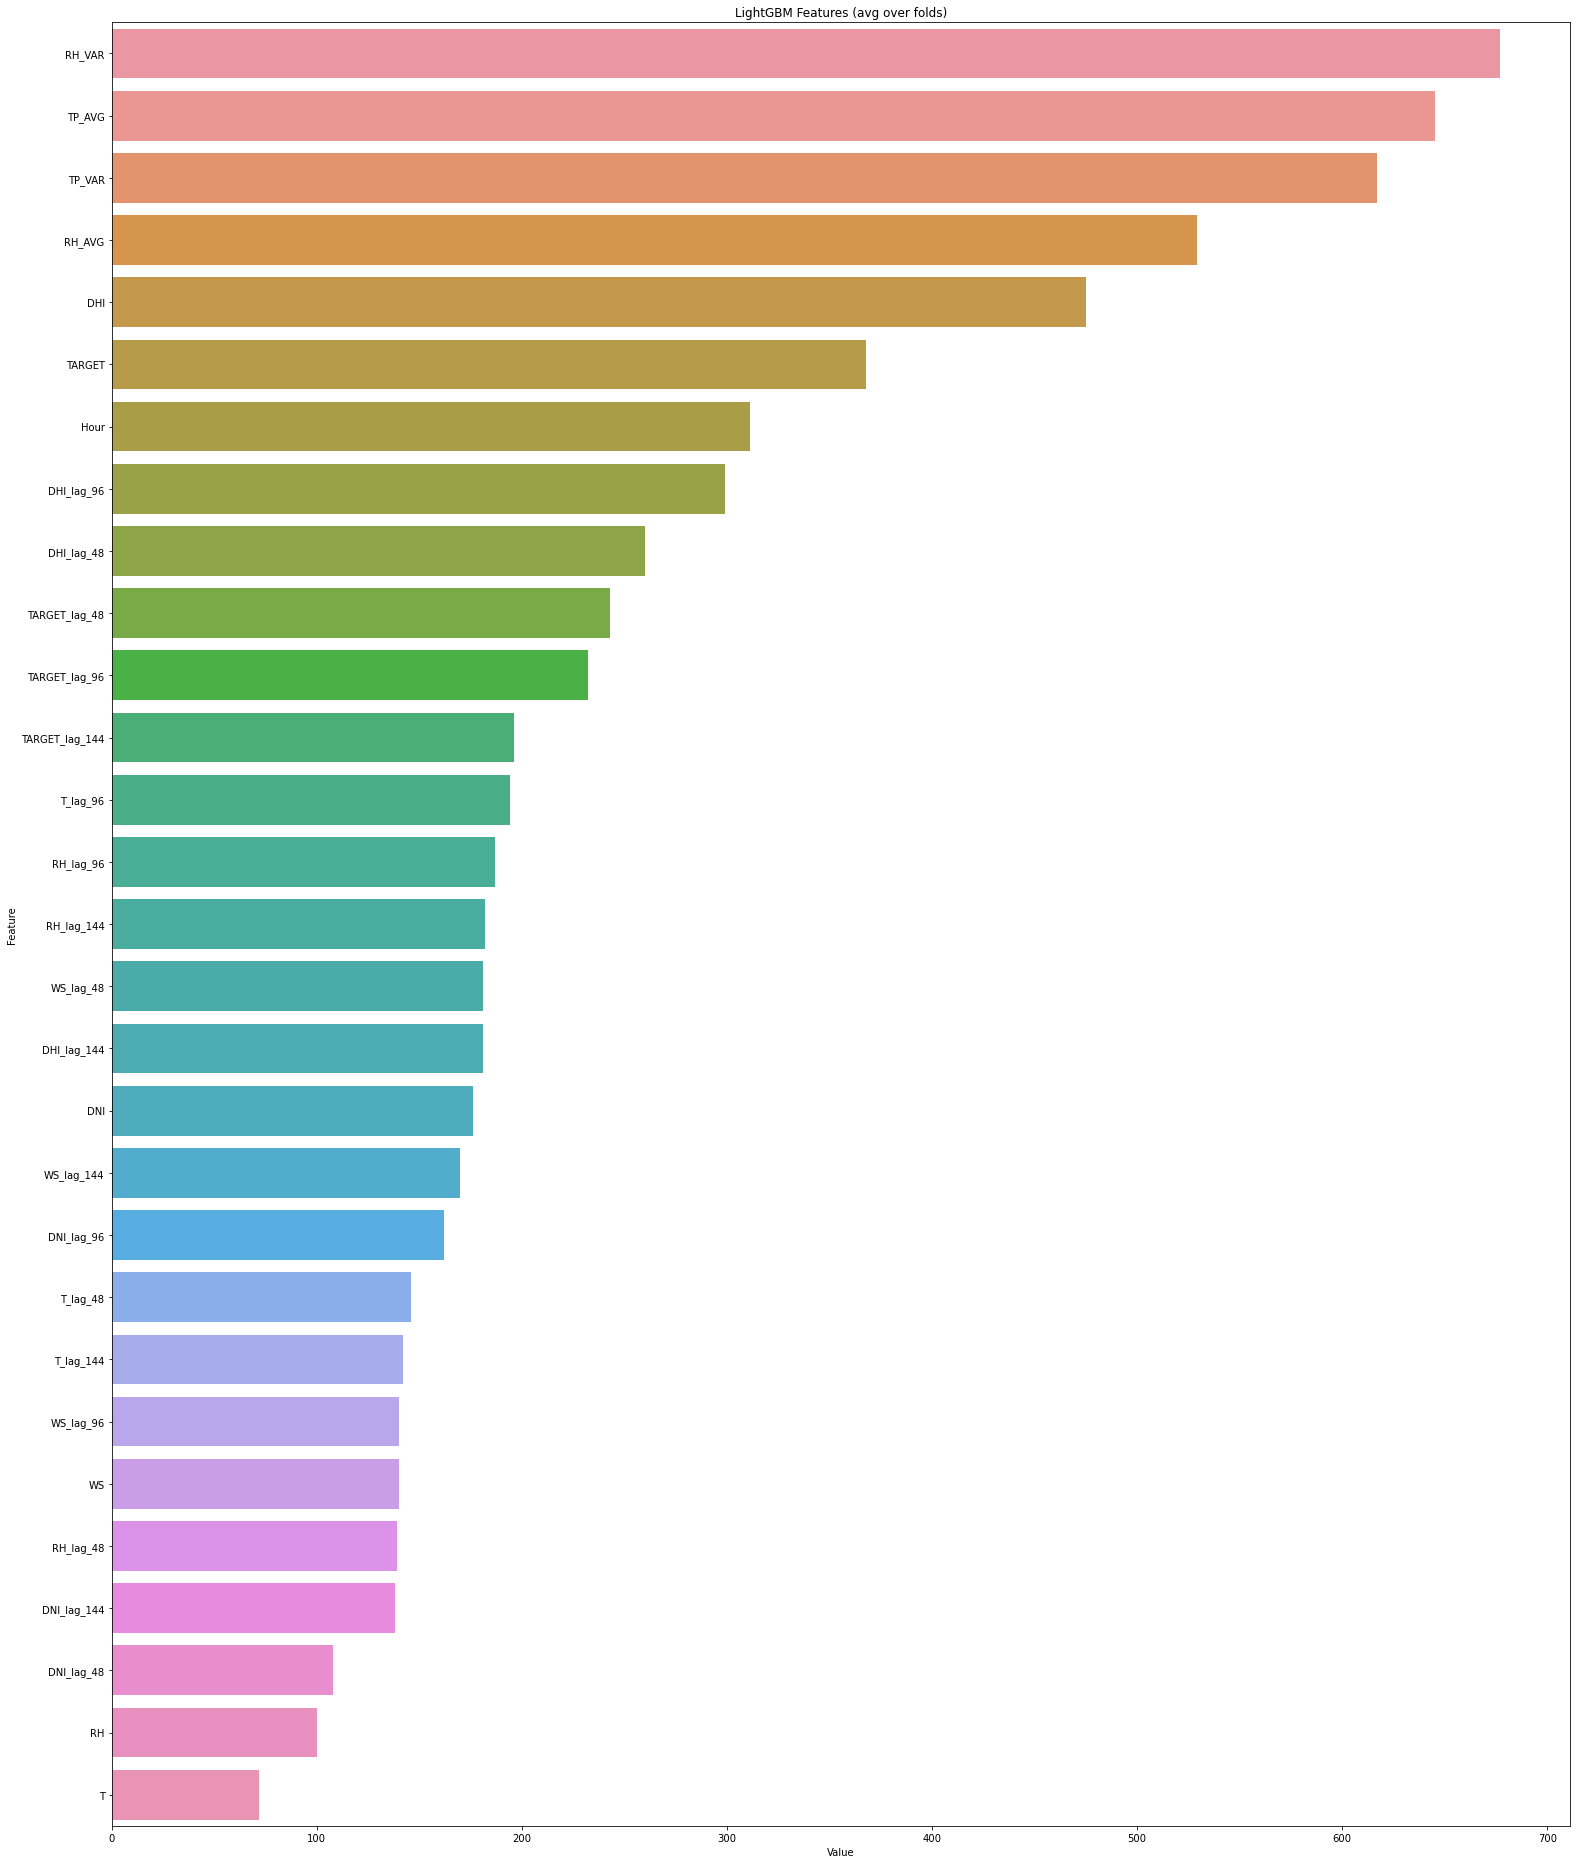

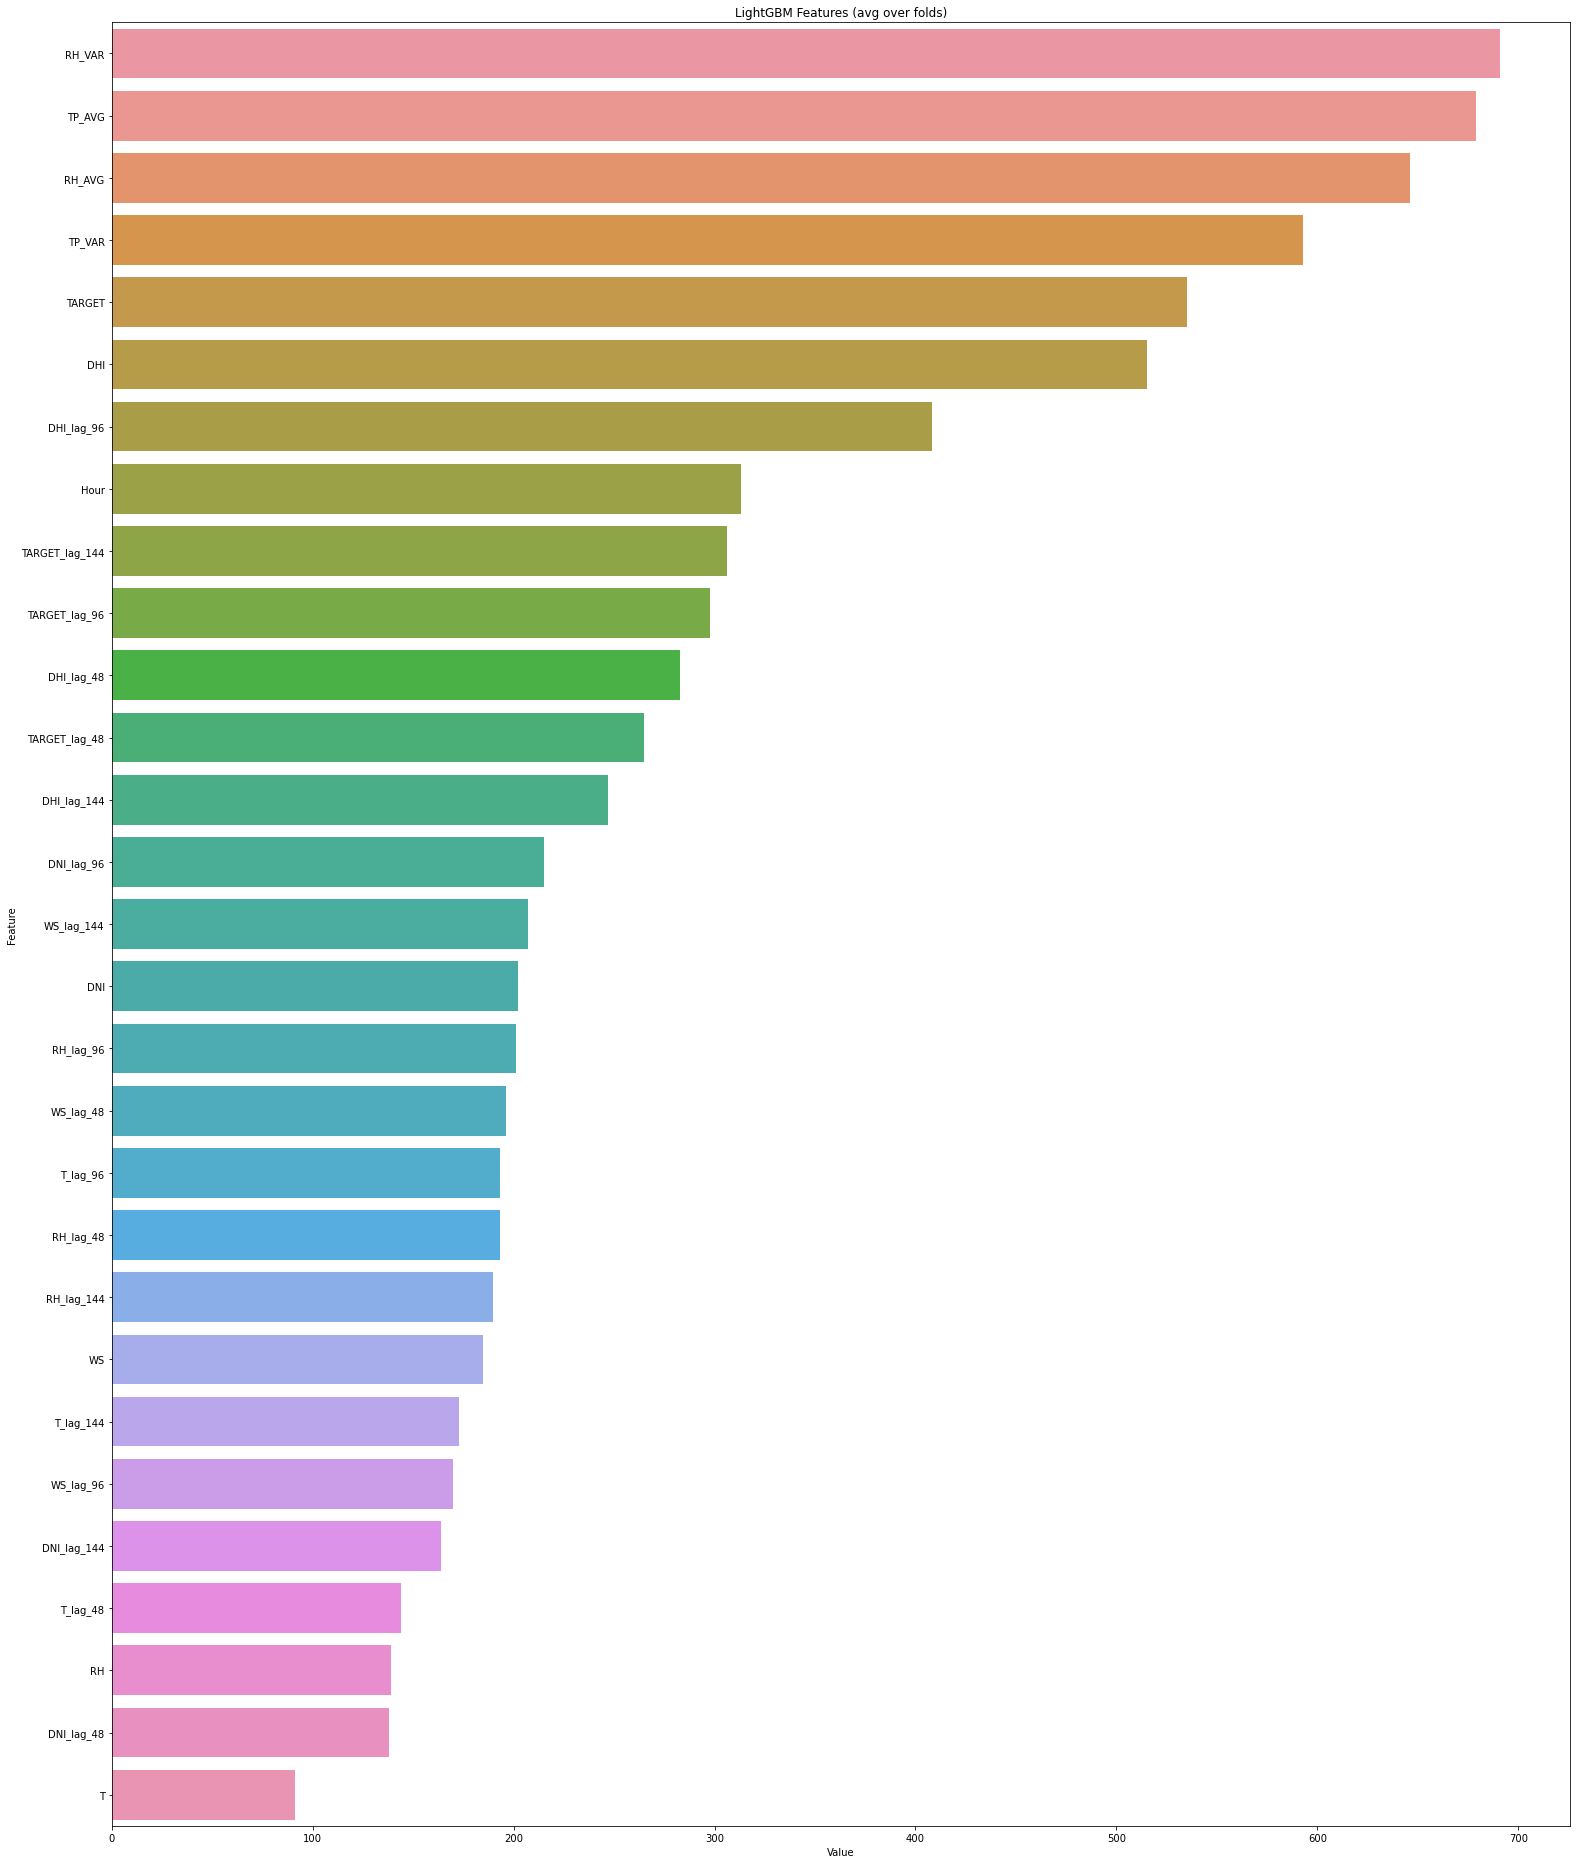

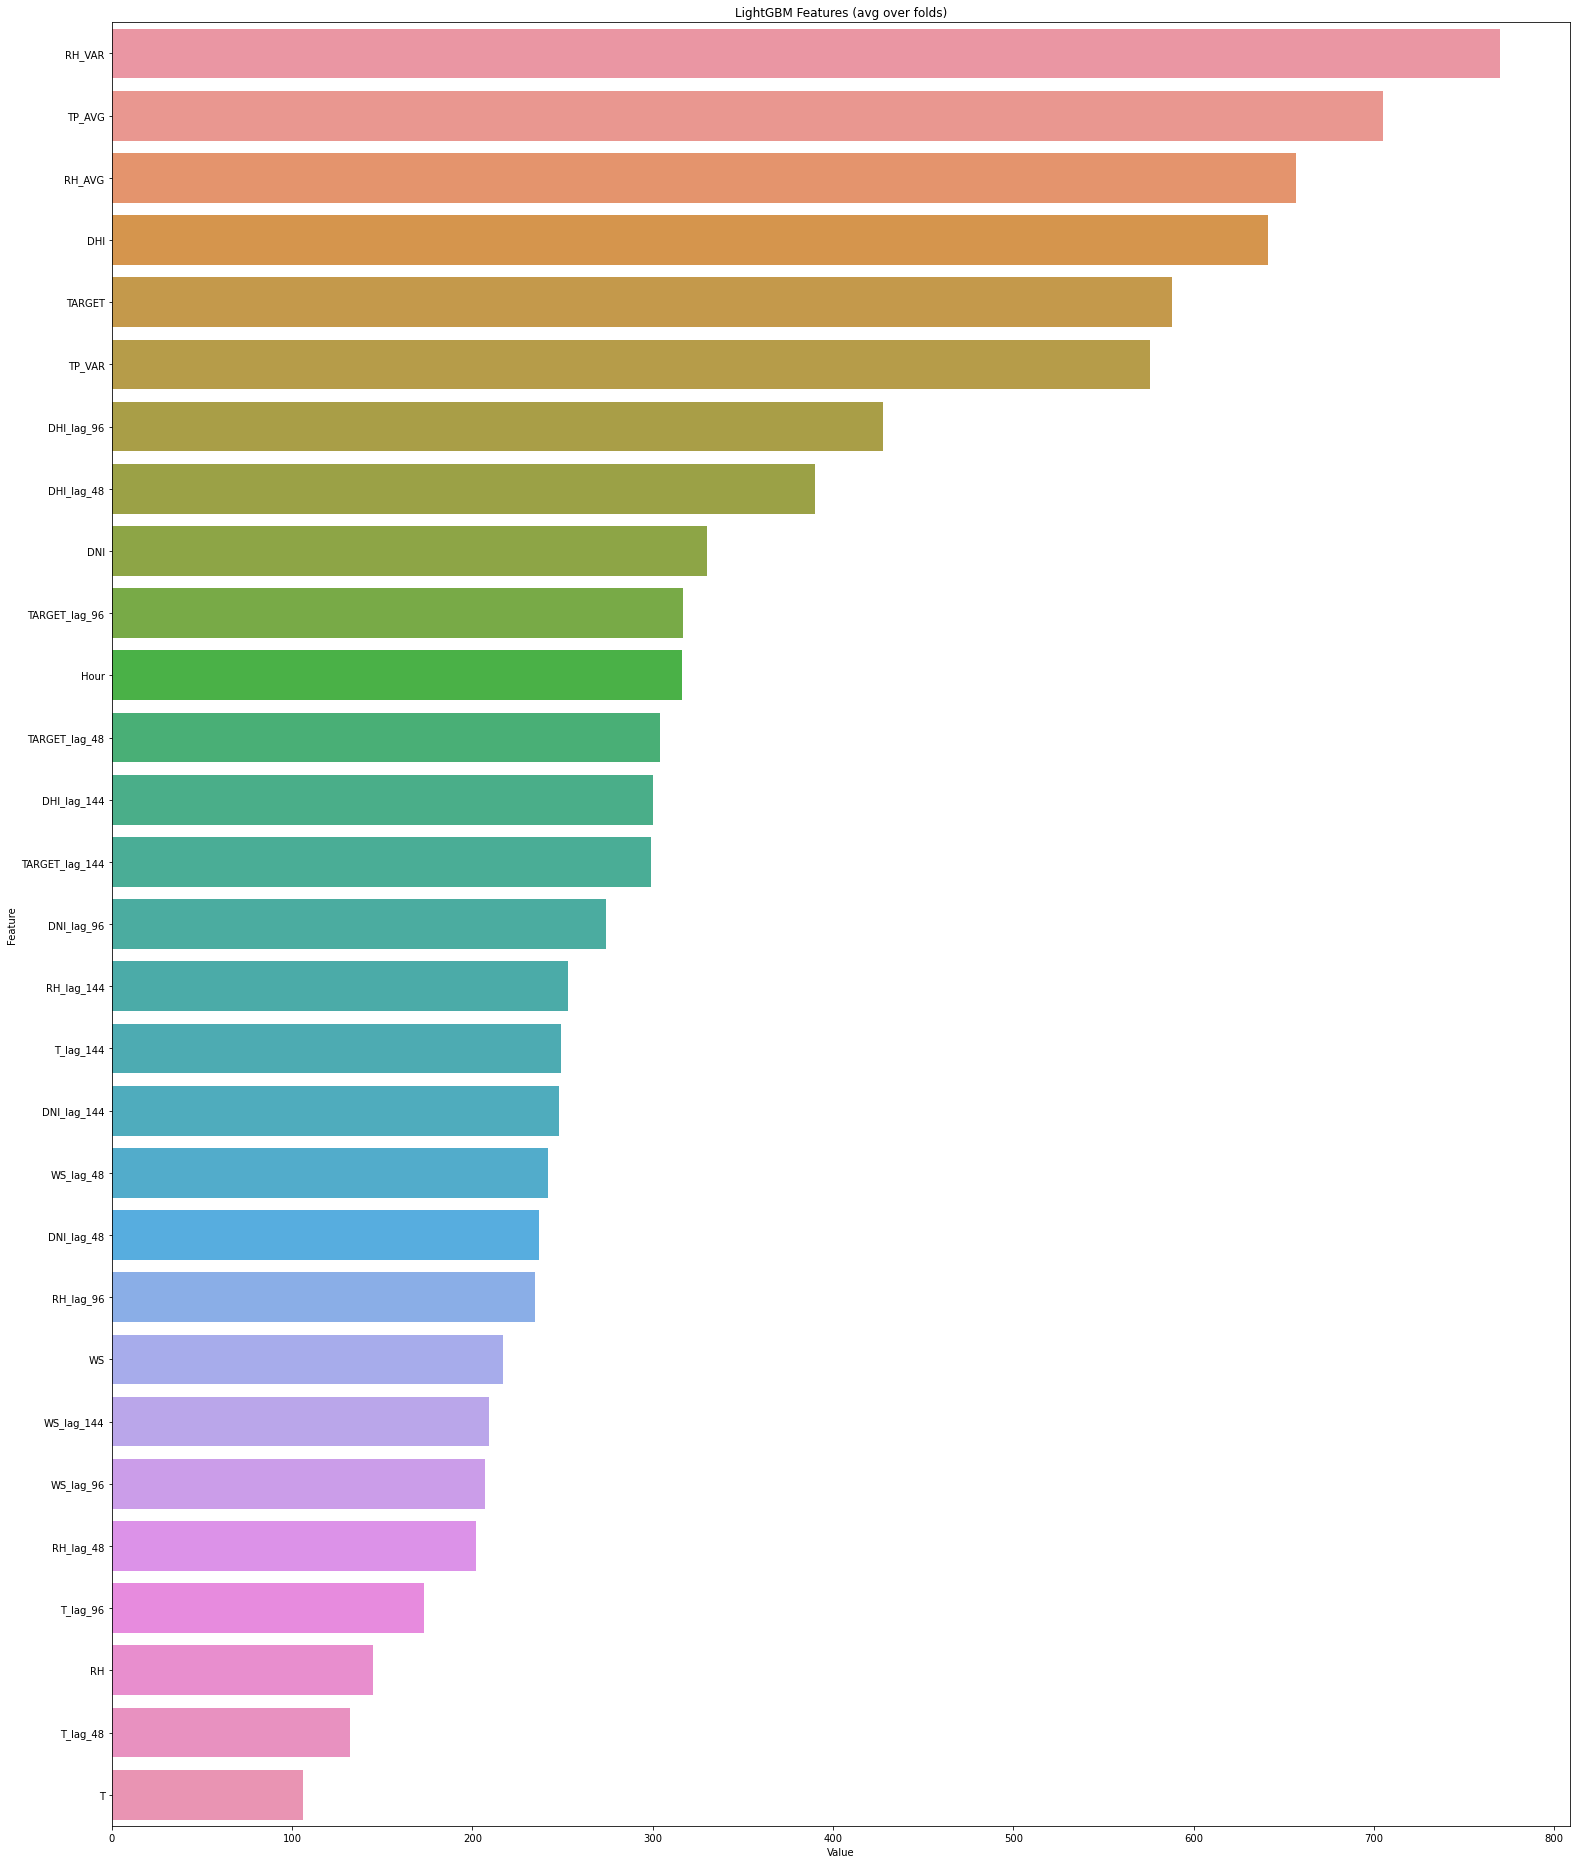

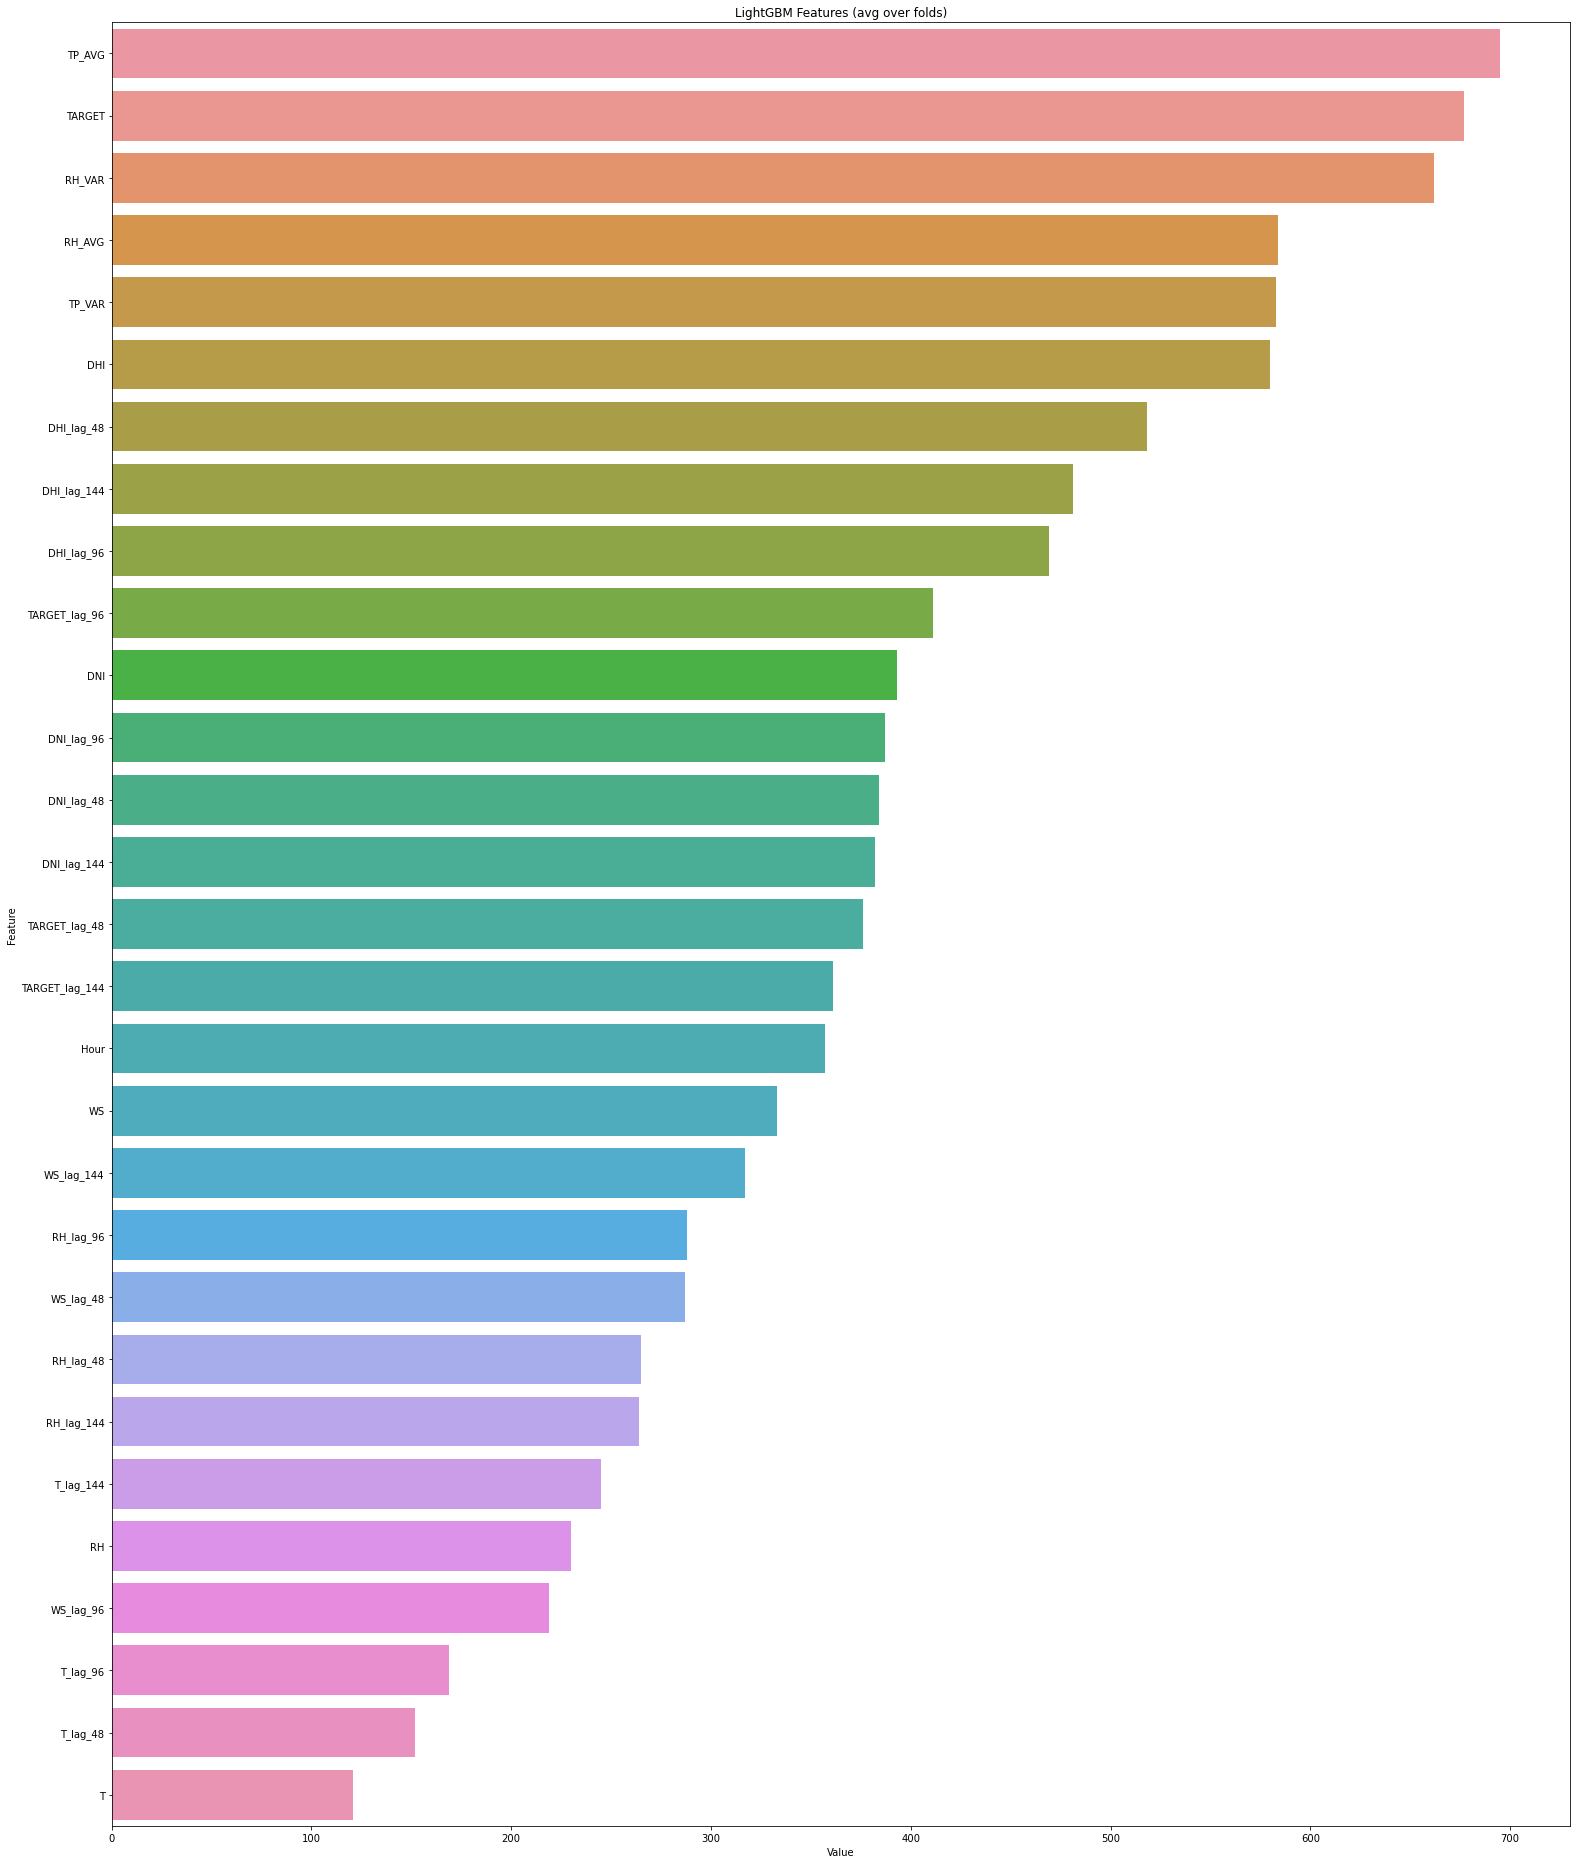

In [306]:
for i in range(len(models_2)):
    # sorted(zip(clf.feature_importances_, X.columns), reverse=True)
    feature_imp = pd.DataFrame(sorted(zip(models_2[i].feature_importances_,x_train.columns)),
                               columns=['Value','Feature'])

    plt.figure(figsize=(22, 26))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

## 앙상블 쓰기

### OOF

In [308]:
# kfold를 위한 모델 정의

# Get the model and the predictions in (a) - (b)
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', # quantile로 받아줘야 quatile regression이 가능합니다.
                          alpha=q, # 이건 나중에 quantile 받을 인자입니다.
                          n_estimators=100000, # 10000만번을 돌리겠다고? 미쳤어?
                          bagging_fraction=0.7,
                          learning_rate=0.027,
                          subsample=0.7)                   
                              
    model.fit(X_train,
              Y_train,
              eval_metric = ['quantile'],
              eval_set=[(X_valid, Y_valid)],
              early_stopping_rounds=200, # 200번 동안 loss가 줄지 않으면 멈춥니다.
              verbose=100) # 100번 마다 결과를 출력해줍니다.
    
    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

In [309]:
def oof_train_data(X, y, X_test, N_SPLIT=5):
    # kfold 셋으로 나눠서 교차 예측을 하고, 해당 결과를 앙상블해서 출력해주는 함수입니다.
    
    # 전처리 단계에서 index가 깨졌으니, 리셋해줍니다. 그래야 kfold로 잘 나눠집니다.
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    # split을 기준으로 kfold instance를 받아줍니다.
    N_SPLIT = N_SPLIT
    kf = KFold(n_splits=N_SPLIT, shuffle=False, random_state=42)
    
    # 퀀틸을 미리 셋팅해줍니다.
    quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
    # 먼저 pred 값을 받을 스키마를 만들어줍니다.
    oof_pred = pd.DataFrame(np.zeros((X_test.shape[0], len(quantiles))), columns=[0,0,0,0,0,0,0,0,0])
    oof_models = []
    
    # fold 별로 train, val을 찢고, 학습하고 예측까지 합니다.
    for i, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
        print("Kfold iteration count: ", i)
        print("------------------------------------------------")
        x_train, y_train = X.iloc[trn_idx, :], y[trn_idx]
        x_valid, y_valid = X.iloc[val_idx, :], y[val_idx]
        
        # 결과값을 받을 프레임을 잡아줍니다.
        LGBM_models = []
        LGBM_actual_pred = pd.DataFrame()

        # 퀀틸별로 모델 학습을 합니다.
        for q in quantiles:
            pred, model = LGBM(q, x_train, y_train, x_valid, y_valid, X_test)
            LGBM_models.append(model)
            LGBM_actual_pred = pd.concat([LGBM_actual_pred, pred],axis=1) #pred를 컨캣해줍니다.

        # ------ 여기까지가 한개의 폴드에 대한 pred 셋이 추출됩니다.
        # 전체 pred 스키마에 fold 별로 출력된 pred를 더해줍니다.(values 만 있기 때문에 값이 더해집니다.)
        oof_pred += LGBM_actual_pred
        # 나중에 쓸 일이 있으니 모델도 받아줍니다.
        oof_models += LGBM_models
        
    # values가 k개의 예측값이 더해졌으니, N_SPLIT의 수로 나눠줍니다. 평균을 내준다고 보면 됩니다.
    oof_pred = oof_pred/N_SPLIT    
    oof_pred.columns=quantiles # 컬럼은 퀀틸로 박아줍니다.
    
    return oof_models, oof_pred

In [312]:
def oof_make_dataset(df):
    
    X = df.iloc[:, df.columns != 'TARGET_1']
    X = X.iloc[:, X.columns != 'TARGET_2']
    y_1 = df['TARGET_1']
    y_2 = df['TARGET_2']
    
    print(X.shape)
    print(y_1.shape)
    print(y_2.shape)
    
    return X, y_1, y_2

In [313]:
X, y_1, y_2 = oof_make_dataset(shifted_train)

(52320, 29)
(52320,)
(52320,)


In [321]:
X.head()

,Hour,DHI,DNI,WS,RH,T,TARGET,RH_AVG,TP_AVG,RH_VAR,TP_VAR,DHI_lag_48,DNI_lag_48,WS_lag_48,RH_lag_48,T_lag_48,TARGET_lag_48,DHI_lag_96,DNI_lag_96,WS_lag_96,RH_lag_96,T_lag_96,TARGET_lag_96,DHI_lag_144,DNI_lag_144,WS_lag_144,RH_lag_144,T_lag_144,TARGET_lag_144
144,0.0,0,0,1.8,77.760002,-14,0.0,65.695213,-5.6875,55.322075,24.049202,0.0,0.0,2.2,73.800003,-8.0,0.0,0.0,0.0,1.6,90.660004,-10.0,0.0,0.0,0.0,1.5,69.080002,-12.0,0.0
145,0.5,0,0,2.0,77.769997,-13,0.0,65.695213,-5.6875,55.322075,24.049202,0.0,0.0,2.1,68.199997,-8.0,0.0,0.0,0.0,1.6,90.680000,-10.0,0.0,0.0,0.0,1.5,69.059998,-12.0,0.0
146,1.0,0,0,2.2,77.690002,-13,0.0,65.695213,-5.6875,55.322075,24.049202,0.0,0.0,2.1,69.059998,-8.0,0.0,0.0,0.0,1.6,88.110001,-11.0,0.0,0.0,0.0,1.6,71.779999,-12.0,0.0
147,1.5,0,0,2.2,71.570000,-13,0.0,65.695213,-5.6875,55.322075,24.049202,0.0,0.0,2.1,69.040001,-8.0,0.0,0.0,0.0,1.6,88.110001,-11.0,0.0,0.0,0.0,1.6,71.750000,-12.0,0.0
148,2.0,0,0,2.2,72.620003,-13,0.0,65.695213,-5.6875,55.322075,24.049202,0.0,0.0,2.2,69.379997,-8.0,0.0,0.0,0.0,1.6,90.849998,-11.0,0.0,0.0,0.0,1.6,75.199997,-12.0,0.0


In [314]:
%%time
# Target1
models_1, results_1 = oof_train_data(X, y_1, X_test, 5)

Kfold iteration count:  0
------------------------------------------------
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 200 rounds
[100]	valid_0's quantile: 1.54639
[200]	valid_0's quantile: 1.57213
Early stopping, best iteration is:
[80]	valid_0's quantile: 1.54467
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 200 rounds
[100]	valid_0's quantile: 2.58205
[200]	valid_0's quantile: 2.6115
[300]	valid_0's quantile: 2.63456
Early stopping, best iteration is:
[101]	valid_0's quantile: 2.58175
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 200 rounds
[100]	valid_0's quantile: 3.20873
[200]	valid_0's quantile: 3.19507
[300]	valid_0'

In [315]:
%%time
# Target2
models_2, results_2 = oof_train_data(X, y_2, X_test, 5)

Kfold iteration count:  0
------------------------------------------------
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 200 rounds
[100]	valid_0's quantile: 1.58661
[200]	valid_0's quantile: 1.63581
Early stopping, best iteration is:
[71]	valid_0's quantile: 1.5771
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 200 rounds
[100]	valid_0's quantile: 2.71073
[200]	valid_0's quantile: 2.81448
Early stopping, best iteration is:
[84]	valid_0's quantile: 2.7022
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 200 rounds
[100]	valid_0's quantile: 3.39564
[200]	valid_0's quantile: 3.47625
[300]	valid_0's quantile: 3.53506
Early stopping, 

In [319]:
scores_1 = []
scores_2 = []
for i in models_1:
    t = i.best_score_.popitem()
    t_2 = t[1].popitem()
    scores_1.append(t_2[1])
    
for i in models_2:
    t = i.best_score_.popitem()
    t_2 = t[1].popitem()
    scores_2.append(t_2[1])

np.mean(scores_1).round(5), np.mean(scores_2).round(5), np.mean(scores_1 + scores_2).round(5)

(2.04184, 2.1418, 2.09182)

In [323]:
# lag model 3 window decross model

submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission[16:33]

#submission.to_csv('./submission/submission_210120-4_oof-notshuffle-4shifted-avgvar.csv', index=False)

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
16,0.csv_Day7_8h00m,2.858,3.806,4.924,5.124,5.764,6.098,6.608,6.940,7.830
17,0.csv_Day7_8h30m,5.100,7.090,9.348,10.654,10.926,13.544,14.130,12.780,14.600
18,0.csv_Day7_9h00m,6.682,10.530,13.898,16.892,19.878,21.392,22.104,22.456,20.666
19,0.csv_Day7_9h30m,9.412,14.900,18.224,21.890,26.514,23.598,27.728,28.890,29.142
20,0.csv_Day7_10h00m,12.236,17.530,22.202,28.190,32.080,30.920,33.812,36.342,35.362
21,0.csv_Day7_10h30m,13.280,19.636,24.594,28.954,32.208,33.276,36.440,41.244,37.622
22,0.csv_Day7_11h00m,14.772,23.268,29.366,35.084,38.920,39.118,40.752,44.820,43.766
23,0.csv_Day7_11h30m,14.860,22.832,28.438,33.530,37.504,37.910,40.076,45.432,45.550
24,0.csv_Day7_12h00m,15.800,24.772,31.016,35.830,40.932,41.506,43.850,46.188,46.184
25,0.csv_Day7_12h30m,16.130,24.364,33.014,38.470,43.466,45.802,46.378,47.092,45.942


## 스택킹 쓰기